In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import t
from scipy.stats import uniform
from scipy.stats import ttest_1samp # library for p-value estimation
import ruptures as rpt # library for change point detection
%matplotlib inline
%run ./master_experminet-functions.ipynb
# load functions for the creation of the different distributions

In [12]:
#define arms
def quick_sort(df, columns):
    sorted_df = df.sort_values(columns, kind="quicksort")
    return sorted_df
def merge_sort(df, columns):
    sorted_df = df.sort_values(columns, kind="mergesort")
    return sorted_df
def heap_sort(df, columns):
    sorted_df = df.sort_values(columns, kind="heapsort")
    return sorted_df

In [13]:
n_samples = 100000
choices = [quick_sort,merge_sort,heap_sort]
choices_names = ["quick_sort","merge_sort","heap_sort"]
dist_types = ["Uniform","Normal","Uniform_Sorted","Uniform_Reverse_Sorted","Uniform_Nearly_Sorted","Zipf"]

In [14]:
#list_distributions = 1000*["Uniform_Sorted"] + 1000*["Normal"] # at first quick sort -> then merge sort 
list_distributions = 500*["Uniform"] + 500*["Uniform_Reverse_Sorted"]
#list_distributions = 100*["Uniform"] +  100*["Uniform_Sorted"] + 100*["Normal"] + 100*["Uniform_Reverse_Sorted"]

In [15]:
def plot_history(rewards,cum_rewards,sample_count, sample_mean):

    q_values = {"quick_sort": sample_mean[0], "merge_sort": sample_mean[1], "heap_sort":sample_mean[2]} ## 
    arm_counts = {"quick_sort": sample_count[0], "merge_sort": sample_count[1], "heap_sort":sample_count[2]} ##
    print("Average rewards per algo", q_values)
    print("Count per chosen algo", arm_counts)
    
    fig = plt.figure(figsize=[30,8])
    ax2 = fig.add_subplot(121)
    ax2.plot(cum_rewards, label="avg rewards")
    ax2.set_title("Cummulative Rewards")
    labels = list(arm_counts.keys())
    ax3 = fig.add_subplot(122)
    ax3.bar([i for i in range(len(arm_counts.values()))], arm_counts.values(), label=[i for i in ((list(arm_counts.keys())))])
    ax3.set_title("Chosen Actions")
    plt.show() 

In [16]:
# help function to return the humber of consecutive elements in a list 
def count_consec(listrand):
    count=1
    consec_list=[]
    for i in range(len(listrand[:-1])):
        if listrand[i]+1 == listrand[i+1]:
            count+=1
        else:
            consec_list.append(count)
            count=1

    # Account for the last iteration
    consec_list.append(count)     

    return consec_list

In [17]:
def TS_stationary(list_distributions, n_samples, var_multiplier = 5): # initialize
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = 5
    list_iteration_results = []

    len_result = 1

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.perf_counter() #time.time()
        sorted_dist = alg(distribion, [dist_type])
        reward = ((time.perf_counter() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards[choice])
        sample_var[choice] = np.var(arm_rewards[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        array_rewards = np.array(rewards)

    list_iteration_results.extend([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward

In [18]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [19]:
def plot_rewards_distribution(arm_rewards, bins = 20):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 3))
    axes[0].hist(arm_rewards[0], bins, alpha = 0.5, label='quick sort')
    axes[0].set_title("rewards distribution for quick sort")
    axes[1].hist(arm_rewards[1], bins, alpha = 0.5, label='merge sort')
    axes[1].set_title("rewards distribution for merge sort")
    axes[2].hist(arm_rewards[2], bins, alpha = 0.5, label='heap sort')
    axes[2].set_title("rewards distribution for heap sort")
    plt.show()

In [20]:
def plot_rewards_distribution_together(arm_rewards, bins = 20):
    plt.hist(arm_rewards[0], bins, alpha = 0.5, label='quick sort')
    plt.hist(arm_rewards[1], bins, alpha = 0.5, label='merge sort')
    plt.hist(arm_rewards[2], bins, alpha = 0.5, label='heap sort')
    plt.legend(loc='upper right')
    plt.show()

In [21]:
import bayesian_changepoint_detection.online_changepoint_detection as oncd
from functools import partial
import matplotlib.cm as cm

## Thompson Sampling

In [22]:
def ts_quantile(list_distributions, n_samples, var_multiplier = 5, num_consec_elem=1):
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    arm_rewards_temp = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = var_multiplier
    n_consecutive_list = [] # this list is to check whether
    list_iteration_results = []
    num_consec_elem = num_consec_elem

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=0.1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.perf_counter()
        sorted_dist = alg(distribion, [dist_type])
        reward = ((time.perf_counter() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        arm_rewards_temp[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards_temp[choice])
        sample_var[choice] = np.var(arm_rewards_temp[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        if len(arm_rewards_temp[choice])>10:
            if reward < np.quantile(arm_rewards_temp[choice][:-1], 0.025) or reward > np.quantile(arm_rewards_temp[choice][:-1], 0.975):
                n_consecutive_list.append(n)
                if any(i >= num_consec_elem for i in count_consec(n_consecutive_list)):
                    print("RESTART EXPERIMENT")
                    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
                    sample_count = [0 for i in range(num_choices)]
                    sample_rewards = [0 for i in range(num_choices)]
                    sample_mean = [0.0 for i in range(num_choices)]
                    sample_var = [0.0 for i in range(num_choices)]
                    arm_rewards_temp = {0: [], 1:[], 2:[]}
                    rewards = []
                    cum_rewards = []
                    n_consecutive_list = []
    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward, arm_rewards

## Single outlier restarts the expriment

In [23]:
list_iteration_results_1, total_reward_1, arm_rewards_1 = ts_quantile(list_distributions, n_samples)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.06974537740736873
Less than two values for merge_sort
merge_sort Theta 0.07894474752782747
Less than two values for heap_sort
heap_sort Theta 0.0656809850457561


Chosen algorithm is:  heap_sort with reward: 0.026584700000057637
Sample mean is:  0.026584700000057637 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.0733775924495355
Less than two values for merge_sort
merge_sort Theta 0.04845124309175587
Less than two values for heap_sort
heap_sort Theta 0.0538181452571328


Chosen algorithm is:  merge_sort with reward: 0.015643699999600358
Sample mean is:  0.015643699999600358 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.0510300612374551
Less than two values for merge_sort
merge_sort Theta 0.013801492772488566
Less than two values for heap_sort
heap_sort Theta 0.03998268760586063


Chosen algorithm is:  merge_sort with reward

quick_sort Theta 0.012594740829165696
merge_sort Theta 0.015211746684214149
Less than two values for heap_sort
heap_sort Theta 0.07804904994832533


Chosen algorithm is:  quick_sort with reward: 0.016775300000517746
Sample mean is:  0.01554468000013003 Sample variance is: 1.2032469702319694e-06


Iteration: 33
quick_sort Theta 0.0166319852771842
merge_sort Theta 0.015356495878747342
Less than two values for heap_sort
heap_sort Theta 0.06311878816046583


Chosen algorithm is:  merge_sort with reward: 0.01711509999950067
Sample mean is:  0.01574539999978697 Sample variance is: 6.286004147614502e-07


Iteration: 34
quick_sort Theta 0.017015270408090664
merge_sort Theta 0.02158669155005312
Less than two values for heap_sort
heap_sort Theta 0.050826015802885365


Chosen algorithm is:  quick_sort with reward: 0.01523079999969923
Sample mean is:  0.015492366666724896 Sample variance is: 1.0163892327864242e-06


Iteration: 35
quick_sort Theta 0.01760013506146193
merge_sort Theta 0.011025339916


Chosen algorithm is:  quick_sort with reward: 0.015303700000004028
Sample mean is:  0.014569533333087747 Sample variance is: 4.507737491962155e-07


Iteration: 65
quick_sort Theta 0.023507247502122672
merge_sort Theta 0.016623628998280817
heap_sort Theta 0.01849389500050567


Chosen algorithm is:  merge_sort with reward: 0.019019500000467815
Sample mean is:  0.016387658333390693 Sample variance is: 2.7285005711416488e-06


Iteration: 66
quick_sort Theta 0.015747716671963622
merge_sort Theta 0.013896727981604616
heap_sort Theta 0.021349322779318294


Chosen algorithm is:  merge_sort with reward: 0.01671879999958037
Sample mean is:  0.01641313076925144 Sample variance is: 2.5264020516872173e-06


Iteration: 67
quick_sort Theta 0.019186479398485046
merge_sort Theta 0.01787328664610524
heap_sort Theta 0.025156409197083784


Chosen algorithm is:  merge_sort with reward: 0.016173300000446034
Sample mean is:  0.016396000000051054 Sample variance is: 2.349759784575147e-06


Iteration: 68
quic



Iteration: 98
quick_sort Theta 0.015159031643976943
Less than two values for merge_sort
merge_sort Theta 0.00882460558636925
heap_sort Theta 0.05276871671145473


Chosen algorithm is:  merge_sort with reward: 0.01742149999972753
Sample mean is:  0.01742149999972753 Sample variance is: 0.0


Iteration: 99
quick_sort Theta 0.01457526767011243
Less than two values for merge_sort
merge_sort Theta 0.01656322814876071
heap_sort Theta 0.02254432189659134


Chosen algorithm is:  quick_sort with reward: 0.013882600000215461
Sample mean is:  0.01425842000007833 Sample variance is: 1.9368461772692163e-07


Iteration: 100
quick_sort Theta 0.014704468705513882
Less than two values for merge_sort
merge_sort Theta 0.0806456538054317
heap_sort Theta 0.022291653918059366


Chosen algorithm is:  quick_sort with reward: 0.012788699999873643
Sample mean is:  0.014013466666710883 Sample variance is: 4.6141452574488877e-07


Iteration: 101
quick_sort Theta 0.014889739645830397
Less than two values for mer



Iteration: 129
quick_sort Theta 0.014035804978839944
Less than two values for merge_sort
merge_sort Theta 0.05210106804869999
heap_sort Theta 0.02247522837322079


Chosen algorithm is:  quick_sort with reward: 0.014887899999848742
Sample mean is:  0.013706353846128668 Sample variance is: 3.48750576263005e-07
RESTART EXPERIMENT


Iteration: 130
Less than two values for quick_sort
quick_sort Theta 0.04710934842810821
Less than two values for merge_sort
merge_sort Theta 0.09182668581624098
Less than two values for heap_sort
heap_sort Theta 0.07509972232222314


Chosen algorithm is:  quick_sort with reward: 0.014311599999928148
Sample mean is:  0.014311599999928148 Sample variance is: 0.0


Iteration: 131
Less than two values for quick_sort
quick_sort Theta 0.05284167889038141
Less than two values for merge_sort
merge_sort Theta 0.05790670682122162
Less than two values for heap_sort
heap_sort Theta 0.09629907498264655


Chosen algorithm is:  quick_sort with reward: 0.013612900000225636
S

Chosen algorithm is:  quick_sort with reward: 0.014148499999464548
Sample mean is:  0.014087257142689071 Sample variance is: 8.173660837870918e-08


Iteration: 158
quick_sort Theta 0.014232791361135163
merge_sort Theta 0.016449149378036848
heap_sort Theta 0.021970614866419942


Chosen algorithm is:  quick_sort with reward: 0.01511800000025687
Sample mean is:  0.014216099999885046 Sample variance is: 1.877229052843273e-07


Iteration: 159
quick_sort Theta 0.014109821416746732
merge_sort Theta 0.015148456589991654
heap_sort Theta 0.023532966933969487


Chosen algorithm is:  quick_sort with reward: 0.014309199999843258
Sample mean is:  0.014226444444324847 Sample variance is: 1.6772086494332496e-07


Iteration: 160
quick_sort Theta 0.014662256356653495
merge_sort Theta 0.01662737126689951
heap_sort Theta 0.02310989655693381


Chosen algorithm is:  quick_sort with reward: 0.013710999999602791
Sample mean is:  0.014174899999852641 Sample variance is: 1.7486024625252703e-07


Iteration: 161




Chosen algorithm is:  quick_sort with reward: 0.01768549999997049
Sample mean is:  0.014537622222127943 Sample variance is: 2.508723127994446e-06


Iteration: 185
quick_sort Theta 0.014241863858827409
merge_sort Theta 0.014306913684058746
heap_sort Theta 0.02311896680139551


Chosen algorithm is:  quick_sort with reward: 0.013813700000355311
Sample mean is:  0.01446522999995068 Sample variance is: 2.305016519680861e-06


Iteration: 186
quick_sort Theta 0.015892443353008785
merge_sort Theta 0.01633095664647843
heap_sort Theta 0.022247321925048837


Chosen algorithm is:  quick_sort with reward: 0.012942199999997683
Sample mean is:  0.01432677272722768 Sample variance is: 2.2871737270451485e-06
RESTART EXPERIMENT


Iteration: 187
Less than two values for quick_sort
quick_sort Theta 0.016194976194156274
Less than two values for merge_sort
merge_sort Theta 0.07565962924206898
Less than two values for heap_sort
heap_sort Theta 0.07790294062895421


Chosen algorithm is:  quick_sort with rew



Iteration: 210
Less than two values for quick_sort
quick_sort Theta 0.04297649469581777
merge_sort Theta 0.014665557975684038
Less than two values for heap_sort
heap_sort Theta 0.04170803993720752


Chosen algorithm is:  merge_sort with reward: 0.01608810000016092
Sample mean is:  0.016220389999944018 Sample variance is: 1.939152152844277e-06


Iteration: 211
Less than two values for quick_sort
quick_sort Theta 0.004731613125204814
merge_sort Theta 0.01689796906205463
Less than two values for heap_sort
heap_sort Theta 0.0685883124840534


Chosen algorithm is:  quick_sort with reward: 0.013728099999752885
Sample mean is:  0.014030899999852409 Sample variance is: 9.16878400602714e-08


Iteration: 212
quick_sort Theta 0.01536259953365081
merge_sort Theta 0.01957455207796334
Less than two values for heap_sort
heap_sort Theta 0.042900579447884474


Chosen algorithm is:  quick_sort with reward: 0.013911199999711243
Sample mean is:  0.013990999999805354 Sample variance is: 6.43092467143576e

merge_sort Theta 0.030191460067193712
heap_sort Theta 0.023992746115576304


Chosen algorithm is:  quick_sort with reward: 0.017348299999866867
Sample mean is:  0.014500265000060608 Sample variance is: 1.4469724623056355e-06
RESTART EXPERIMENT


Iteration: 239
Less than two values for quick_sort
quick_sort Theta 0.09359337884420148
Less than two values for merge_sort
merge_sort Theta 0.03372176652037541
Less than two values for heap_sort
heap_sort Theta 0.022700255505473332


Chosen algorithm is:  heap_sort with reward: 0.02393339999980526
Sample mean is:  0.02393339999980526 Sample variance is: 0.0


Iteration: 240
Less than two values for quick_sort
quick_sort Theta 0.06502954924292952
Less than two values for merge_sort
merge_sort Theta 0.08223108178079731
Less than two values for heap_sort
heap_sort Theta 0.09295233541606701


Chosen algorithm is:  quick_sort with reward: 0.014578700000129174
Sample mean is:  0.014578700000129174 Sample variance is: 0.0


Iteration: 241
Less than t

Chosen algorithm is:  quick_sort with reward: 0.013732500000514847
Sample mean is:  0.014444966666966744 Sample variance is: 1.8355098551107085e-07


Iteration: 266
quick_sort Theta 0.013717805211962112
merge_sort Theta 0.01709844312064787
heap_sort Theta 0.022666028967824405


Chosen algorithm is:  quick_sort with reward: 0.016120400000545487
Sample mean is:  0.014684314286049422 Sample variance is: 5.010531127156254e-07


Iteration: 267
quick_sort Theta 0.015956532079808485
merge_sort Theta 0.015882673879327774
heap_sort Theta 0.02117422987172981


Chosen algorithm is:  merge_sort with reward: 0.0157521999999517
Sample mean is:  0.015856649999932415 Sample variance is: 5.639442287602471e-07


Iteration: 268
quick_sort Theta 0.012637617096466245
merge_sort Theta 0.017861097774052374
heap_sort Theta 0.022080073140930356


Chosen algorithm is:  quick_sort with reward: 0.012984900000446942
Sample mean is:  0.014471887500349112 Sample variance is: 7.542974486069303e-07


Iteration: 269
qu


Chosen algorithm is:  quick_sort with reward: 0.018302699999367178
Sample mean is:  0.01635932857152511 Sample variance is: 1.490260821449519e-06


Iteration: 299
quick_sort Theta 0.01835495950466576
merge_sort Theta 0.019119095274049775
heap_sort Theta 0.01953164043003528


Chosen algorithm is:  quick_sort with reward: 0.0188916999995854
Sample mean is:  0.016675875000032647 Sample variance is: 2.0053897085744643e-06


Iteration: 300
quick_sort Theta 0.014886452037116235
merge_sort Theta 0.013710051960648263
heap_sort Theta 0.027252870094100268


Chosen algorithm is:  merge_sort with reward: 0.019344499999533582
Sample mean is:  0.019236533333241823 Sample variance is: 2.503844211690719e-08


Iteration: 301
quick_sort Theta 0.018884128825847245
merge_sort Theta 0.019061811910708125
heap_sort Theta 0.07547825067713651


Chosen algorithm is:  quick_sort with reward: 0.017562500000167347
Sample mean is:  0.016774388888936502 Sample variance is: 1.8602085202996582e-06


Iteration: 302
qu



Iteration: 327
Less than two values for quick_sort
quick_sort Theta 0.05198650973416705
merge_sort Theta -0.12295005480886748
heap_sort Theta 0.021221300745717004


Chosen algorithm is:  merge_sort with reward: 0.016124499999932596
Sample mean is:  0.015565266666878111 Sample variance is: 2.0798633542368124e-07


Iteration: 328
Less than two values for quick_sort
quick_sort Theta 0.02842706189880774
merge_sort Theta 0.019587251078650815
heap_sort Theta 0.022697134001827702


Chosen algorithm is:  merge_sort with reward: 0.015494199999920966
Sample mean is:  0.015547500000138825 Sample variance is: 1.5693671490883553e-07


Iteration: 329
Less than two values for quick_sort
quick_sort Theta 0.06799068708309734
merge_sort Theta 0.01690576290072582
heap_sort Theta 0.023041507308680365


Chosen algorithm is:  merge_sort with reward: 0.015883799999755865
Sample mean is:  0.015614760000062233 Sample variance is: 1.4364500228585583e-07


Iteration: 330
Less than two values for quick_sort
qui

Less than two values for merge_sort
merge_sort Theta 0.03593401672618176
Less than two values for heap_sort
heap_sort Theta 0.015643990686564534


Chosen algorithm is:  quick_sort with reward: 0.01682540000001609
Sample mean is:  0.01428760000035254 Sample variance is: 1.6571391396310349e-06


Iteration: 356
quick_sort Theta 0.01419227012949164
Less than two values for merge_sort
merge_sort Theta 0.017114318864038303
Less than two values for heap_sort
heap_sort Theta 0.08641505033501484


Chosen algorithm is:  quick_sort with reward: 0.01708619999953953
Sample mean is:  0.014754033333550373 Sample variance is: 2.46874955461606e-06


Iteration: 357
quick_sort Theta 0.012486647712172439
Less than two values for merge_sort
merge_sort Theta 0.05352597821539991
Less than two values for heap_sort
heap_sort Theta 0.004144655734049718


Chosen algorithm is:  heap_sort with reward: 0.025172099999508646
Sample mean is:  0.0239470500000607 Sample variance is: 1.5007475011474148e-06


Iteration: 3



Iteration: 383
Less than two values for quick_sort
quick_sort Theta 0.01599733364968965
Less than two values for merge_sort
merge_sort Theta 0.08450981859539569
heap_sort Theta 0.022875892536137775


Chosen algorithm is:  quick_sort with reward: 0.014440700000704965
Sample mean is:  0.014290150000306312 Sample variance is: 2.2665302620034306e-08


Iteration: 384
quick_sort Theta 0.013343090708775908
Less than two values for merge_sort
merge_sort Theta 0.01598105084018191
heap_sort Theta 0.0221905451494792


Chosen algorithm is:  quick_sort with reward: 0.013685800000530435
Sample mean is:  0.014088700000381019 Sample variance is: 9.627440668649014e-08


Iteration: 385
quick_sort Theta 0.014675782708030152
Less than two values for merge_sort
merge_sort Theta 0.036756591004653276
heap_sort Theta 0.02343230017199261


Chosen algorithm is:  quick_sort with reward: 0.013110599999890837
Sample mean is:  0.013844175000258474 Sample variance is: 2.515832320696603e-07


Iteration: 386
quick_s



Chosen algorithm is:  quick_sort with reward: 0.014649800000370305
Sample mean is:  0.014608864285686909 Sample variance is: 1.5081744626296696e-06


Iteration: 419
quick_sort Theta 0.013628382878159208
merge_sort Theta 0.01748344163334079
heap_sort Theta 0.024016826646012544


Chosen algorithm is:  quick_sort with reward: 0.014254600000640494
Sample mean is:  0.014596648275857722 Sample variance is: 1.460346911769033e-06


Iteration: 420
quick_sort Theta 0.014612745103379078
merge_sort Theta 0.015989192776808405
heap_sort Theta 0.022215755096069774


Chosen algorithm is:  quick_sort with reward: 0.01373890000013489
Sample mean is:  0.014568056666666962 Sample variance is: 1.4353756047441306e-06


Iteration: 421
quick_sort Theta 0.0128012604375012
merge_sort Theta 0.01841621735849813
heap_sort Theta 0.01995731691855307


Chosen algorithm is:  quick_sort with reward: 0.013866199999938544
Sample mean is:  0.01454541612903056 Sample variance is: 1.404450984215375e-06


Iteration: 422
qu



Iteration: 447
quick_sort Theta 0.014032038014240791
Less than two values for merge_sort
merge_sort Theta 0.021832556002988647
heap_sort Theta 0.025211549608958238


Chosen algorithm is:  quick_sort with reward: 0.015561199999865494
Sample mean is:  0.014363320000120439 Sample variance is: 3.604586654462356e-07


Iteration: 448
quick_sort Theta 0.013118930371942911
Less than two values for merge_sort
merge_sort Theta 0.07602415494155078
heap_sort Theta 0.09996231501243645


Chosen algorithm is:  quick_sort with reward: 0.013493499999640335
Sample mean is:  0.014218350000040422 Sample variance is: 4.054637258211974e-07


Iteration: 449
quick_sort Theta 0.015681208941576198
Less than two values for merge_sort
merge_sort Theta 0.03245907944557828
heap_sort Theta 0.01632977693686223


Chosen algorithm is:  quick_sort with reward: 0.01376579999941896
Sample mean is:  0.014153699999951641 Sample variance is: 3.726180714870449e-07


Iteration: 450
quick_sort Theta 0.018329170447177162
Less 

Chosen algorithm is:  quick_sort with reward: 0.013910499999838066
Sample mean is:  0.013918271428337903 Sample variance is: 9.866527062427558e-08


Iteration: 477
quick_sort Theta 0.013442513563431319
merge_sort Theta 0.015121239100978057
heap_sort Theta 0.021848195986449107


Chosen algorithm is:  quick_sort with reward: 0.014613999999710359
Sample mean is:  0.01400523749975946 Sample variance is: 1.392737948457366e-07


Iteration: 478
quick_sort Theta 0.013770579790591006
merge_sort Theta 0.015586379406272811
heap_sort Theta 0.022465527662456554


Chosen algorithm is:  quick_sort with reward: 0.01392770000074961
Sample mean is:  0.0139966222220917 Sample variance is: 1.2439271282610685e-07


Iteration: 479
quick_sort Theta 0.013568661798424758
merge_sort Theta 0.01033653949231743
heap_sort Theta 0.025890852179491785


Chosen algorithm is:  merge_sort with reward: 0.014826699999503035
Sample mean is:  0.015198899999631976 Sample variance is: 7.033842670134363e-08


Iteration: 480
qui


Iteration: 504
quick_sort Theta 0.06180193362897764
merge_sort Theta 0.023194709332088663
Less than two values for heap_sort
heap_sort Theta 0.06775380136108886


Chosen algorithm is:  merge_sort with reward: 0.005364900000131456
Sample mean is:  0.012284611111075113 Sample variance is: 3.263021318834002e-05


Iteration: 505
quick_sort Theta 0.021095994069964603
merge_sort Theta -0.003839044619021308
Less than two values for heap_sort
heap_sort Theta 0.02952763580140685


Chosen algorithm is:  merge_sort with reward: 0.004764199999954144
Sample mean is:  0.011532569999963016 Sample variance is: 3.445728436473048e-05


Iteration: 506
quick_sort Theta 0.012050945523439766
merge_sort Theta 0.00995198861888254
Less than two values for heap_sort
heap_sort Theta 0.014203331242474094


Chosen algorithm is:  merge_sort with reward: 0.005003899999792338
Sample mean is:  0.010939054545402045 Sample variance is: 3.484740991596395e-05


Iteration: 507
quick_sort Theta 0.008108994973944357
merge_s

heap_sort Theta 0.008036156824416388


Chosen algorithm is:  heap_sort with reward: 0.016543700000511308
Sample mean is:  0.013210690000050818 Sample variance is: 1.928633977213813e-06


Iteration: 533
Less than two values for quick_sort
quick_sort Theta 0.0124729521314366
Less than two values for merge_sort
merge_sort Theta 0.038382845262344145
heap_sort Theta 0.013958471182046297


Chosen algorithm is:  quick_sort with reward: 0.006504799999675015
Sample mean is:  0.006504799999675015 Sample variance is: 0.0


Iteration: 534
Less than two values for quick_sort
quick_sort Theta 0.06970661913556683
Less than two values for merge_sort
merge_sort Theta 0.05692286120351447
heap_sort Theta 0.014925401117930667


Chosen algorithm is:  heap_sort with reward: 0.016136199999891687
Sample mean is:  0.013476645454581805 Sample variance is: 2.460626653596766e-06


Iteration: 535
Less than two values for quick_sort
quick_sort Theta 0.05827249285047076
Less than two values for merge_sort
merge_sort



Iteration: 560
Less than two values for quick_sort
quick_sort Theta 0.09411198214197539
merge_sort Theta 0.003621504211803076
heap_sort Theta 0.013886479605704523


Chosen algorithm is:  merge_sort with reward: 0.00667410000005475
Sample mean is:  0.005019700000048033 Sample variance is: 5.240757475836526e-07


Iteration: 561
Less than two values for quick_sort
quick_sort Theta 0.09377466200880918
merge_sort Theta 0.003902446887921719
heap_sort Theta 0.013470892331725146


Chosen algorithm is:  merge_sort with reward: 0.004656400000385474
Sample mean is:  0.00497933333341886 Sample variance is: 4.788808511612532e-07


Iteration: 562
Less than two values for quick_sort
quick_sort Theta 0.06739528866564519
merge_sort Theta 0.005673887046047245
heap_sort Theta 0.014280584540204493


Chosen algorithm is:  merge_sort with reward: 0.004747200000565499
Sample mean is:  0.004956120000133524 Sample variance is: 4.3584249562507274e-07


Iteration: 563
Less than two values for quick_sort
quick_



Chosen algorithm is:  merge_sort with reward: 0.005827299999509705
Sample mean is:  0.005281894444477884 Sample variance is: 7.415383296213649e-07


Iteration: 590
Less than two values for quick_sort
quick_sort Theta 0.05735875849700537
merge_sort Theta 0.0043703306165697895
Less than two values for heap_sort
heap_sort Theta 0.09948842871889259


Chosen algorithm is:  merge_sort with reward: 0.004823500000384229
Sample mean is:  0.0052577684211045335 Sample variance is: 7.129871665520043e-07


Iteration: 591
Less than two values for quick_sort
quick_sort Theta 0.07444604963690021
merge_sort Theta 0.006335521877074199
Less than two values for heap_sort
heap_sort Theta 0.001518636367898163


Chosen algorithm is:  heap_sort with reward: 0.012534599999526108
Sample mean is:  0.013493500000095082 Sample variance is: 9.194892110911784e-07


Iteration: 592
Less than two values for quick_sort
quick_sort Theta 0.030172585497824235
merge_sort Theta 0.004285390300185068
heap_sort Theta 0.029529


Iteration: 619
quick_sort Theta 0.0017992413205152264
Less than two values for merge_sort
merge_sort Theta 0.06193451632866778
heap_sort Theta 0.01289965676425788


Chosen algorithm is:  quick_sort with reward: 0.007246599999234604
Sample mean is:  0.006957245454445497 Sample variance is: 8.51680520325159e-07


Iteration: 620
quick_sort Theta 0.006187536283034219
Less than two values for merge_sort
merge_sort Theta 0.0031155512712462753
heap_sort Theta 0.012889297479314249


Chosen algorithm is:  merge_sort with reward: 0.005959899999652407
Sample mean is:  0.005421149999619956 Sample variance is: 2.9025156253496573e-07


Iteration: 621
quick_sort Theta 0.0076771342779686945
merge_sort Theta 0.006877964648684314
heap_sort Theta 0.012854818968306203


Chosen algorithm is:  merge_sort with reward: 0.004573500000333297
Sample mean is:  0.005138599999857736 Sample variance is: 3.5317004642123794e-07


Iteration: 622
quick_sort Theta 0.008991648582251086
merge_sort Theta 0.0104752561875446

Chosen algorithm is:  heap_sort with reward: 0.012274300000171934
Sample mean is:  0.012274300000171934 Sample variance is: 0.0


Iteration: 648
Less than two values for quick_sort
quick_sort Theta 0.05500568063240301
merge_sort Theta 0.004637296629252437
Less than two values for heap_sort
heap_sort Theta 0.046184628717711056


Chosen algorithm is:  merge_sort with reward: 0.004844300000513613
Sample mean is:  0.0049444900000708 Sample variance is: 2.642042891279827e-08


Iteration: 649
Less than two values for quick_sort
quick_sort Theta 0.041262735517280394
merge_sort Theta 0.004560419018906955
Less than two values for heap_sort
heap_sort Theta 0.07912733035444802


Chosen algorithm is:  merge_sort with reward: 0.004732999999760068
Sample mean is:  0.004925263636406188 Sample variance is: 2.771510233654666e-08
RESTART EXPERIMENT


Iteration: 650
Less than two values for quick_sort
quick_sort Theta 0.050352588386208874
Less than two values for merge_sort
merge_sort Theta 0.04481686251

quick_sort Theta 0.00685538144030969
Less than two values for merge_sort
merge_sort Theta 0.0019887559841723856
Less than two values for heap_sort
heap_sort Theta 0.06527047226988685


Chosen algorithm is:  merge_sort with reward: 0.005583399999522953
Sample mean is:  0.005583399999522953 Sample variance is: 0.0


Iteration: 677
quick_sort Theta 0.0066652948148171205
Less than two values for merge_sort
merge_sort Theta 0.00747343153640705
Less than two values for heap_sort
heap_sort Theta 0.011899461862660533


Chosen algorithm is:  quick_sort with reward: 0.00684350000028644
Sample mean is:  0.00664555384614337 Sample variance is: 2.0823033485784265e-07


Iteration: 678
quick_sort Theta 0.006894696747864672
Less than two values for merge_sort
merge_sort Theta 0.07662214750049637
Less than two values for heap_sort
heap_sort Theta 0.06334874536617983


Chosen algorithm is:  quick_sort with reward: 0.0064770999997563194
Sample mean is:  0.0066335214285442945 Sample variance is: 1.9523886

merge_sort Theta 0.003278481164581082
Less than two values for heap_sort
heap_sort Theta 0.015738892450514887


Chosen algorithm is:  merge_sort with reward: 0.005706300000383635
Sample mean is:  0.005706300000383635 Sample variance is: 0.0


Iteration: 705
quick_sort Theta 0.008802494774523717
Less than two values for merge_sort
merge_sort Theta 0.004535403086996614
Less than two values for heap_sort
heap_sort Theta 0.08556276728029678


Chosen algorithm is:  merge_sort with reward: 0.005682200000592275
Sample mean is:  0.005694250000487955 Sample variance is: 1.4520249748589356e-10


Iteration: 706
quick_sort Theta 0.0073471822951889035
merge_sort Theta 0.005797078436411267
Less than two values for heap_sort
heap_sort Theta 0.02373190485506073


Chosen algorithm is:  merge_sort with reward: 0.004681100000198057
Sample mean is:  0.005356533333724656 Sample variance is: 2.2820189568441708e-07


Iteration: 707
quick_sort Theta 0.00528078278911642
merge_sort Theta 0.0032169702740271556
L


Iteration: 733
quick_sort Theta 0.007403518805590287
Less than two values for merge_sort
merge_sort Theta 0.0010470369878462728
Less than two values for heap_sort
heap_sort Theta 0.0768054742289715


Chosen algorithm is:  merge_sort with reward: 0.005801100000098813
Sample mean is:  0.006002250000165077 Sample variance is: 4.046132252665785e-08


Iteration: 734
quick_sort Theta 0.00782659030843529
merge_sort Theta 0.0064058002598276955
Less than two values for heap_sort
heap_sort Theta 0.05417112614186681


Chosen algorithm is:  merge_sort with reward: 0.005107500000121945
Sample mean is:  0.0057040000001507 Sample variance is: 2.04880340034924e-07


Iteration: 735
quick_sort Theta 0.007889241427423026
merge_sort Theta 0.0048737093581068544
Less than two values for heap_sort
heap_sort Theta 0.0920024341107763


Chosen algorithm is:  merge_sort with reward: 0.004668500000661879
Sample mean is:  0.0054451250002784946 Sample variance is: 3.5470905170269555e-07


Iteration: 736
quick_sort

Chosen algorithm is:  merge_sort with reward: 0.004793899999640416
Sample mean is:  0.0050028037037042885 Sample variance is: 3.230751433004973e-07


Iteration: 765
quick_sort Theta 0.008631342129455087
merge_sort Theta 0.006666537781436834
Less than two values for heap_sort
heap_sort Theta 0.0043216386764205255


Chosen algorithm is:  heap_sort with reward: 0.012491299999965122
Sample mean is:  0.01231210000014471 Sample variance is: 3.211263993563563e-08


Iteration: 766
quick_sort Theta 0.0055465091261319745
merge_sort Theta 0.004317657996338336
heap_sort Theta 0.02691695751884259


Chosen algorithm is:  merge_sort with reward: 0.004536399999778951
Sample mean is:  0.004986146428564098 Sample variance is: 3.190282953330718e-07


Iteration: 767
quick_sort Theta 0.0067938893029811645
merge_sort Theta 0.004525413244360773
heap_sort Theta 0.013561845370325771


Chosen algorithm is:  merge_sort with reward: 0.004550399999970978
Sample mean is:  0.004971120689647094 Sample variance is: 3.


Iteration: 793
Less than two values for quick_sort
quick_sort Theta 0.023636586082750013
merge_sort Theta 0.006703001136378188
Less than two values for heap_sort
heap_sort Theta 0.0724462680651055


Chosen algorithm is:  merge_sort with reward: 0.008093100000223785
Sample mean is:  0.005356253846072762 Sample variance is: 9.94773519322684e-07
RESTART EXPERIMENT


Iteration: 794
Less than two values for quick_sort
quick_sort Theta 0.09291189002216765
Less than two values for merge_sort
merge_sort Theta 0.006646586019990875
Less than two values for heap_sort
heap_sort Theta 0.08346969173453087


Chosen algorithm is:  merge_sort with reward: 0.00503489999937301
Sample mean is:  0.00503489999937301 Sample variance is: 0.0


Iteration: 795
Less than two values for quick_sort
quick_sort Theta 0.06235031559262221
Less than two values for merge_sort
merge_sort Theta 0.04768516582480975
Less than two values for heap_sort
heap_sort Theta 0.09927584874597942


Chosen algorithm is:  merge_sort wi



Iteration: 823
quick_sort Theta 0.0076951561012520665
merge_sort Theta 0.005869377582978619
Less than two values for heap_sort
heap_sort Theta 0.00948693903645259


Chosen algorithm is:  merge_sort with reward: 0.005799000000479282
Sample mean is:  0.005145735294076183 Sample variance is: 4.703779766145685e-07


Iteration: 824
quick_sort Theta 0.005453263346955271
merge_sort Theta 0.006179158278444844
Less than two values for heap_sort
heap_sort Theta 0.015436710969956469


Chosen algorithm is:  quick_sort with reward: 0.006297100000665523
Sample mean is:  0.006991630769474655 Sample variance is: 1.1525990437545903e-06


Iteration: 825
quick_sort Theta 0.006372347639635357
merge_sort Theta 0.005271170788205277
Less than two values for heap_sort
heap_sort Theta 0.06681347891434732


Chosen algorithm is:  merge_sort with reward: 0.0050031000000672066
Sample mean is:  0.005137811111075684 Sample variance is: 4.4531334229847954e-07


Iteration: 826
quick_sort Theta 0.009719887785469708
m

quick_sort Theta 0.006498834166469294
Less than two values for merge_sort
merge_sort Theta 0.04214572855235112
heap_sort Theta 0.012589935517849088


Chosen algorithm is:  quick_sort with reward: 0.007219000000077358
Sample mean is:  0.006665233333327099 Sample variance is: 9.274626565845852e-08


Iteration: 853
quick_sort Theta 0.008525485287857253
Less than two values for merge_sort
merge_sort Theta 0.0301768191457383
heap_sort Theta 0.026001550542628822


Chosen algorithm is:  quick_sort with reward: 0.006867899999633664
Sample mean is:  0.006694185714228037 Sample variance is: 8.452624129481954e-08


Iteration: 854
quick_sort Theta 0.005847557457527521
Less than two values for merge_sort
merge_sort Theta 0.07885999565651873
heap_sort Theta 0.011691842235199031


Chosen algorithm is:  quick_sort with reward: 0.006397800000740972
Sample mean is:  0.006657137500042154 Sample variance is: 8.356845235350861e-08


Iteration: 855
quick_sort Theta 0.0068889179710805454
Less than two values

merge_sort Theta 0.0052203924098023075
heap_sort Theta 0.01285149400705373


Chosen algorithm is:  merge_sort with reward: 0.005530099999305094
Sample mean is:  0.005146892307633467 Sample variance is: 8.364908369132708e-08


Iteration: 885
Less than two values for quick_sort
quick_sort Theta 0.04060115456033928
merge_sort Theta 0.005325417776067068
heap_sort Theta 0.013283085710117012


Chosen algorithm is:  merge_sort with reward: 0.0048570999997537
Sample mean is:  0.005126192857070626 Sample variance is: 8.324422343879178e-08


Iteration: 886
Less than two values for quick_sort
quick_sort Theta 0.09667192841245165
merge_sort Theta 0.004896061178524723
heap_sort Theta 0.00990094352584946


Chosen algorithm is:  merge_sort with reward: 0.004894300000160001
Sample mean is:  0.005110733333276584 Sample variance is: 8.10405648060119e-08


Iteration: 887
Less than two values for quick_sort
quick_sort Theta 0.09523574436720171
merge_sort Theta 0.0056403014867047845
heap_sort Theta 0.01091


Iteration: 914
quick_sort Theta 0.006697019742200788
Less than two values for merge_sort
merge_sort Theta 0.041538451866582504
Less than two values for heap_sort
heap_sort Theta 0.05083855872227586


Chosen algorithm is:  quick_sort with reward: 0.007451899999978195
Sample mean is:  0.006697646153952519 Sample variance is: 6.890291324202094e-08
RESTART EXPERIMENT


Iteration: 915
Less than two values for quick_sort
quick_sort Theta 0.06947334769061075
Less than two values for merge_sort
merge_sort Theta 0.002434483624701378
Less than two values for heap_sort
heap_sort Theta 0.07955544549709909


Chosen algorithm is:  merge_sort with reward: 0.005313399999977264
Sample mean is:  0.005313399999977264 Sample variance is: 0.0


Iteration: 916
Less than two values for quick_sort
quick_sort Theta 0.0550791175890618
Less than two values for merge_sort
merge_sort Theta 0.002928112561171892
Less than two values for heap_sort
heap_sort Theta 0.08682476702927533


Chosen algorithm is:  merge_sor

Iteration: 945
Less than two values for quick_sort
quick_sort Theta 0.05551390361351408
Less than two values for merge_sort
merge_sort Theta 0.08739027608990502
Less than two values for heap_sort
heap_sort Theta 0.09864130354464885


Chosen algorithm is:  quick_sort with reward: 0.007572000000436674
Sample mean is:  0.0072209000004477275 Sample variance is: 1.2327120999223815e-07


Iteration: 946
quick_sort Theta -0.012359900127292833
Less than two values for merge_sort
merge_sort Theta 0.030595625268536576
Less than two values for heap_sort
heap_sort Theta 0.07820638687202902


Chosen algorithm is:  quick_sort with reward: 0.00652899999931833
Sample mean is:  0.006990266666737928 Sample variance is: 1.8856427589768325e-07


Iteration: 947
quick_sort Theta 0.005789650842454301
Less than two values for merge_sort
merge_sort Theta 0.02881503666612091
Less than two values for heap_sort
heap_sort Theta 0.011624900101783277


Chosen algorithm is:  quick_sort with reward: 0.00636180000037711



Chosen algorithm is:  quick_sort with reward: 0.007216400000288559
Sample mean is:  0.007076233333464188 Sample variance is: 1.8284954905278678e-07


Iteration: 975
quick_sort Theta 0.007821924768557175
Less than two values for merge_sort
merge_sort Theta 0.047753443090691905
Less than two values for heap_sort
heap_sort Theta 0.06905644151338489


Chosen algorithm is:  quick_sort with reward: 0.006728100000145787
Sample mean is:  0.006989200000134588 Sample variance is: 1.5986156512097403e-07


Iteration: 976
quick_sort Theta 0.007434223623251168
Less than two values for merge_sort
merge_sort Theta 0.08265841834801911
Less than two values for heap_sort
heap_sort Theta 0.0414618035304458


Chosen algorithm is:  quick_sort with reward: 0.009248399999705725
Sample mean is:  0.0074410400000488154 Sample variance is: 9.445267941867358e-07


Iteration: 977
quick_sort Theta 0.0049701902908370395
Less than two values for merge_sort
merge_sort Theta 0.06613068749663592
Less than two values fo

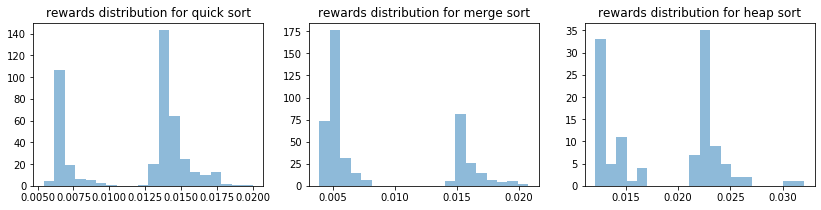

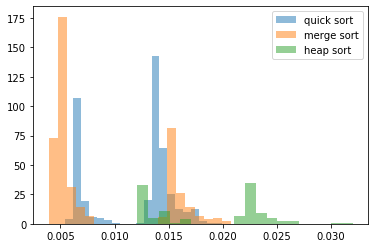

In [24]:
plot_rewards_distribution(arm_rewards_1)
plot_rewards_distribution_together(arm_rewards_1)

Restart at iteration: 23
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014436700000078417, 'merge_sort': 0.0158630230768652, 'heap_sort': 0.02480701666687916}
Count per chosen algo {'quick_sort': 5, 'merge_sort': 13, 'heap_sort': 6}


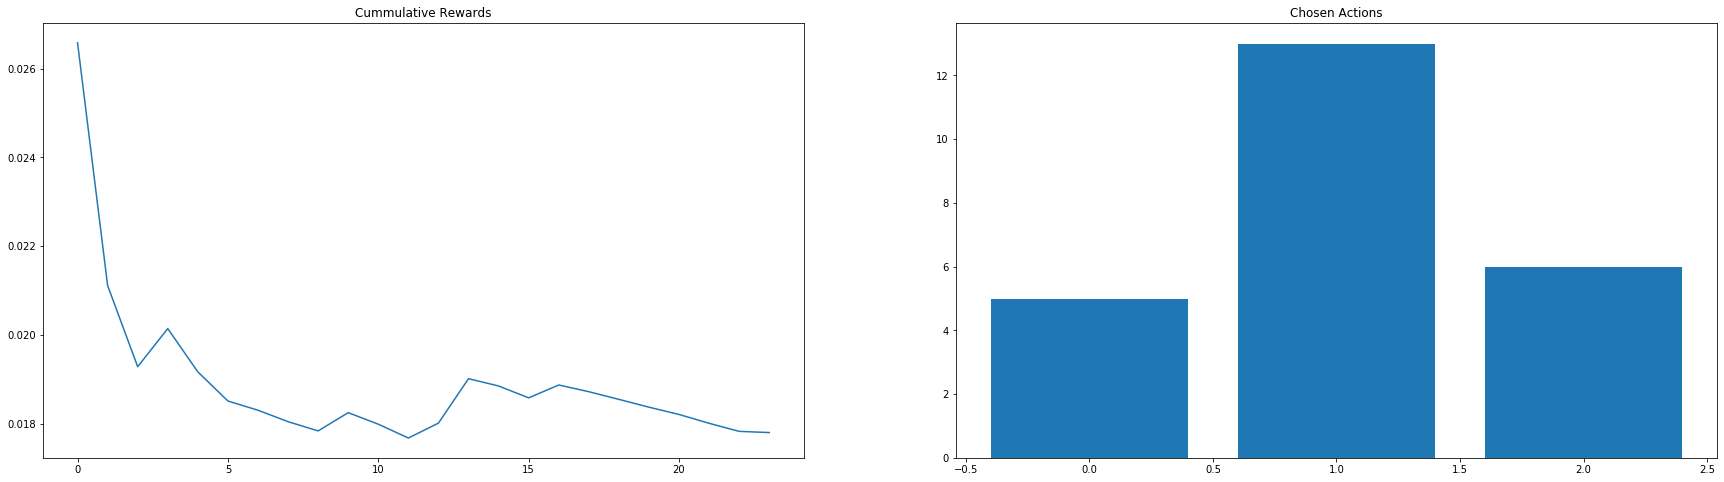

Restart at iteration: 47
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.015423163636362668, 'merge_sort': 0.01611260909075182, 'heap_sort': 0.023564300000089133}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 11, 'heap_sort': 2}


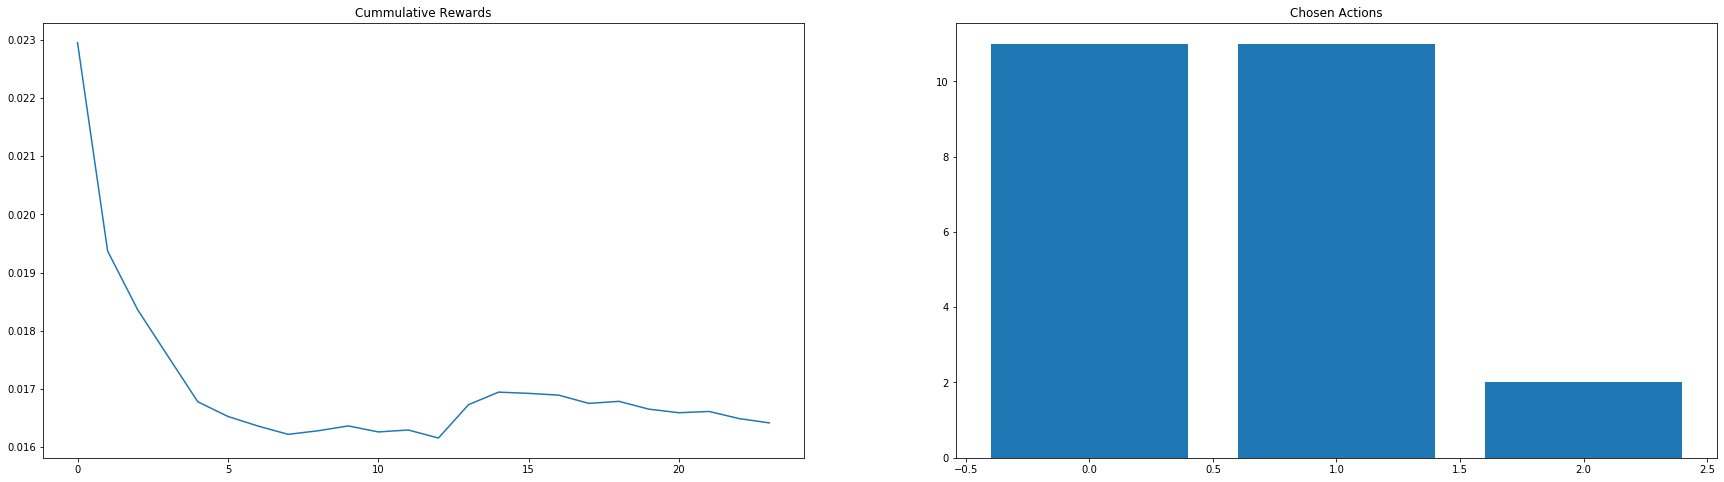

Restart at iteration: 91
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014495722727174738, 'merge_sort': 0.01630102222230158, 'heap_sort': 0.02257862499982366}
Count per chosen algo {'quick_sort': 22, 'merge_sort': 18, 'heap_sort': 4}


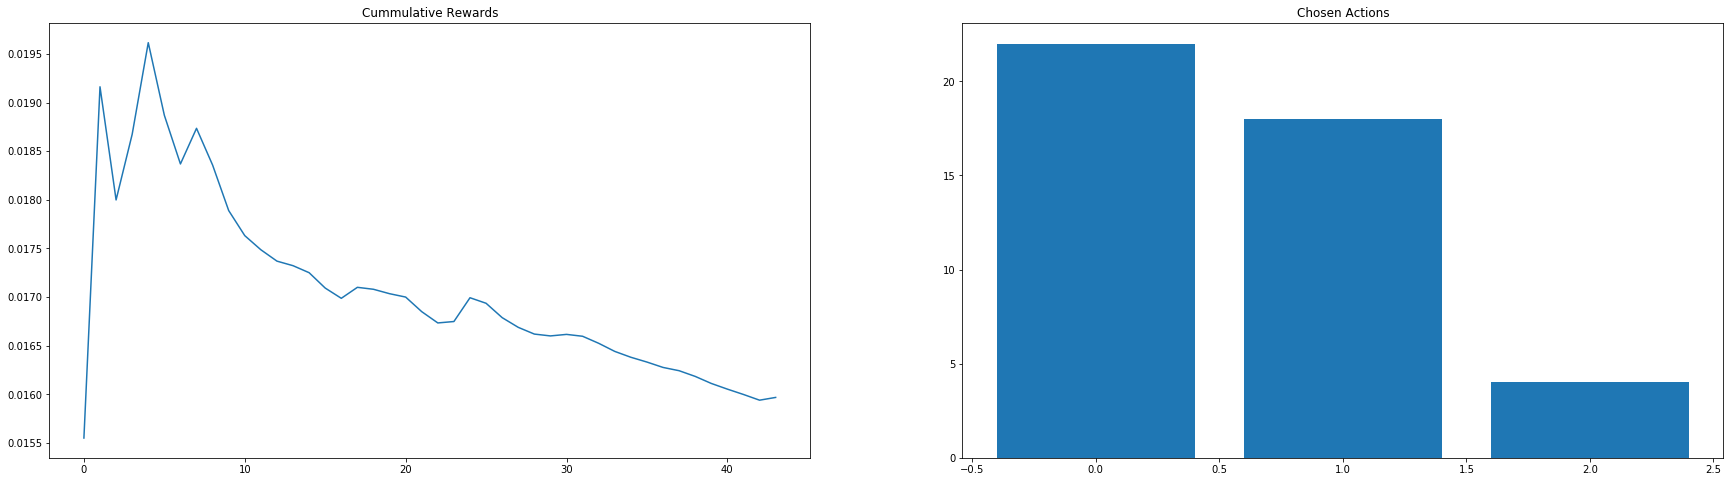

Restart at iteration: 113
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014087559999946582, 'merge_sort': 0.015788400000019465, 'heap_sort': 0.022594849999677535}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 5, 'heap_sort': 2}


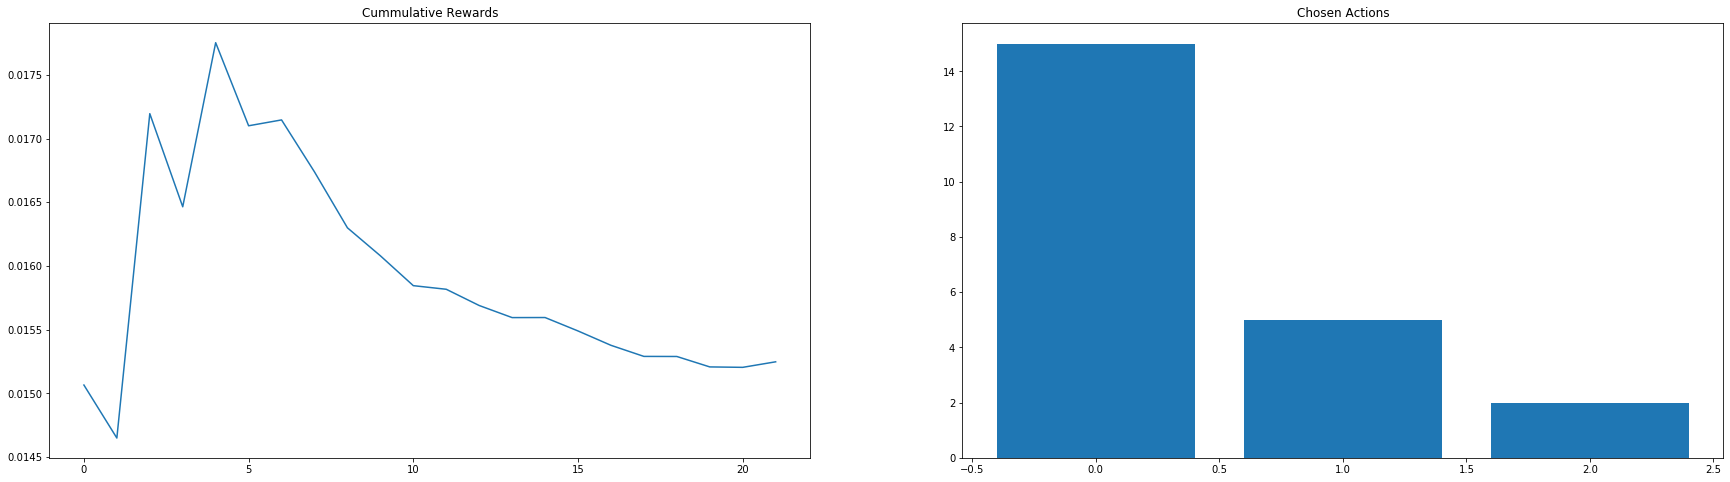

Restart at iteration: 129
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.013706353846128668, 'merge_sort': 0.016104499999528343, 'heap_sort': 0.02234425000006013}
Count per chosen algo {'quick_sort': 13, 'merge_sort': 1, 'heap_sort': 2}


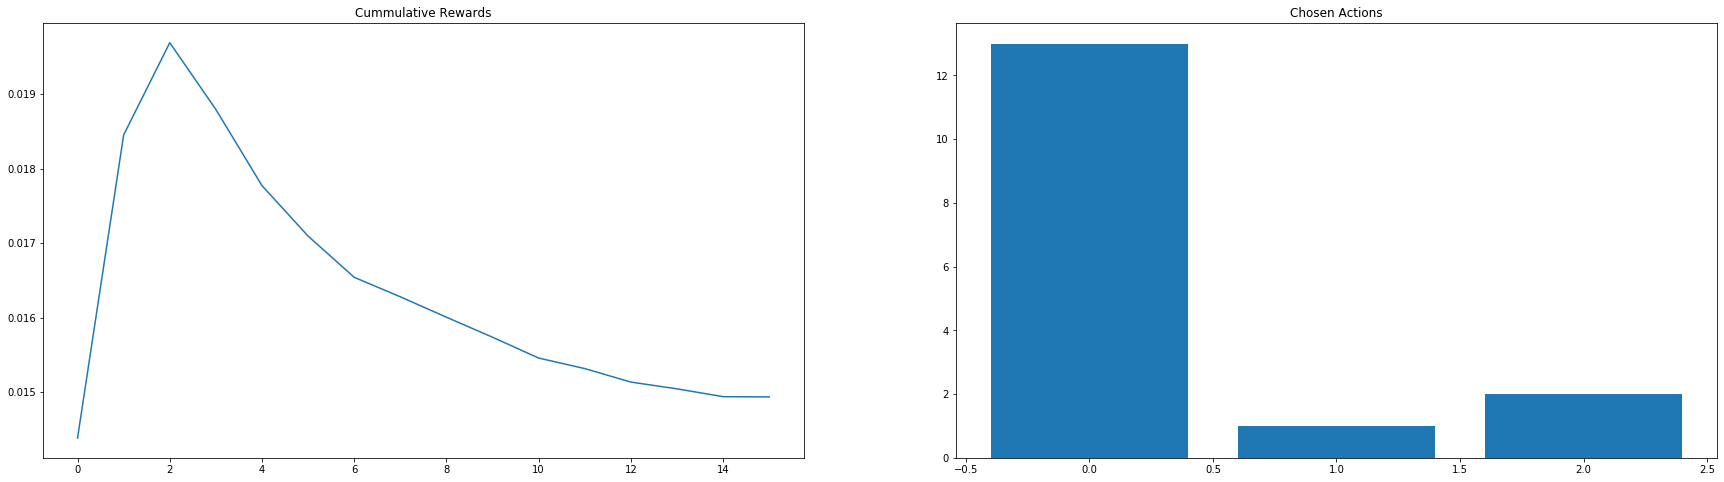

Restart at iteration: 144
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014157133333355887, 'merge_sort': 0.015617199999724107, 'heap_sort': 0.022816449999936594}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 1, 'heap_sort': 2}


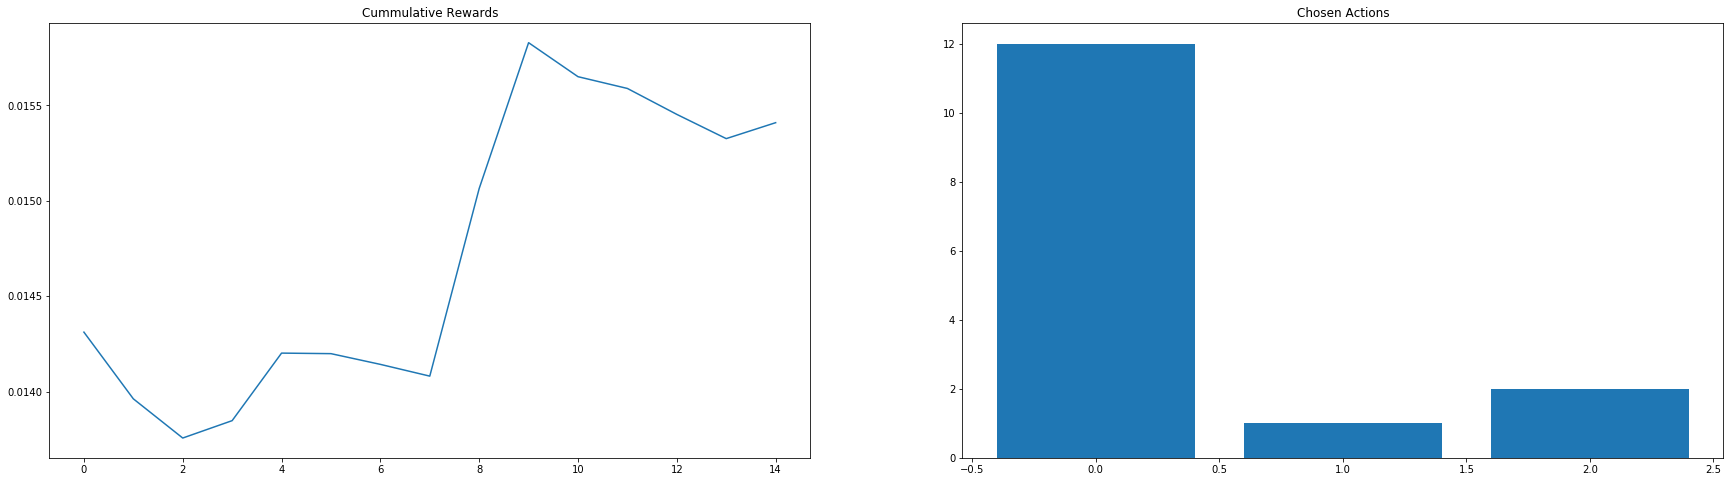

Restart at iteration: 161
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014112618181653406, 'merge_sort': 0.015536600000359613, 'heap_sort': 0.0228258999998161}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 2, 'heap_sort': 4}


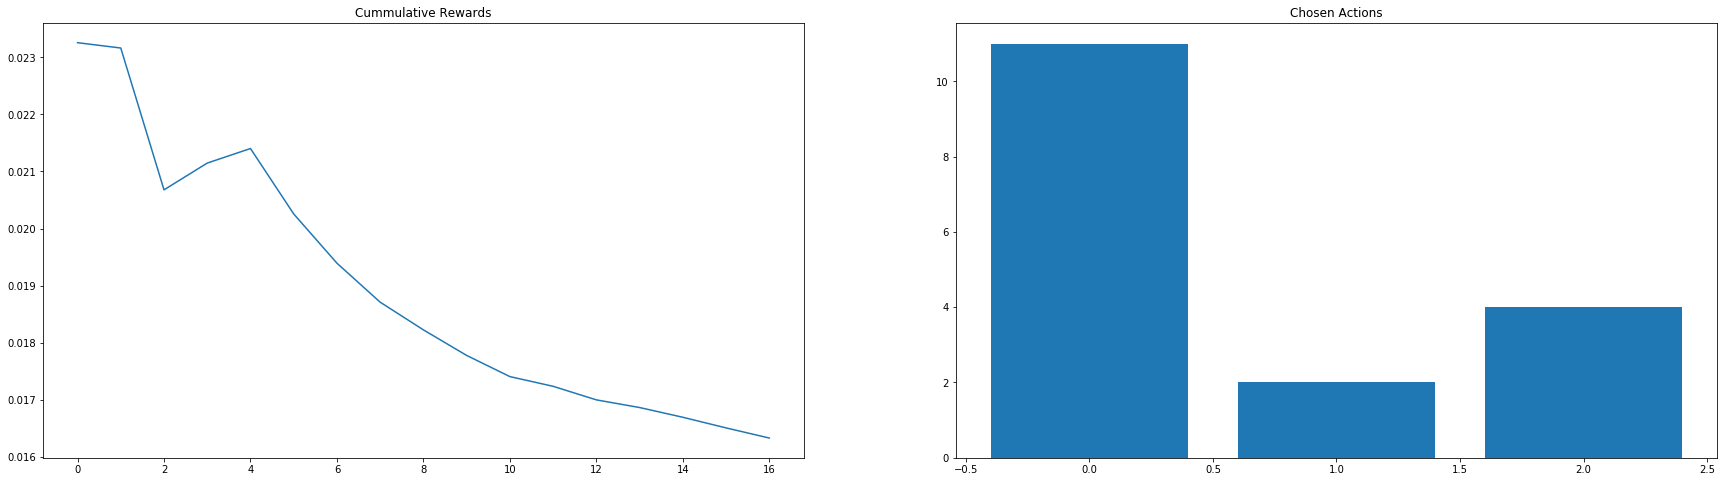

Restart at iteration: 186
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01432677272722768, 'merge_sort': 0.015402785714416365, 'heap_sort': 0.023284100000117696}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 7, 'heap_sort': 7}


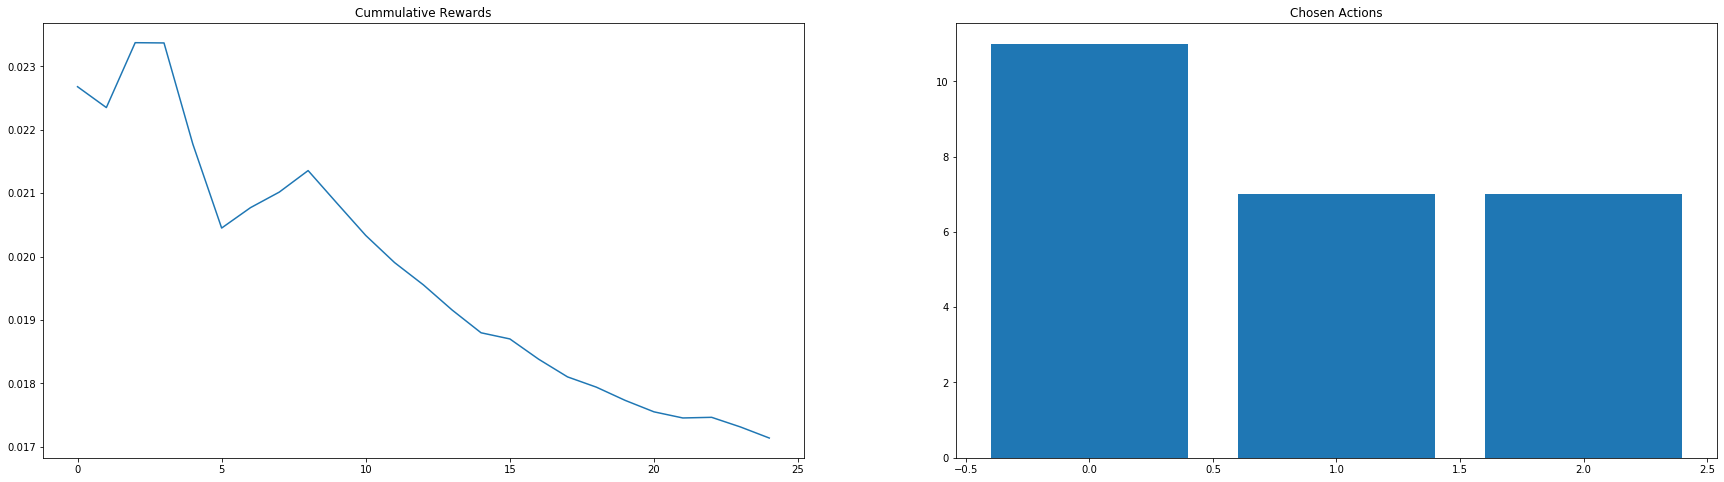

Restart at iteration: 198
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.016020263636412645, 'merge_sort': 0.0, 'heap_sort': 0.03021439999974973}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 0, 'heap_sort': 1}


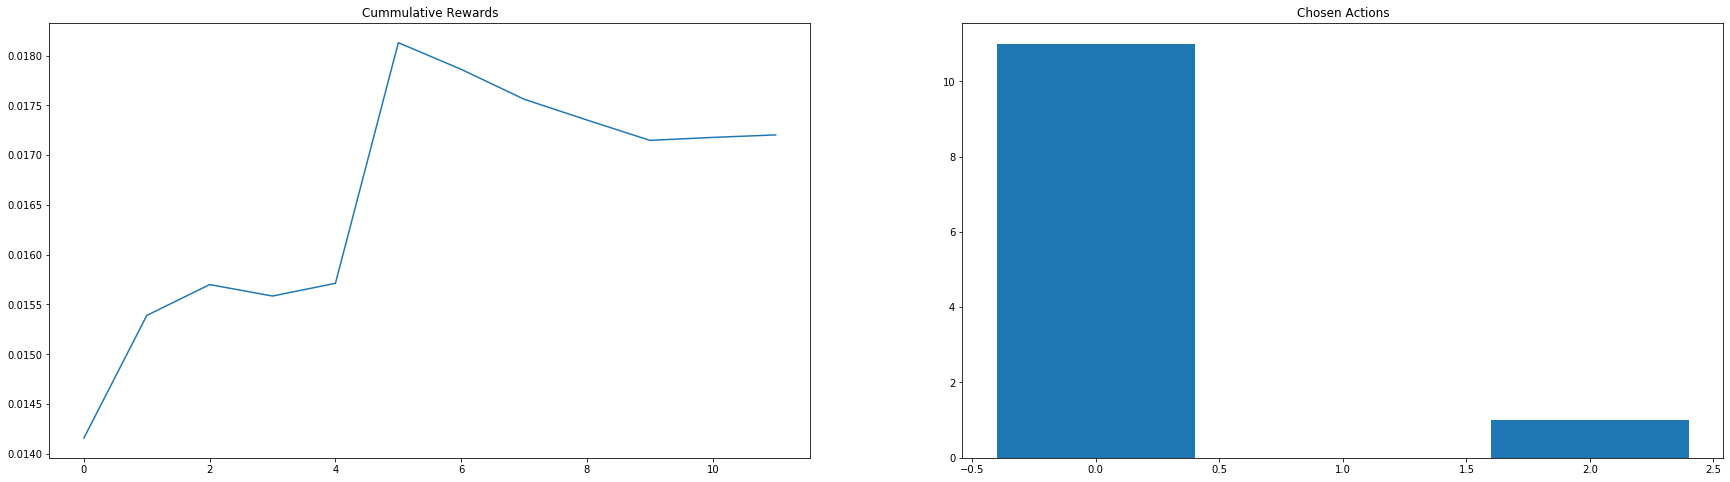

Restart at iteration: 214
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.013729924999779541, 'merge_sort': 0.016031845454480474, 'heap_sort': 0.022535800000696327}
Count per chosen algo {'quick_sort': 4, 'merge_sort': 11, 'heap_sort': 1}


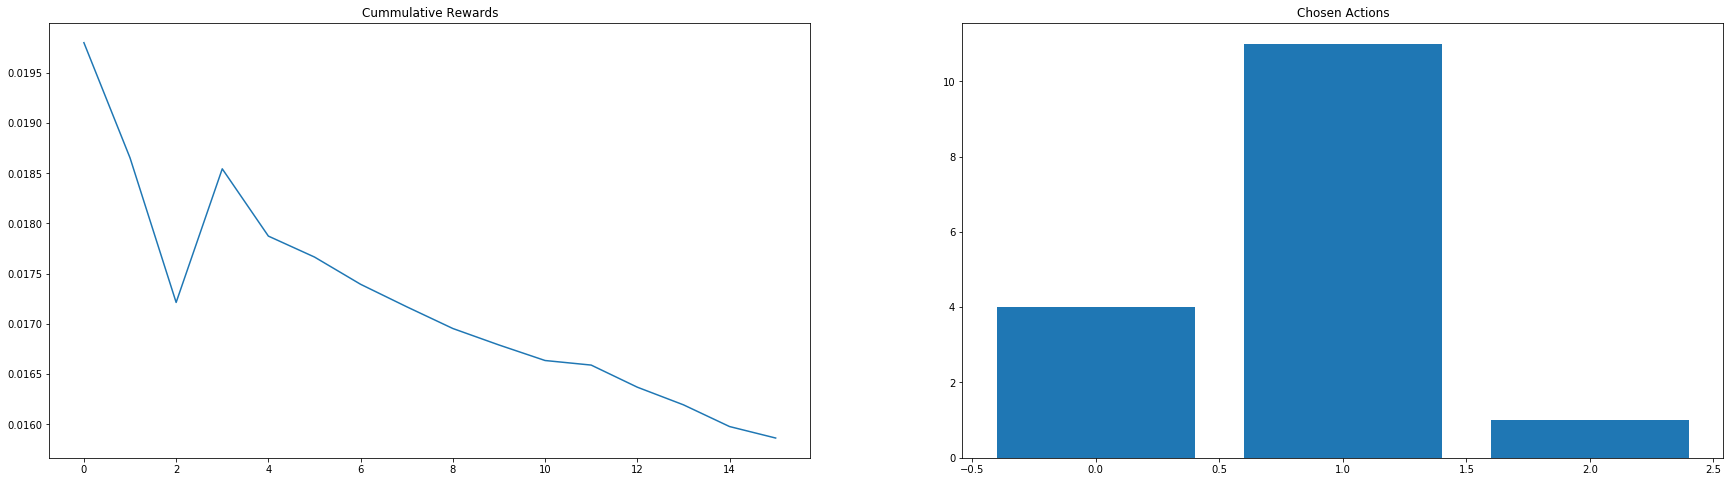

Restart at iteration: 238
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014500265000060608, 'merge_sort': 0.0, 'heap_sort': 0.02300839999998061}
Count per chosen algo {'quick_sort': 20, 'merge_sort': 0, 'heap_sort': 4}


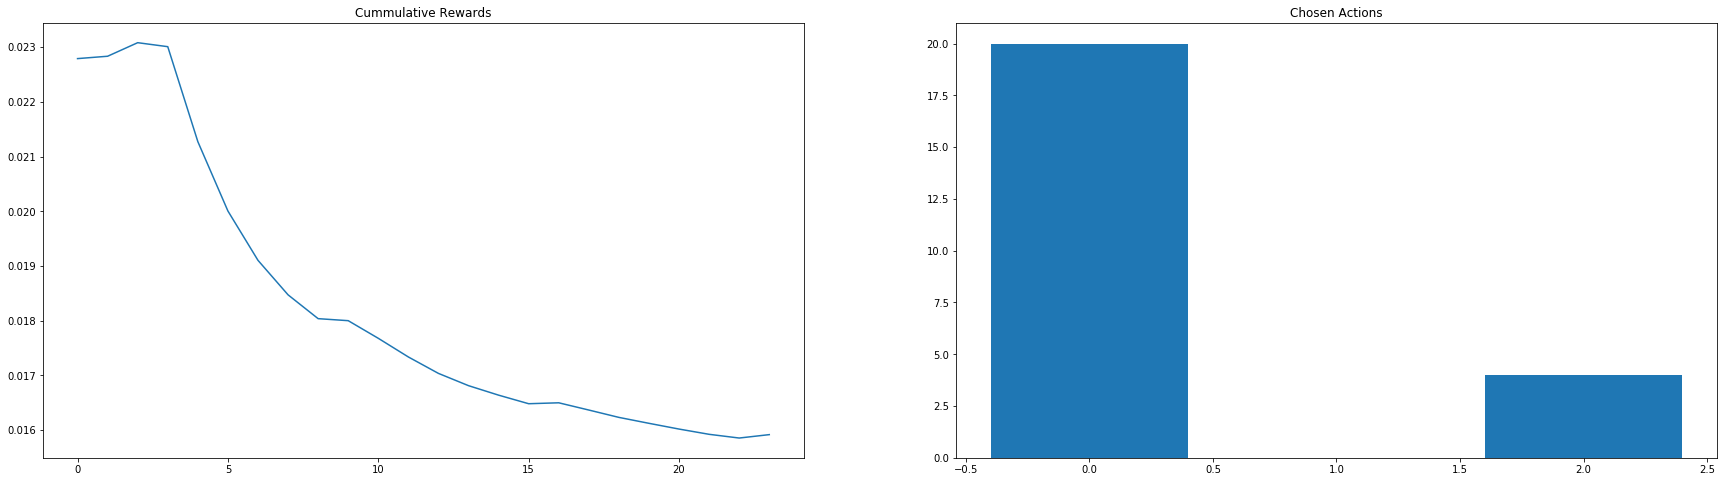

Restart at iteration: 252
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014214481818271452, 'merge_sort': 0.0, 'heap_sort': 0.023212533333510994}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 0, 'heap_sort': 3}


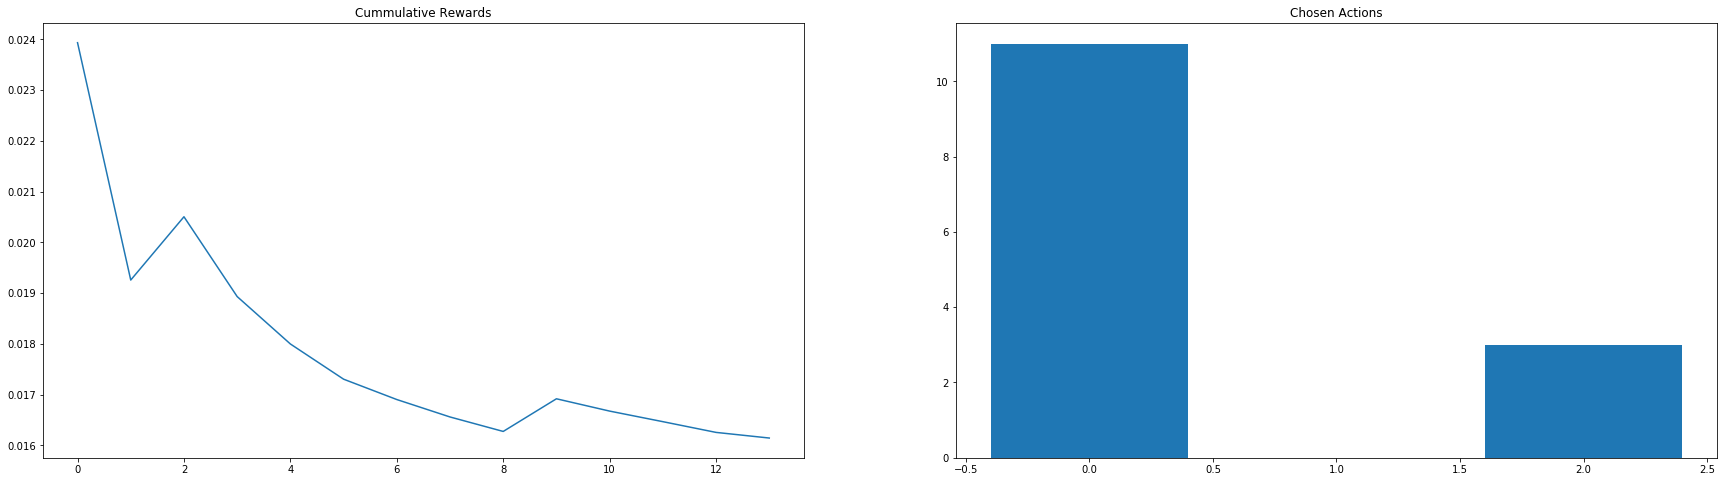

Restart at iteration: 287
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014358548000091105, 'merge_sort': 0.01567348749983921, 'heap_sort': 0.022237499999846477}
Count per chosen algo {'quick_sort': 25, 'merge_sort': 8, 'heap_sort': 2}


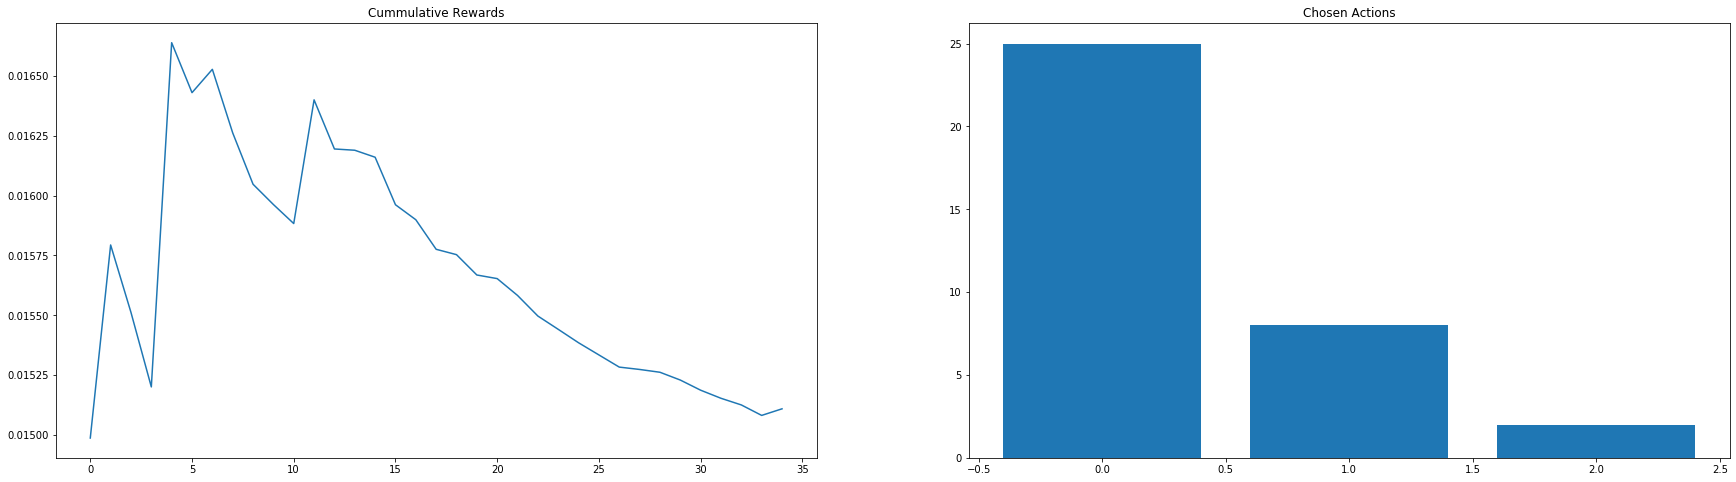

Restart at iteration: 304
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.016239445454547505, 'merge_sort': 0.018960849999757556, 'heap_sort': 0.02563324999937322}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 4, 'heap_sort': 2}


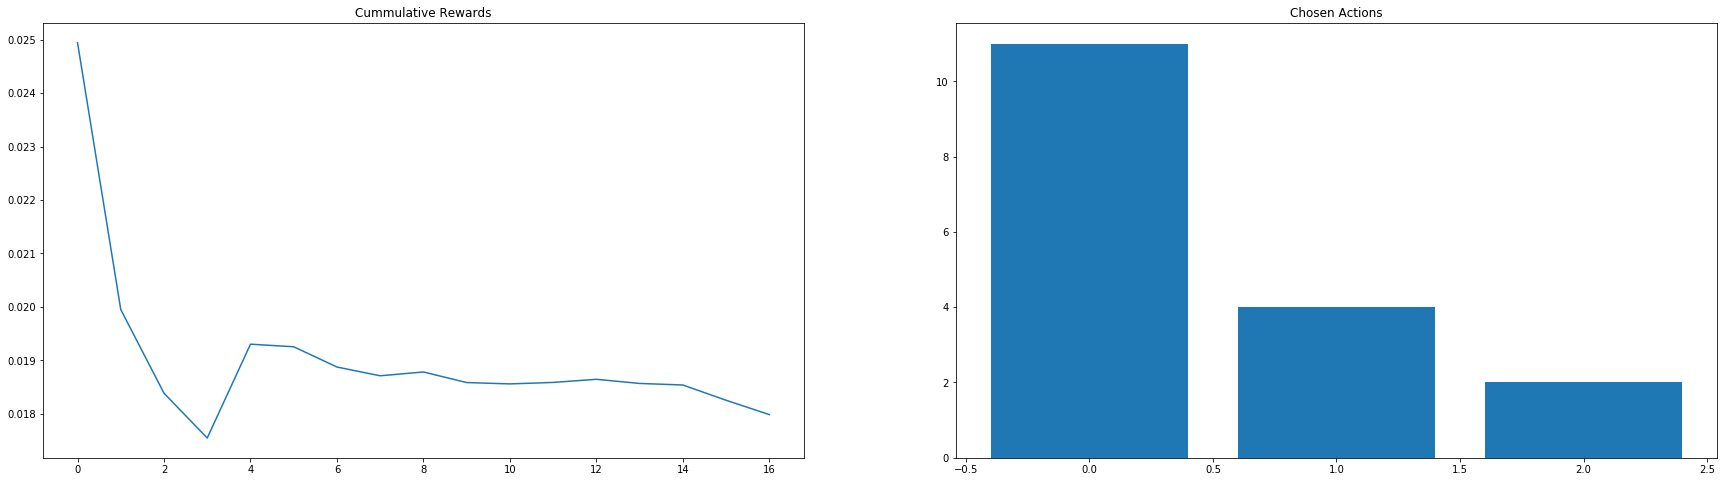

Restart at iteration: 322
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014168238461444651, 'merge_sort': 0.015406633333441278, 'heap_sort': 0.023351500000444503}
Count per chosen algo {'quick_sort': 13, 'merge_sort': 3, 'heap_sort': 2}


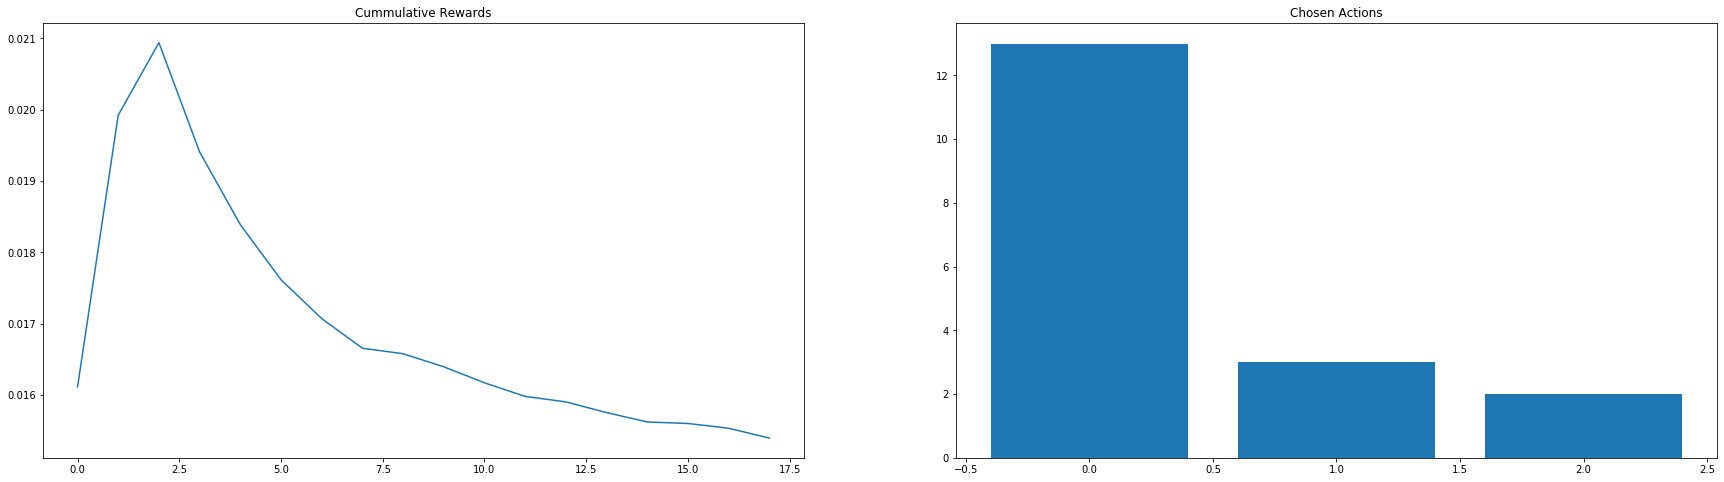

Restart at iteration: 349
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01436673999996856, 'merge_sort': 0.015420900000071925, 'heap_sort': 0.022680300000047282}
Count per chosen algo {'quick_sort': 5, 'merge_sort': 20, 'heap_sort': 2}


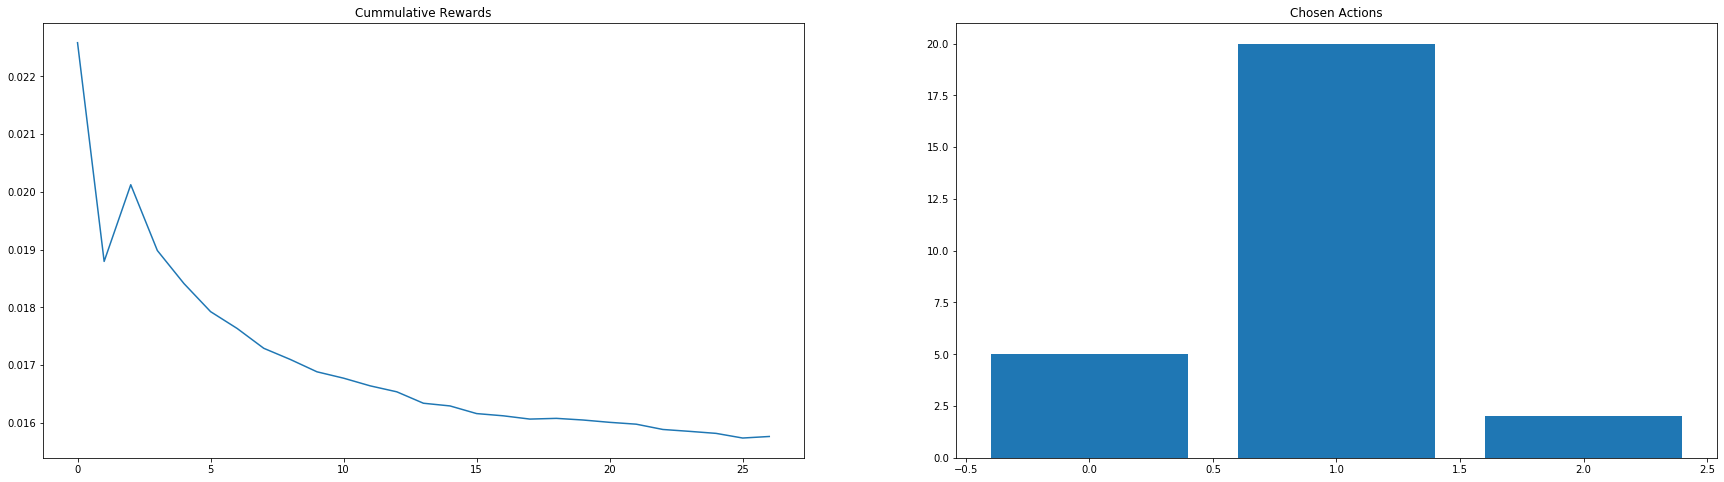

Restart at iteration: 378
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014283161111153377, 'merge_sort': 0.015805512500151053, 'heap_sort': 0.023231266666698502}
Count per chosen algo {'quick_sort': 18, 'merge_sort': 8, 'heap_sort': 3}


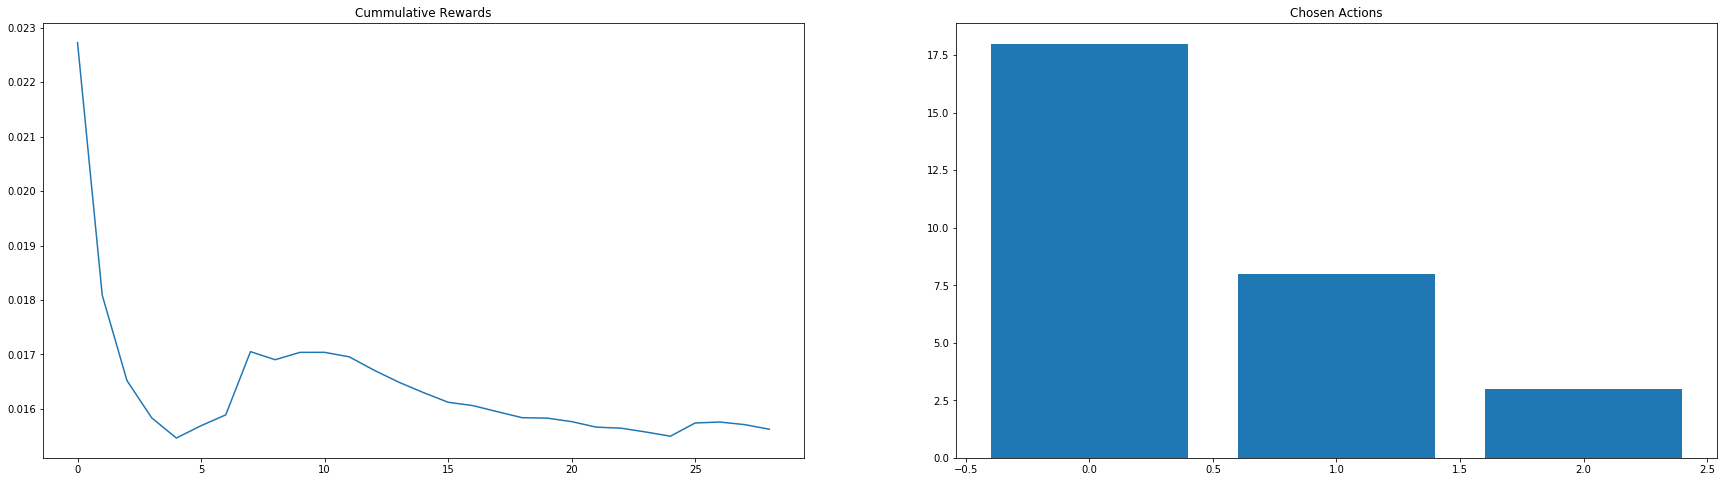

Restart at iteration: 422
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01450759062501561, 'merge_sort': 0.017037988888862148, 'heap_sort': 0.02238463333317971}
Count per chosen algo {'quick_sort': 32, 'merge_sort': 9, 'heap_sort': 3}


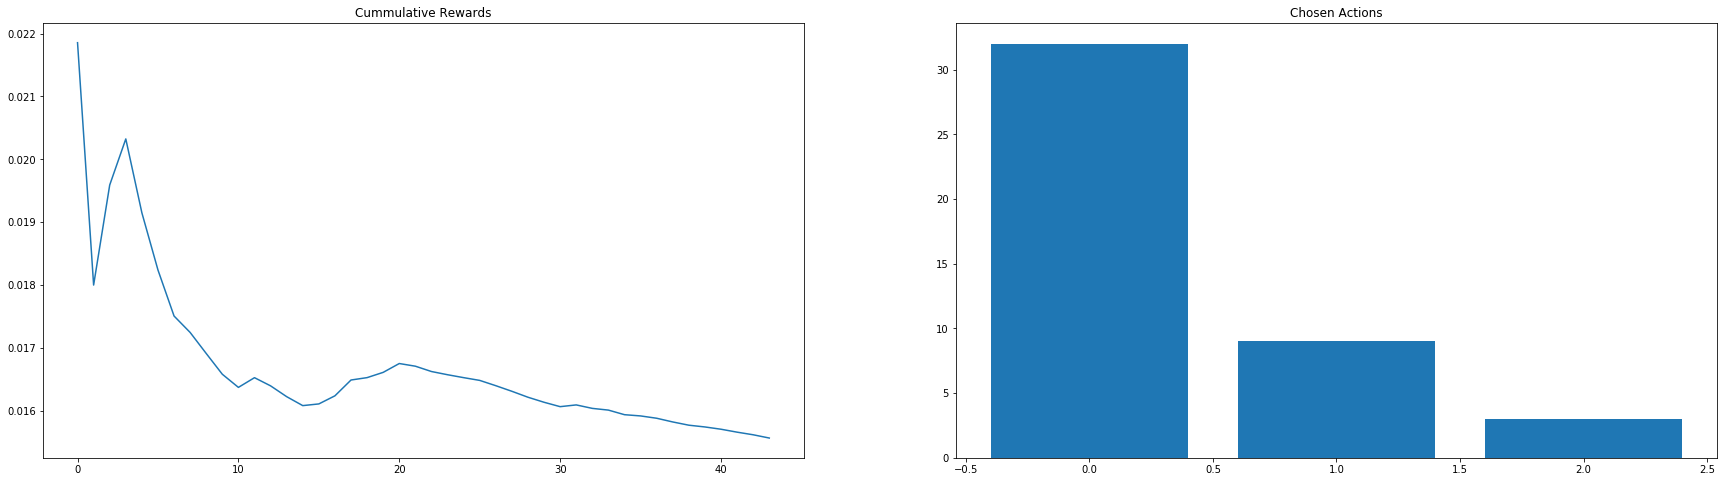

Restart at iteration: 440
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014200186666857916, 'merge_sort': 0.015420700000049692, 'heap_sort': 0.022326799999973446}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 2, 'heap_sort': 1}


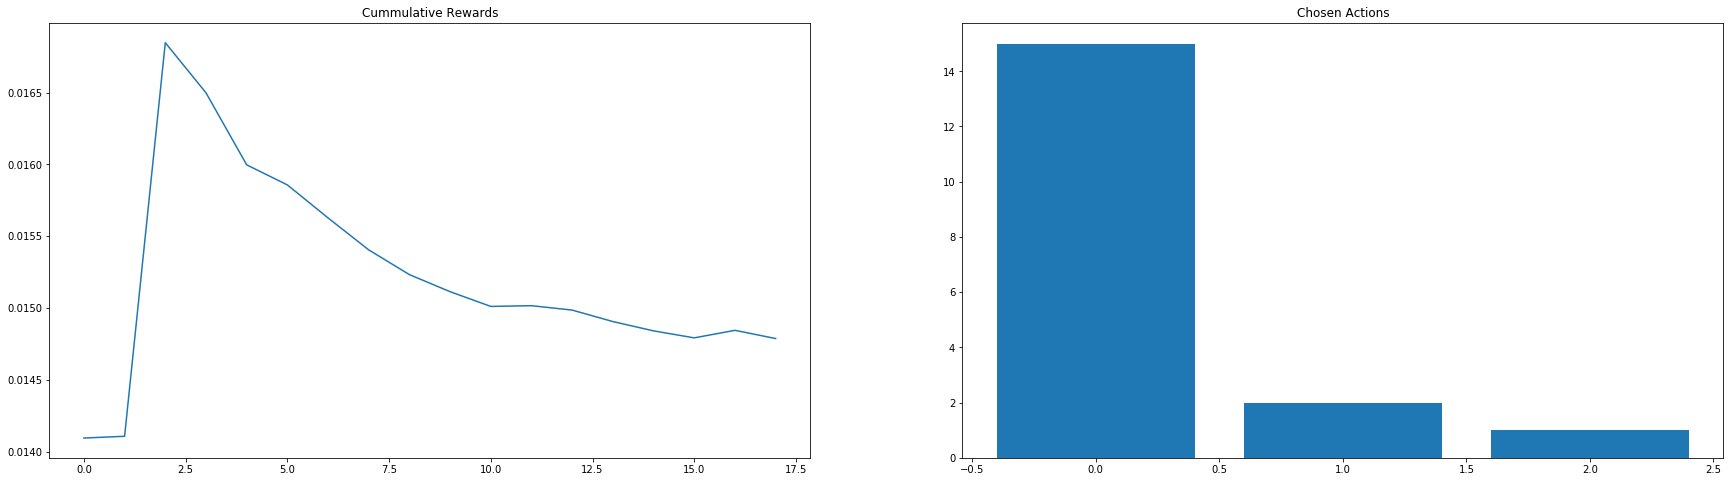

Restart at iteration: 461
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014001233333268222, 'merge_sort': 0.015245233333795719, 'heap_sort': 0.02296836666634287}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 3, 'heap_sort': 3}


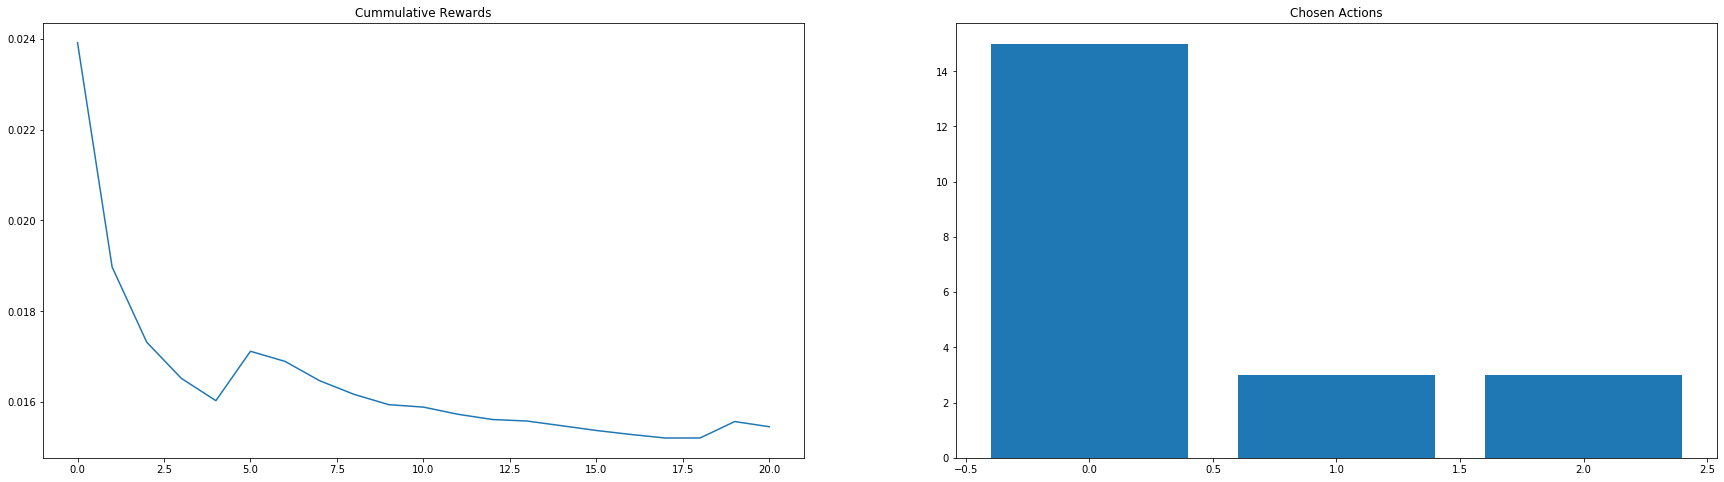

Restart at iteration: 481
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.01392512727257285, 'merge_sort': 0.015198899999631976, 'heap_sort': 0.0230443666669089}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 3, 'heap_sort': 6}


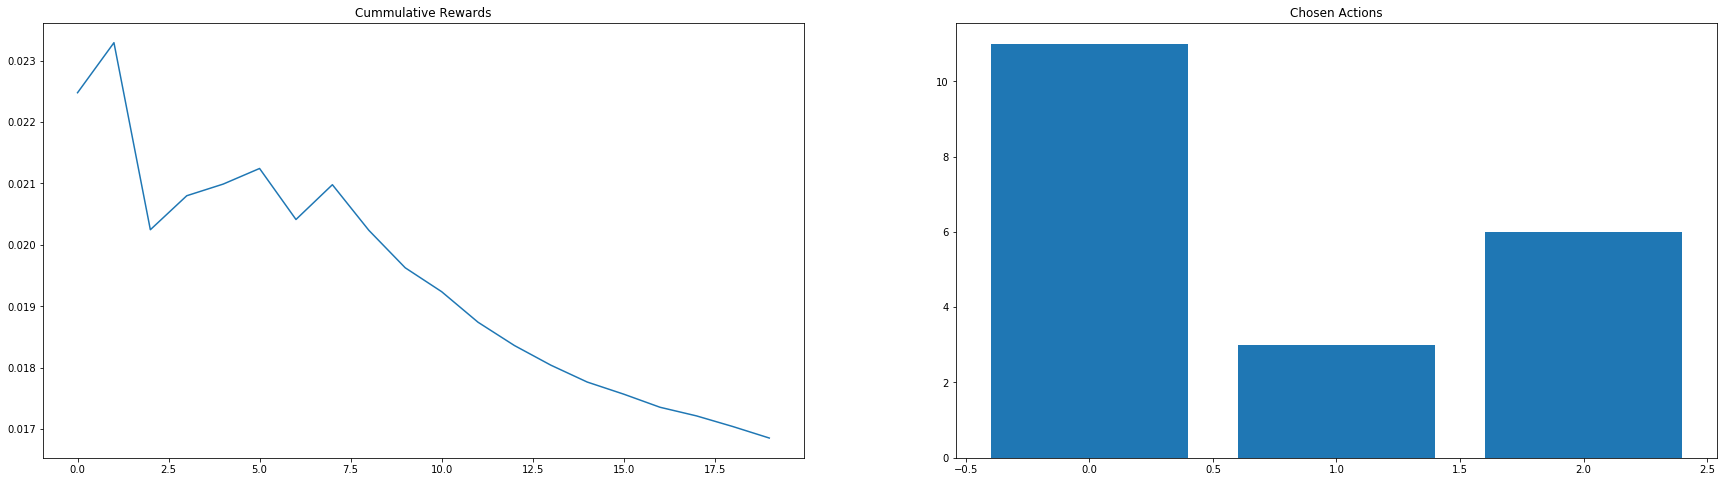

Restart at iteration: 493
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.013572999999269086, 'merge_sort': 0.015700399999745554, 'heap_sort': 0.0}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 11, 'heap_sort': 0}


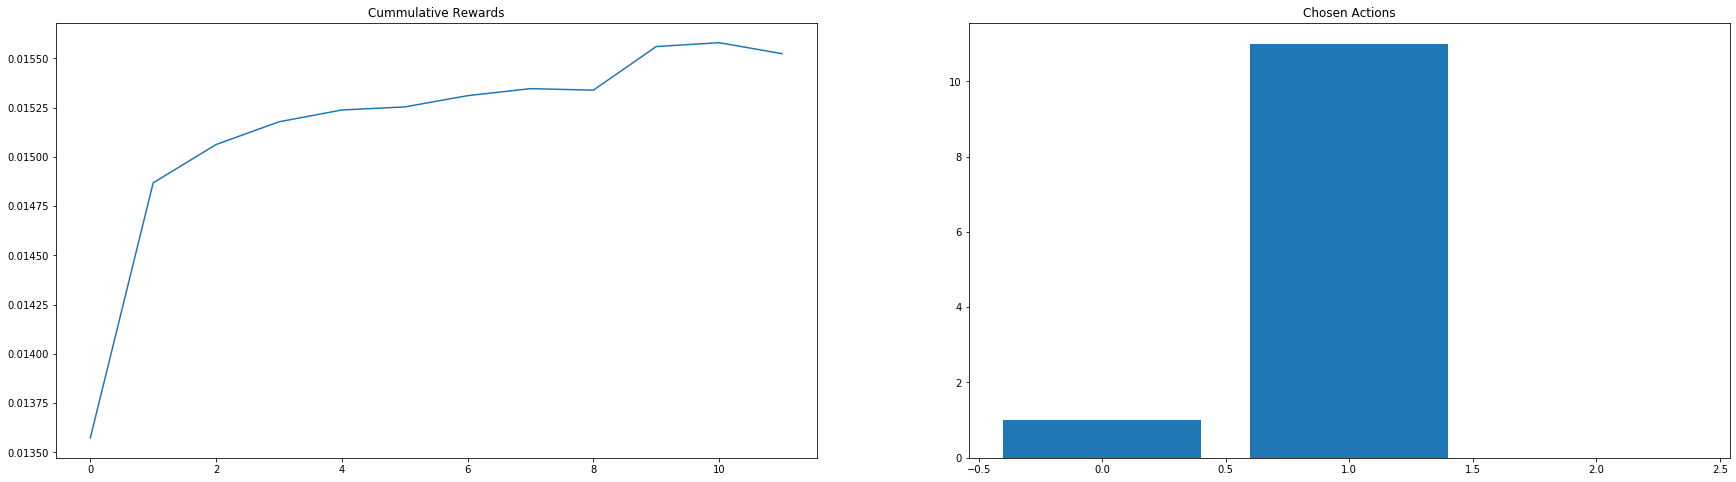

Restart at iteration: 508
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.00982813333333373, 'merge_sort': 0.010422733333295279, 'heap_sort': 0.0}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 12, 'heap_sort': 0}


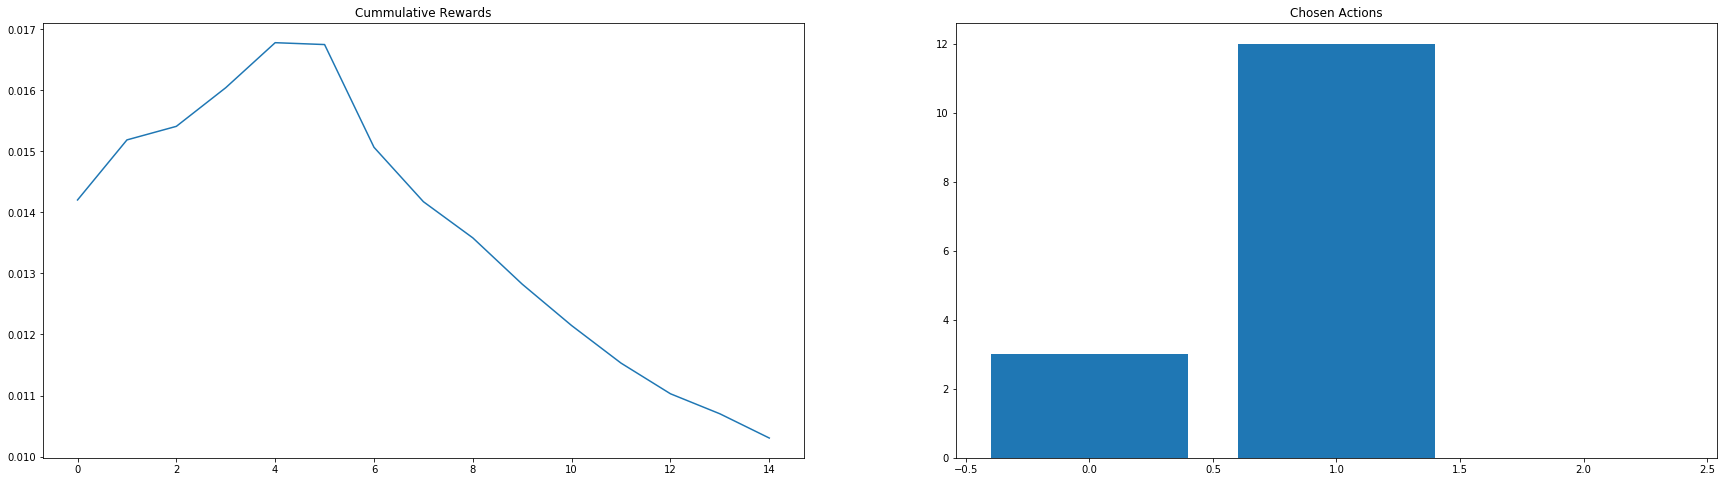

Restart at iteration: 521
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.00653139090925172, 'merge_sort': 0.0, 'heap_sort': 0.012418950000210316}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 0, 'heap_sort': 2}


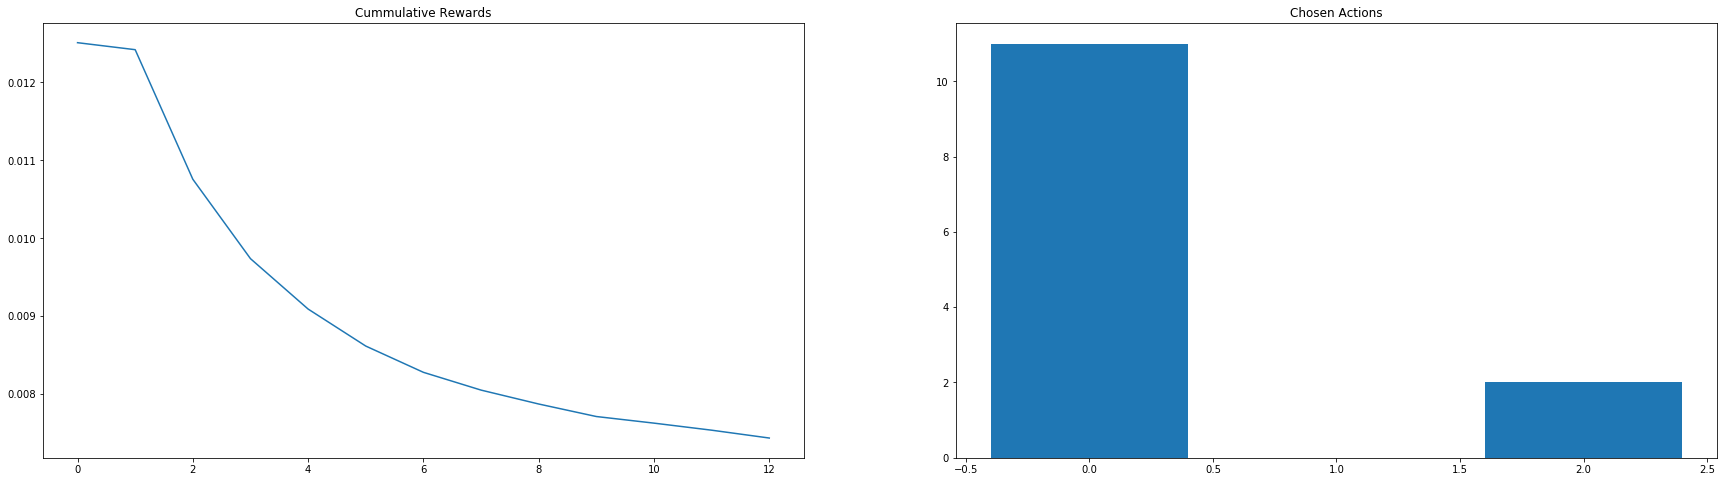

Restart at iteration: 549
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006504799999675015, 'merge_sort': 0.004811199999907826, 'heap_sort': 0.013820150000071862}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 11, 'heap_sort': 16}


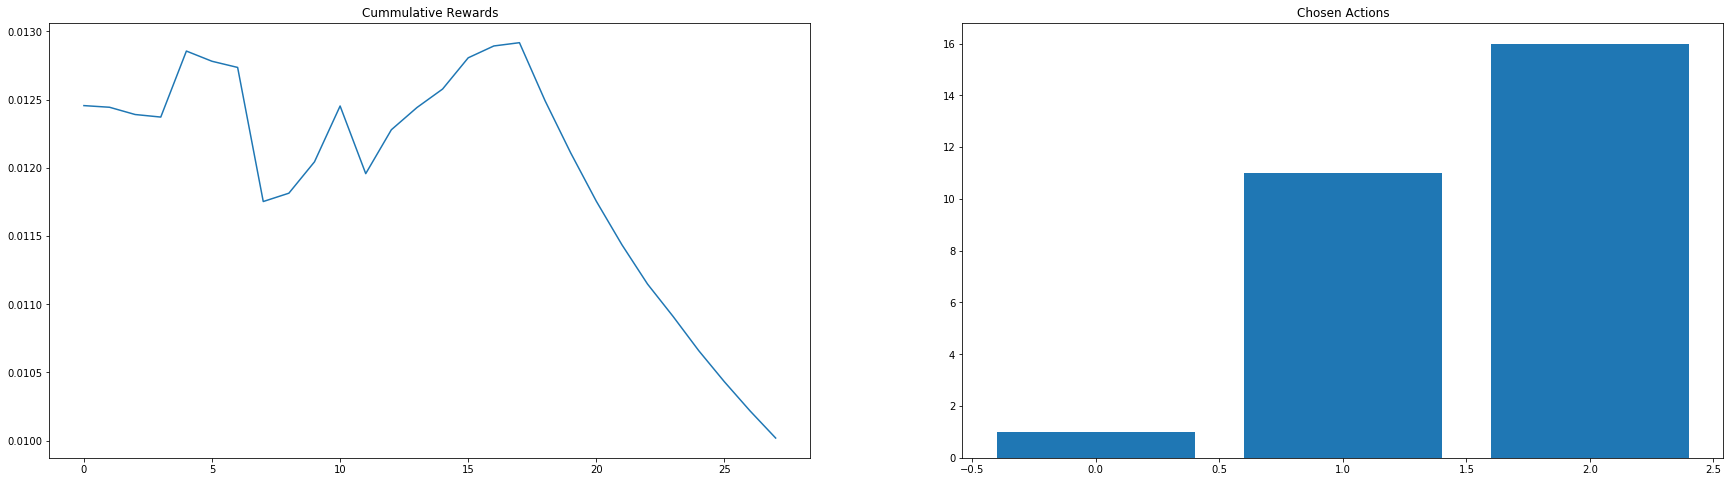

Restart at iteration: 569
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.0050998187500681524, 'heap_sort': 0.013639350000403283}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 16, 'heap_sort': 4}


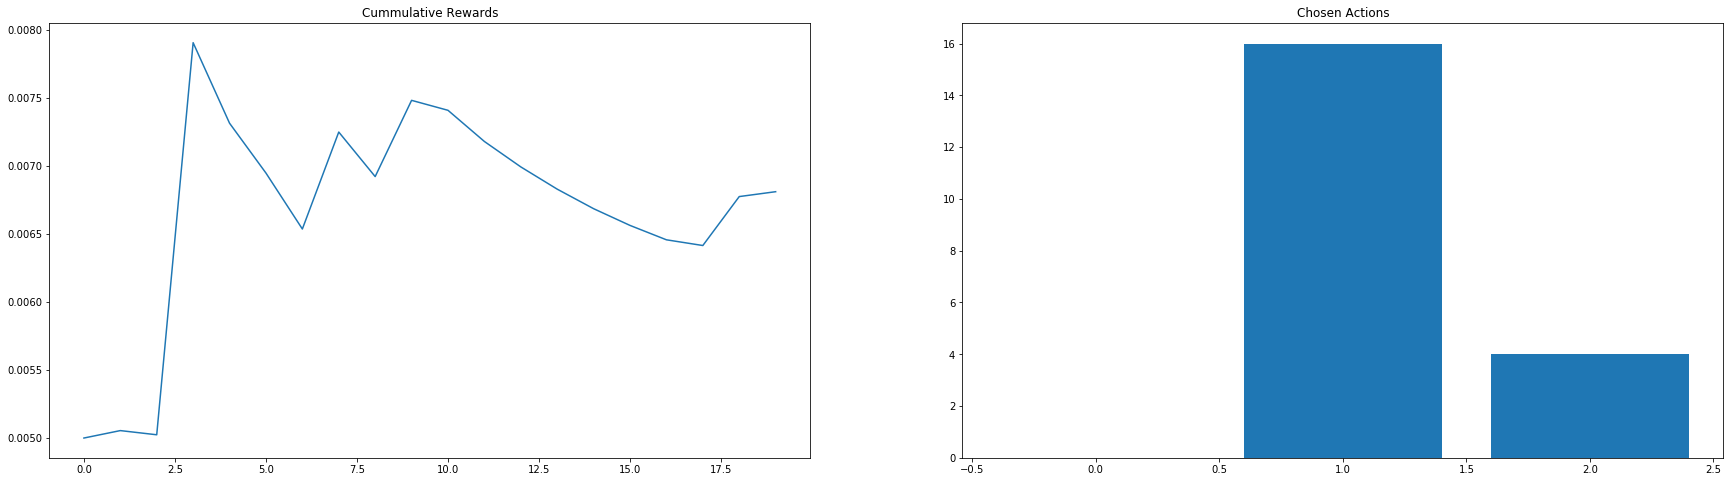

Restart at iteration: 592
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.009626400000342983, 'merge_sort': 0.005229965000080483, 'heap_sort': 0.013493500000095082}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 20, 'heap_sort': 2}


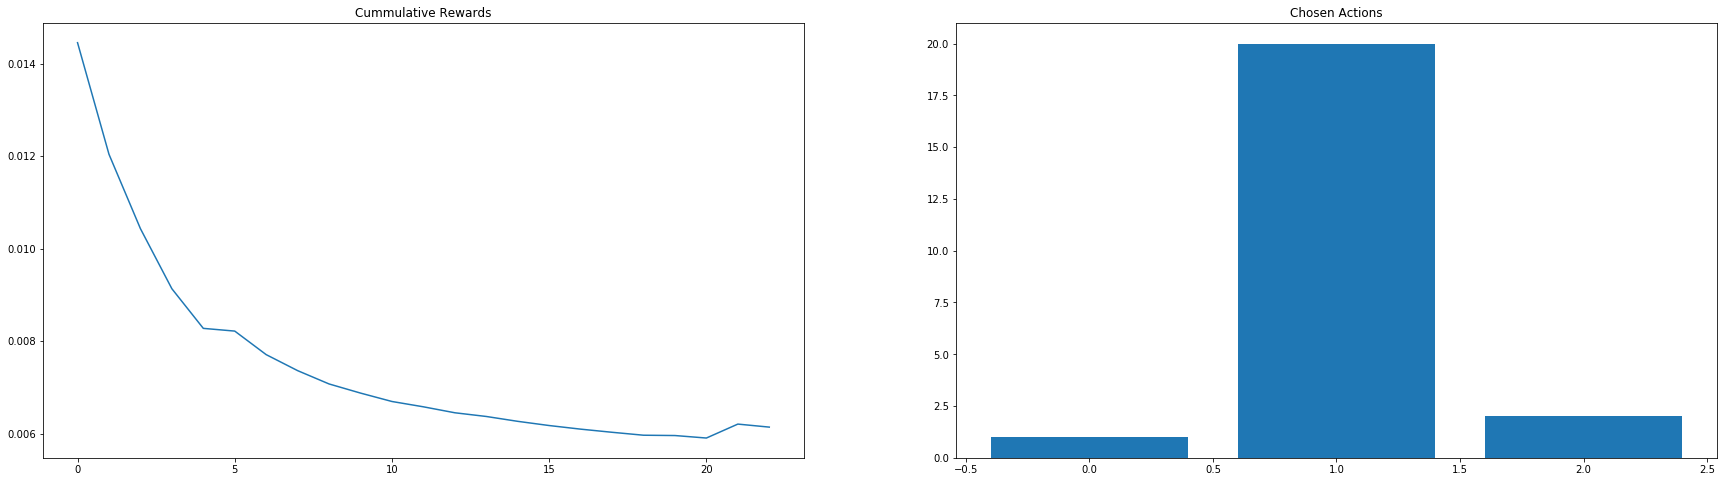

Restart at iteration: 605
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.005138992307645542, 'heap_sort': 0.0}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 13, 'heap_sort': 0}


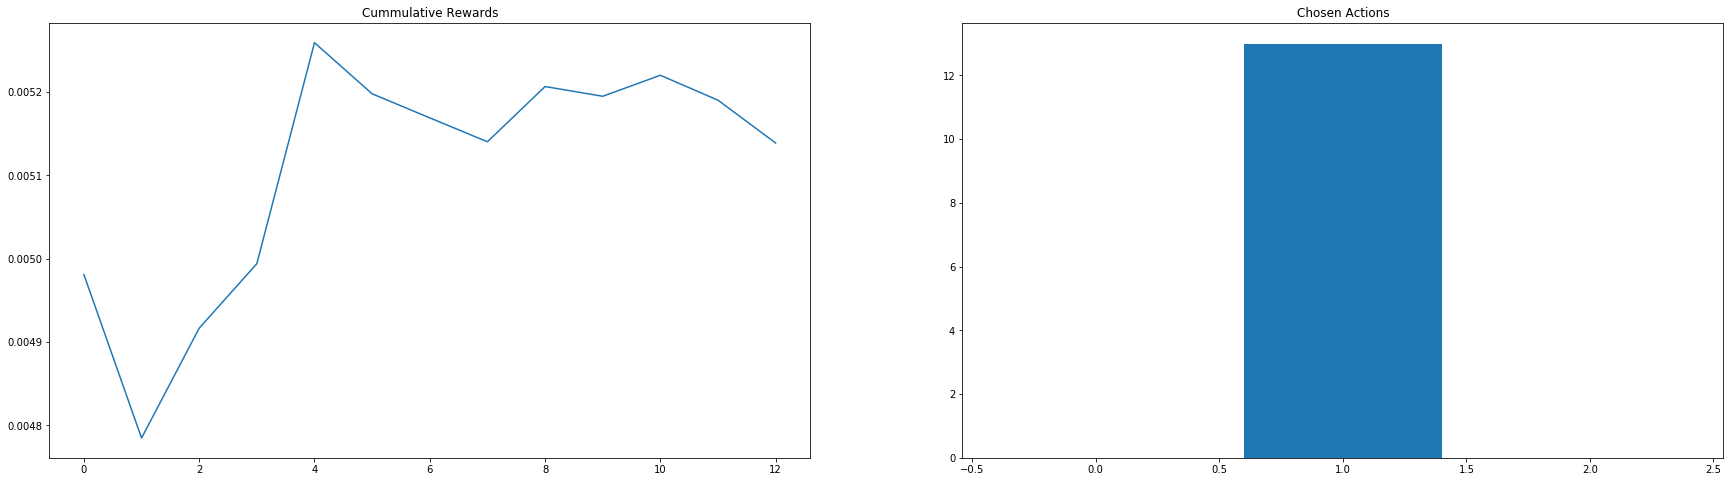

Restart at iteration: 622
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006892524999936238, 'merge_sort': 0.005138599999857736, 'heap_sort': 0.01289470000028814}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 3, 'heap_sort': 2}


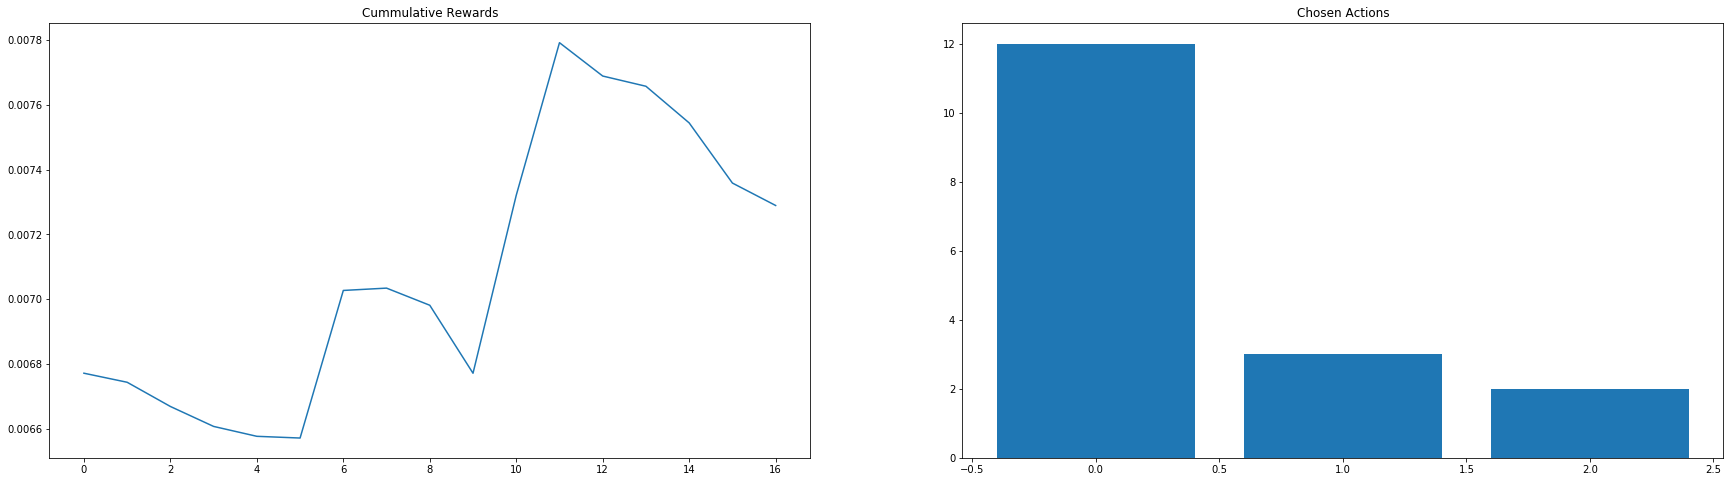

Restart at iteration: 637
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.007018300000254385, 'merge_sort': 0.005400527272616851, 'heap_sort': 0.01518599999963044}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 11, 'heap_sort': 2}


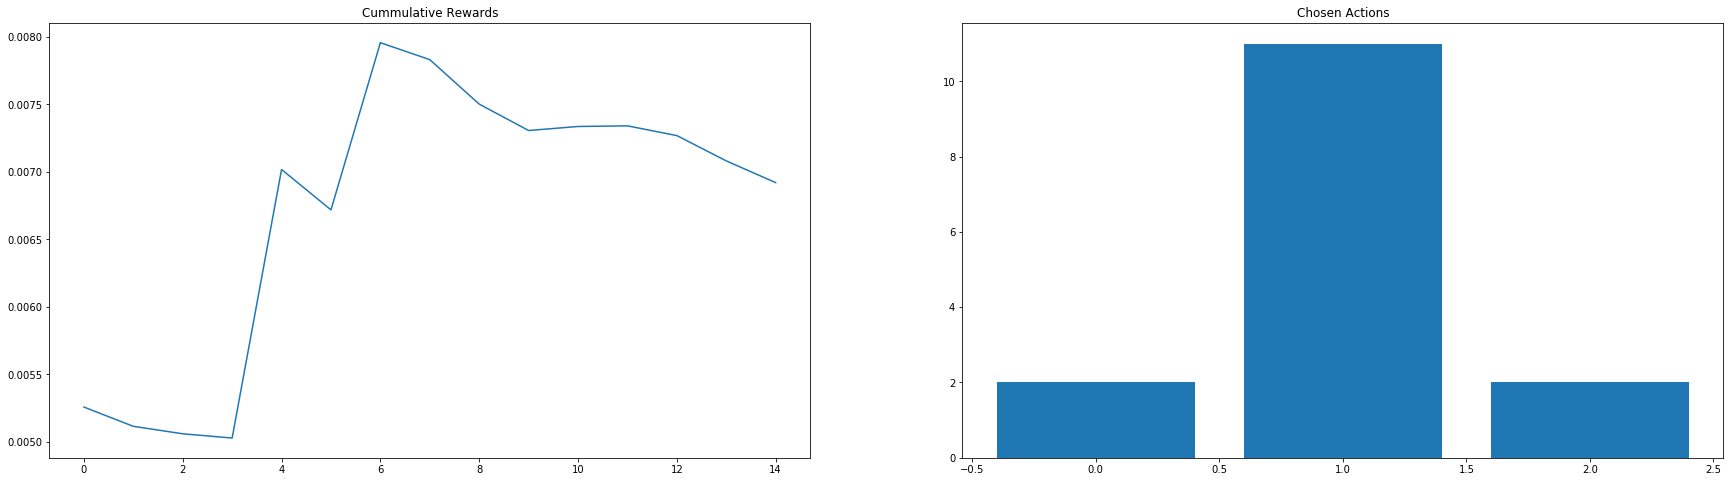

Restart at iteration: 649
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.004925263636406188, 'heap_sort': 0.012274300000171934}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 11, 'heap_sort': 1}


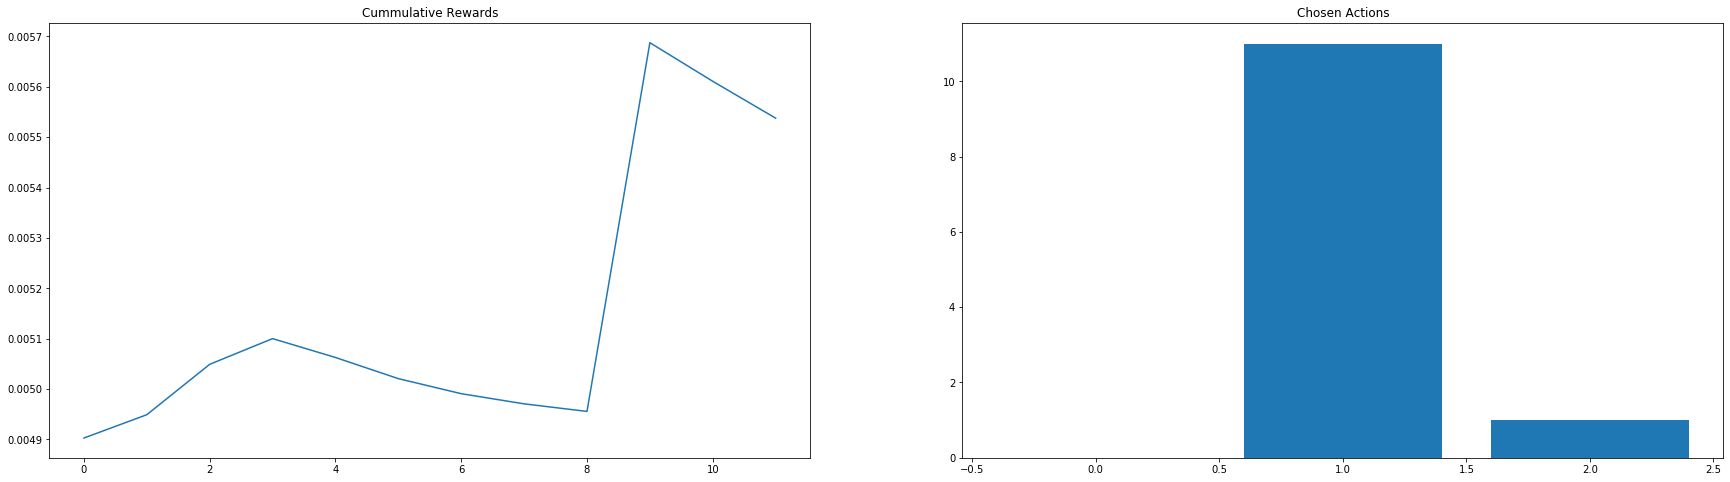

Restart at iteration: 662
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0065686727272226235, 'merge_sort': 0.0050384000005578855, 'heap_sort': 0.012336199999481323}
Count per chosen algo {'quick_sort': 11, 'merge_sort': 1, 'heap_sort': 1}


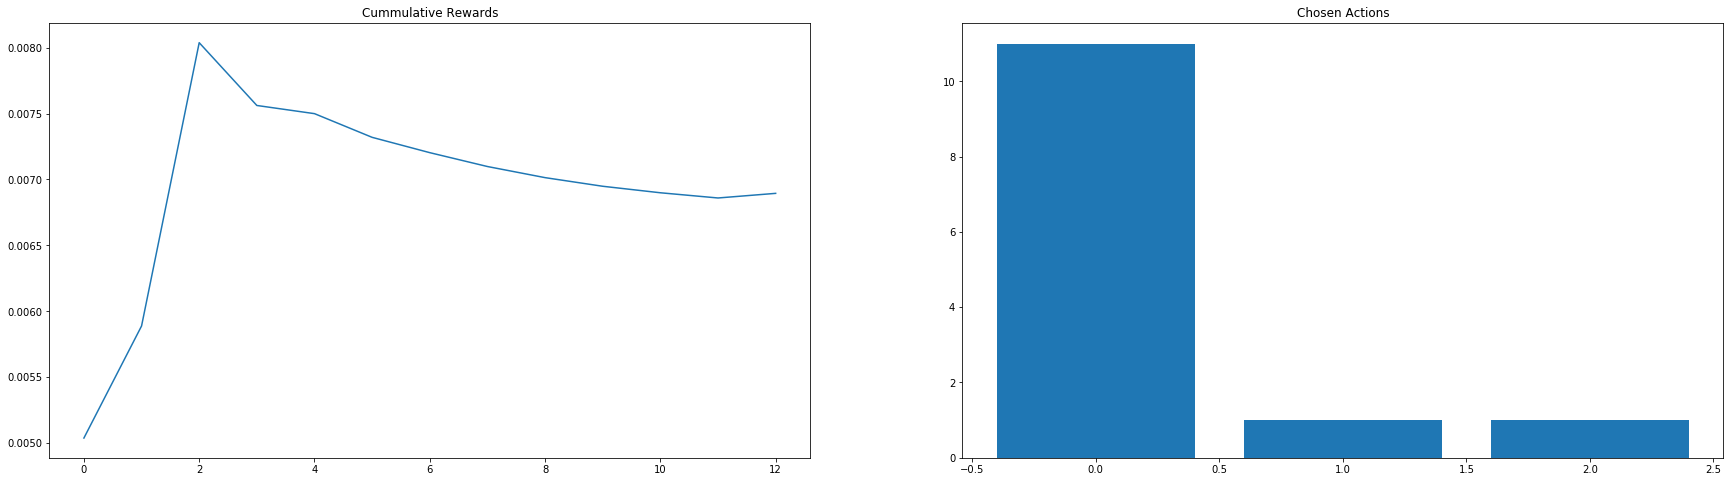

Restart at iteration: 680
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006607839999924181, 'merge_sort': 0.005583399999522953, 'heap_sort': 0.012386849999984406}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 1, 'heap_sort': 2}


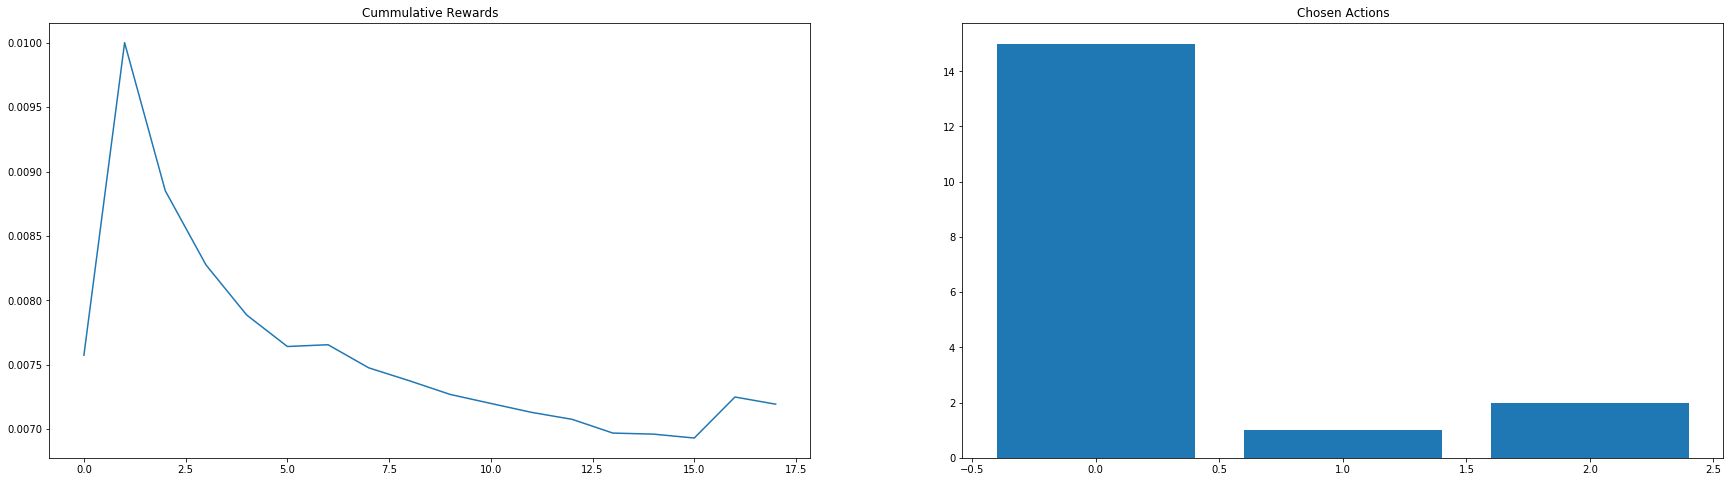

Restart at iteration: 694
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0065636999997877865, 'merge_sort': 0.005022036363698135, 'heap_sort': 0.012946450000072218}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 11, 'heap_sort': 2}


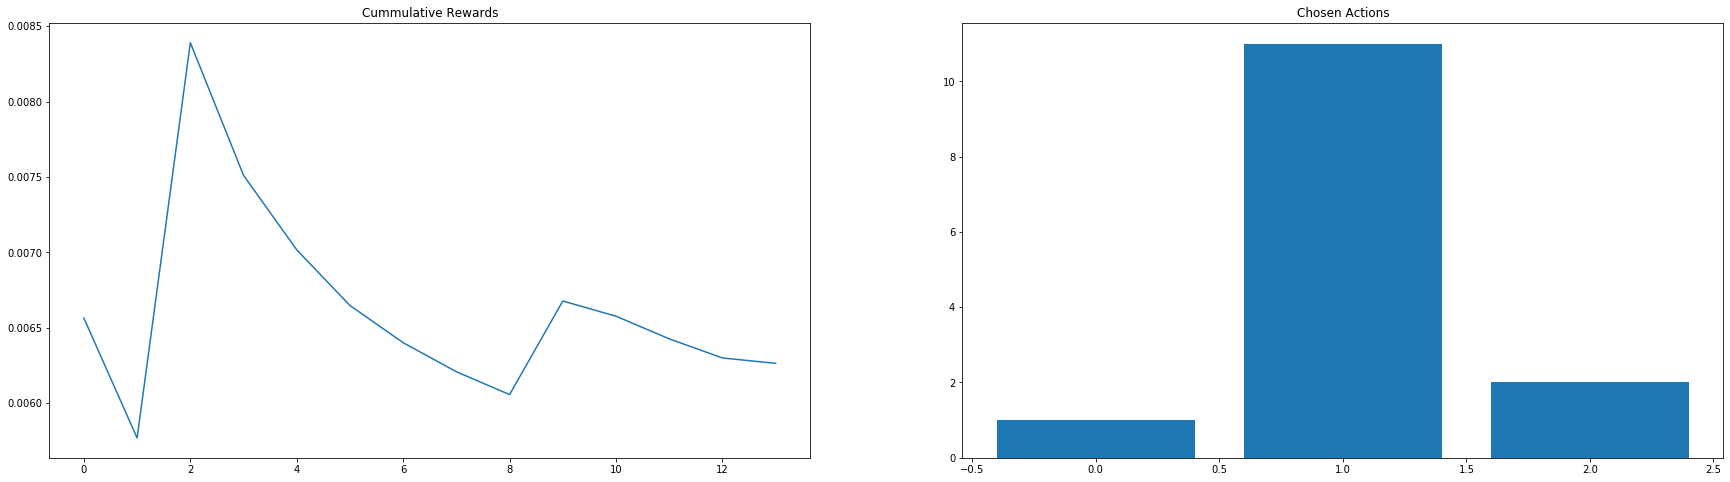

Restart at iteration: 725
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0070094099999550965, 'merge_sort': 0.005049457142766707, 'heap_sort': 0.0}
Count per chosen algo {'quick_sort': 10, 'merge_sort': 21, 'heap_sort': 0}


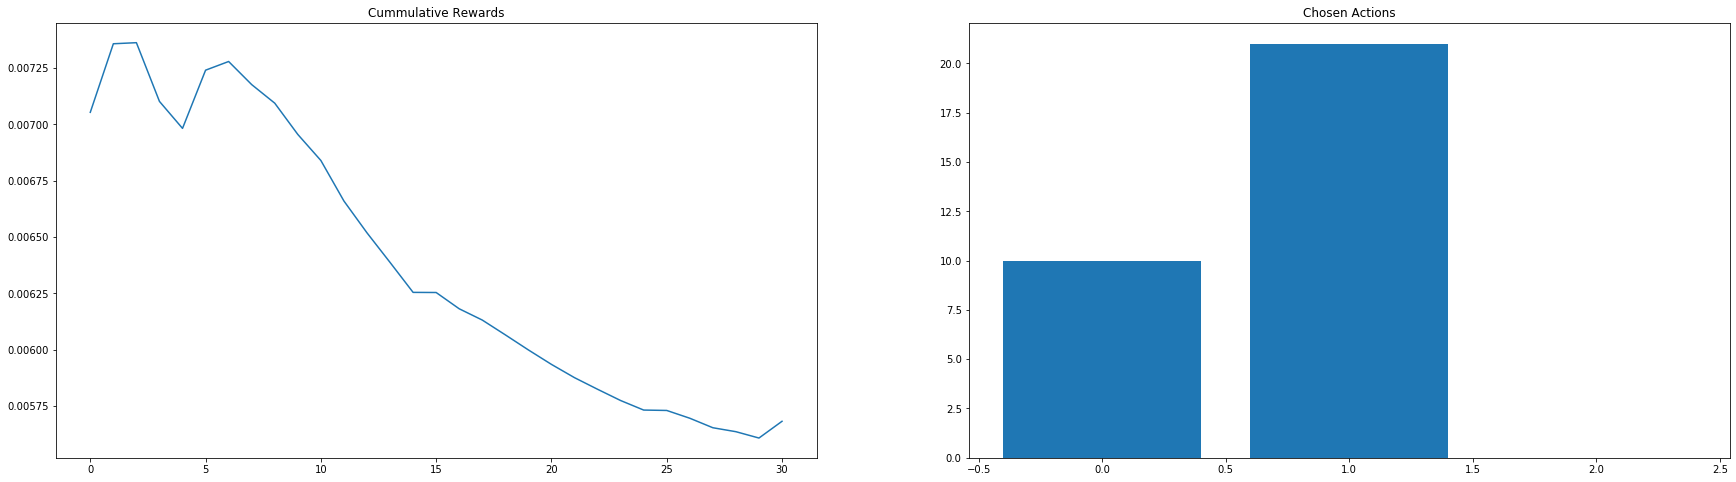

Restart at iteration: 779
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006820399999994082, 'merge_sort': 0.004970286842092862, 'heap_sort': 0.012528233333493214}
Count per chosen algo {'quick_sort': 13, 'merge_sort': 38, 'heap_sort': 3}


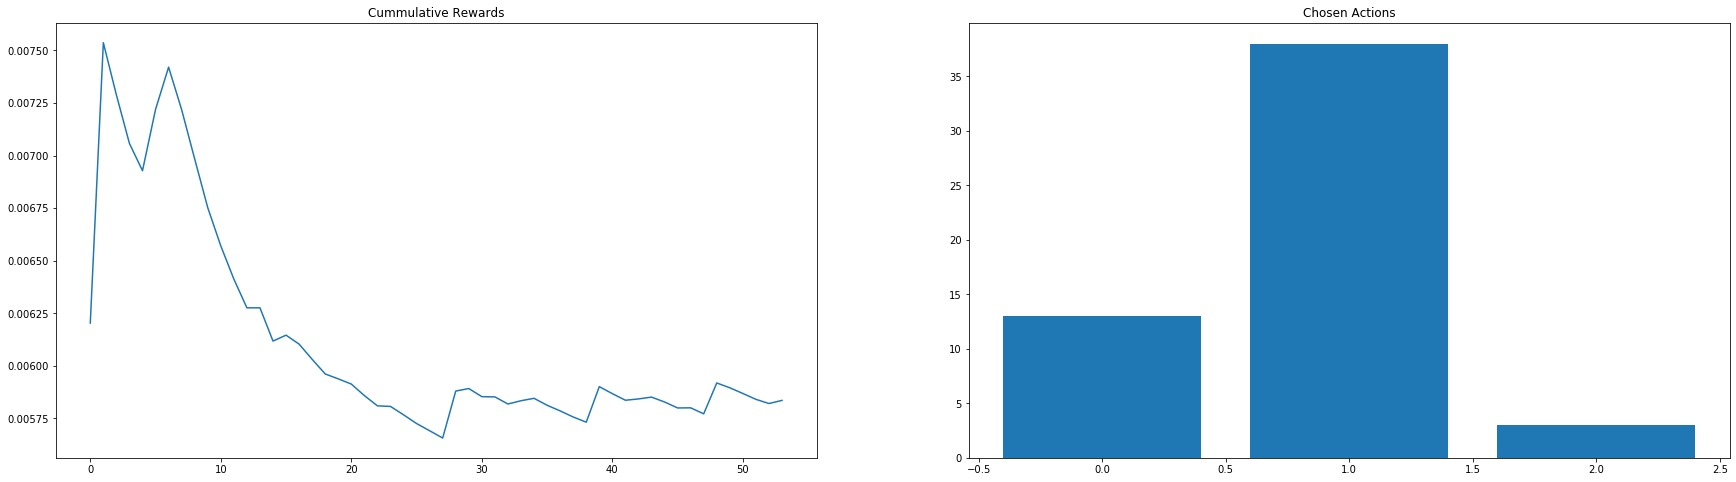

Restart at iteration: 793
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.005356253846072762, 'heap_sort': 0.012794499999472464}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 13, 'heap_sort': 1}


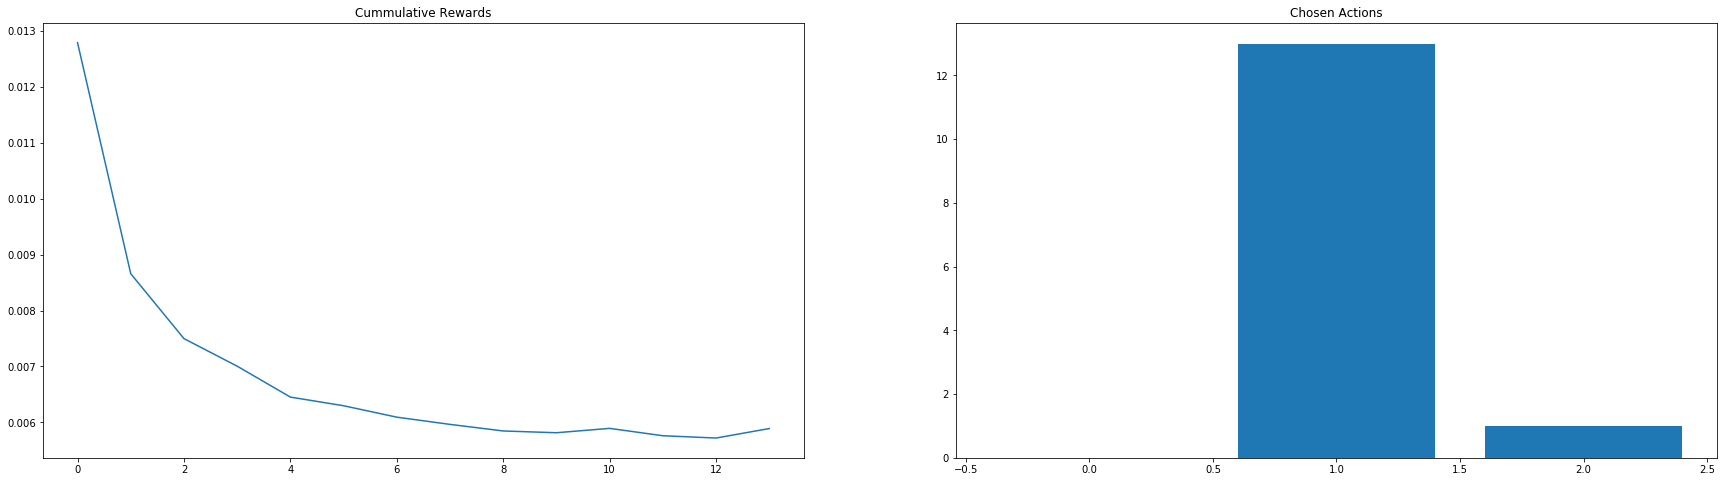

Restart at iteration: 827
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006991630769474655, 'merge_sort': 0.005219809999971403, 'heap_sort': 0.0122388999998293}
Count per chosen algo {'quick_sort': 13, 'merge_sort': 20, 'heap_sort': 1}


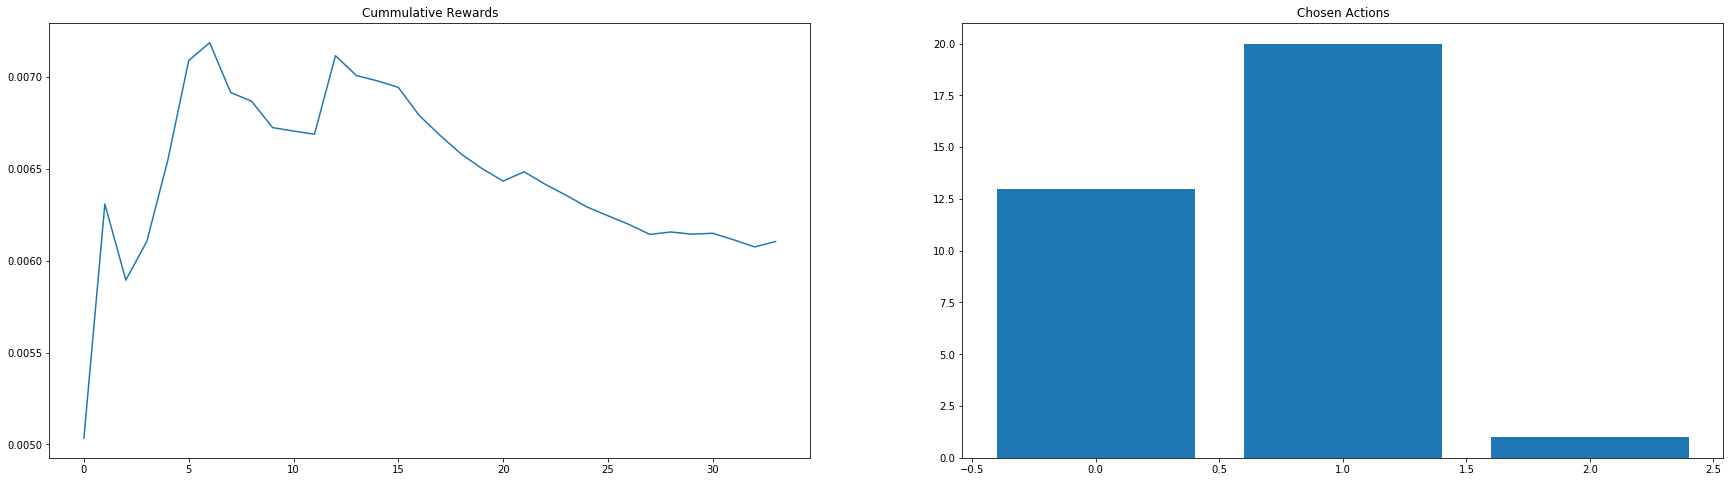

Restart at iteration: 842
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.008189700000002631, 'merge_sort': 0.005333825000207071, 'heap_sort': 0.01452065000012226}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 12, 'heap_sort': 2}


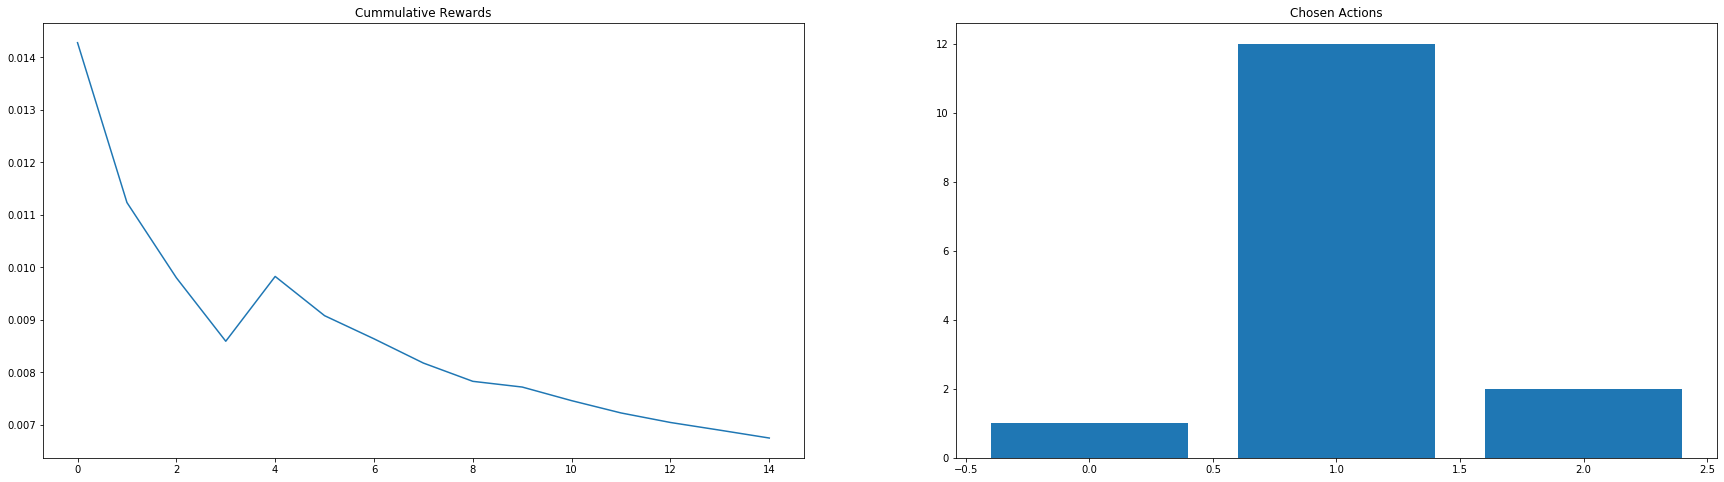

Restart at iteration: 868
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006657137500042154, 'merge_sort': 0.004811320000044361, 'heap_sort': 0.013264366666589922}
Count per chosen algo {'quick_sort': 8, 'merge_sort': 15, 'heap_sort': 3}


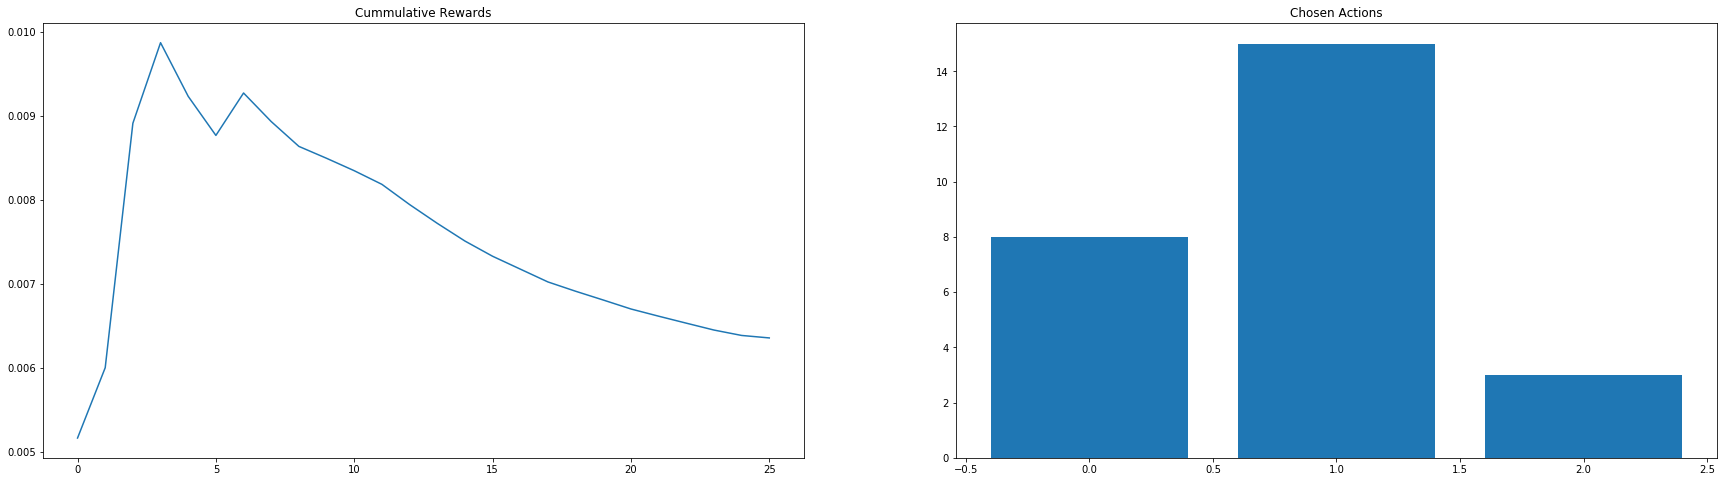

Restart at iteration: 887
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0067591999995784136, 'merge_sort': 0.005150631249932758, 'heap_sort': 0.012790150000000722}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 16, 'heap_sort': 2}


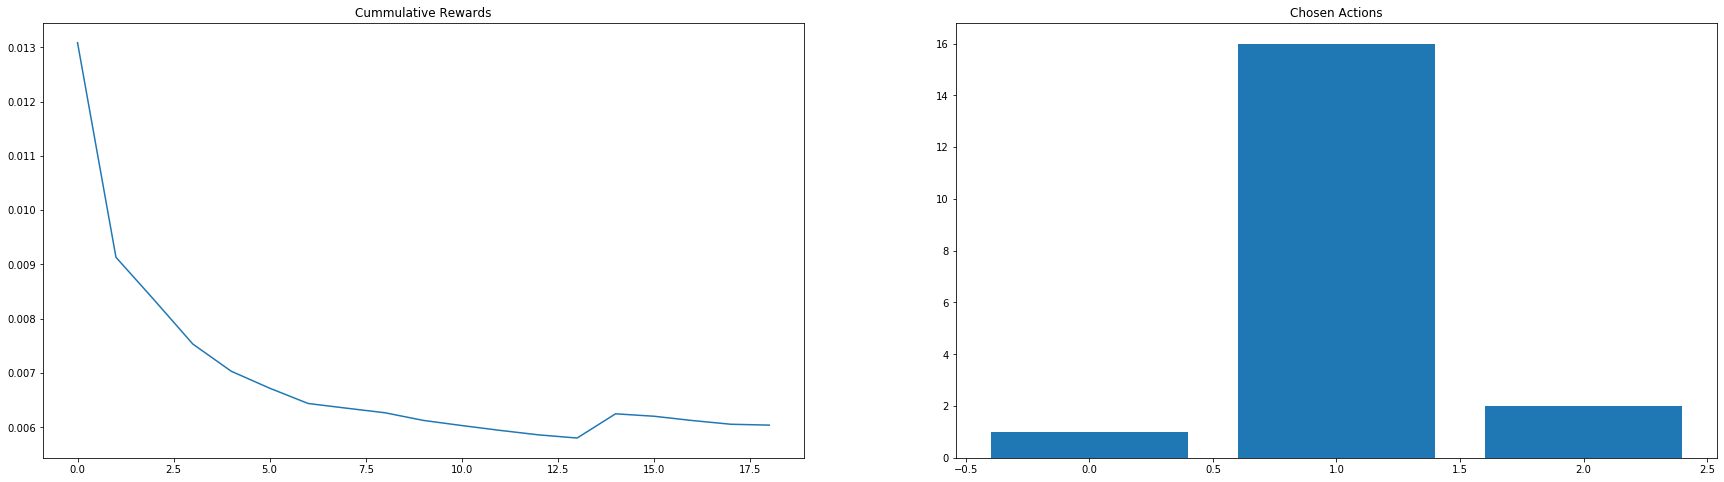

Restart at iteration: 899
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.007492899999306246, 'merge_sort': 0.00512120909099229, 'heap_sort': 0.0}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 11, 'heap_sort': 0}


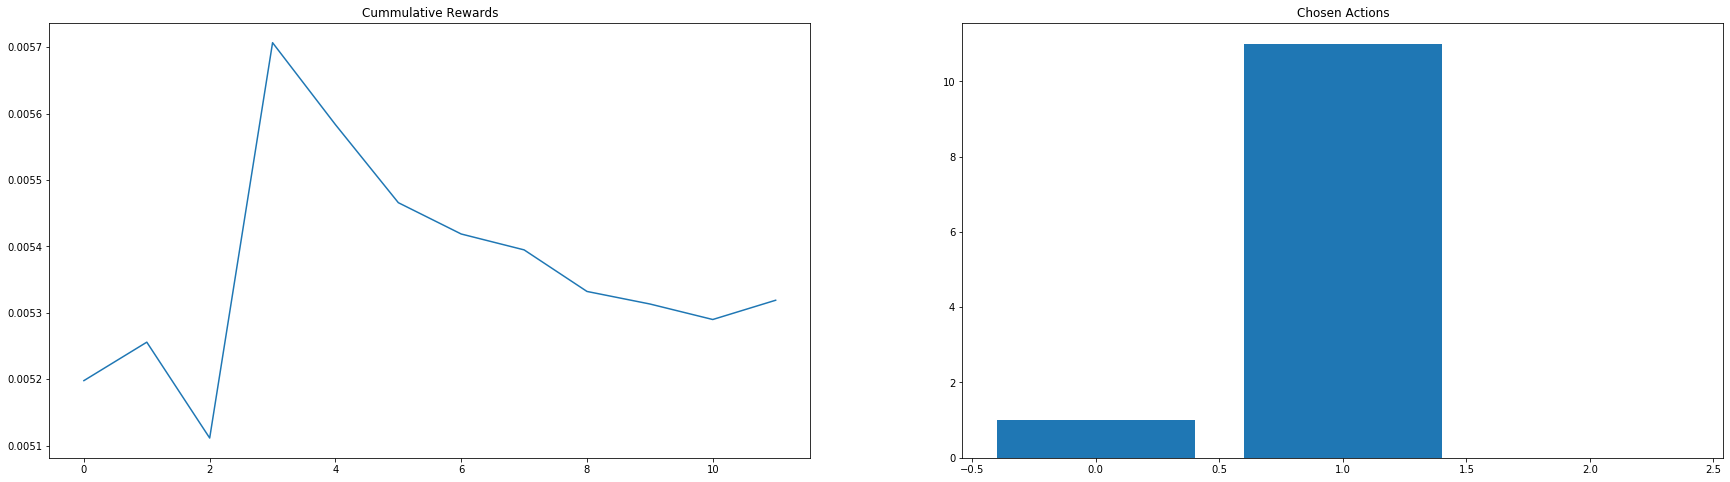

Restart at iteration: 914
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006697646153952519, 'merge_sort': 0.0066882999999506865, 'heap_sort': 0.013675400000465743}
Count per chosen algo {'quick_sort': 13, 'merge_sort': 1, 'heap_sort': 1}


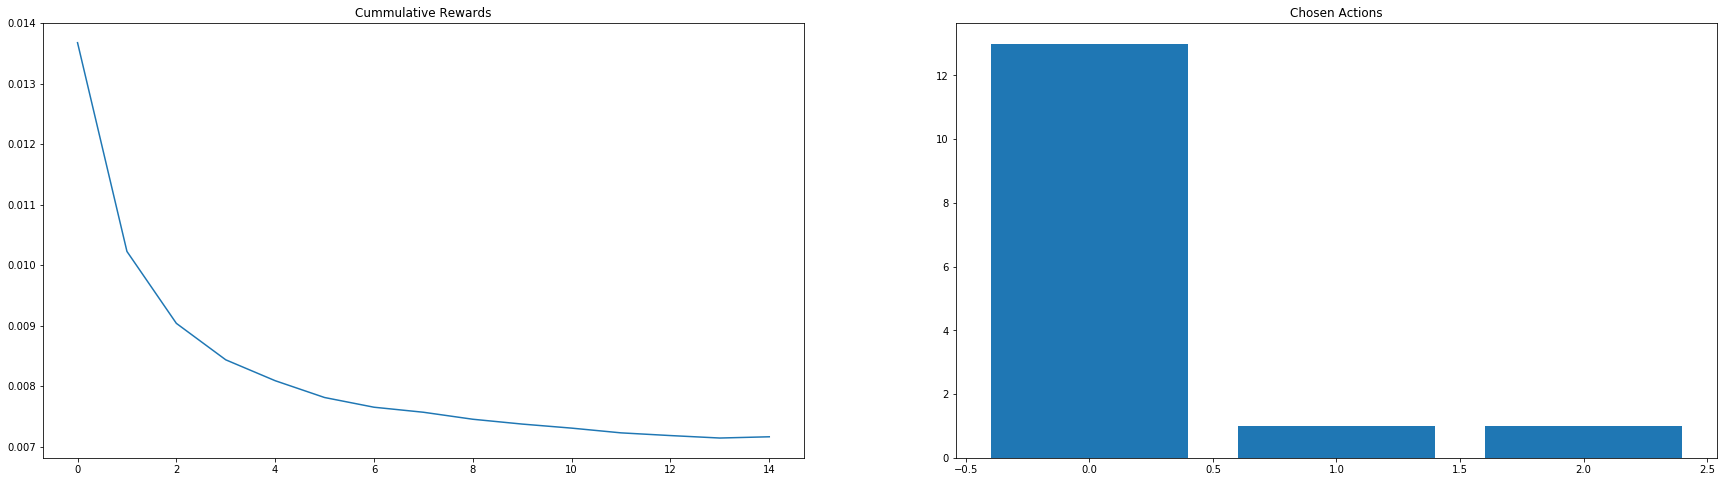

Restart at iteration: 926
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.005257883333494344, 'heap_sort': 0.0}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 12, 'heap_sort': 0}


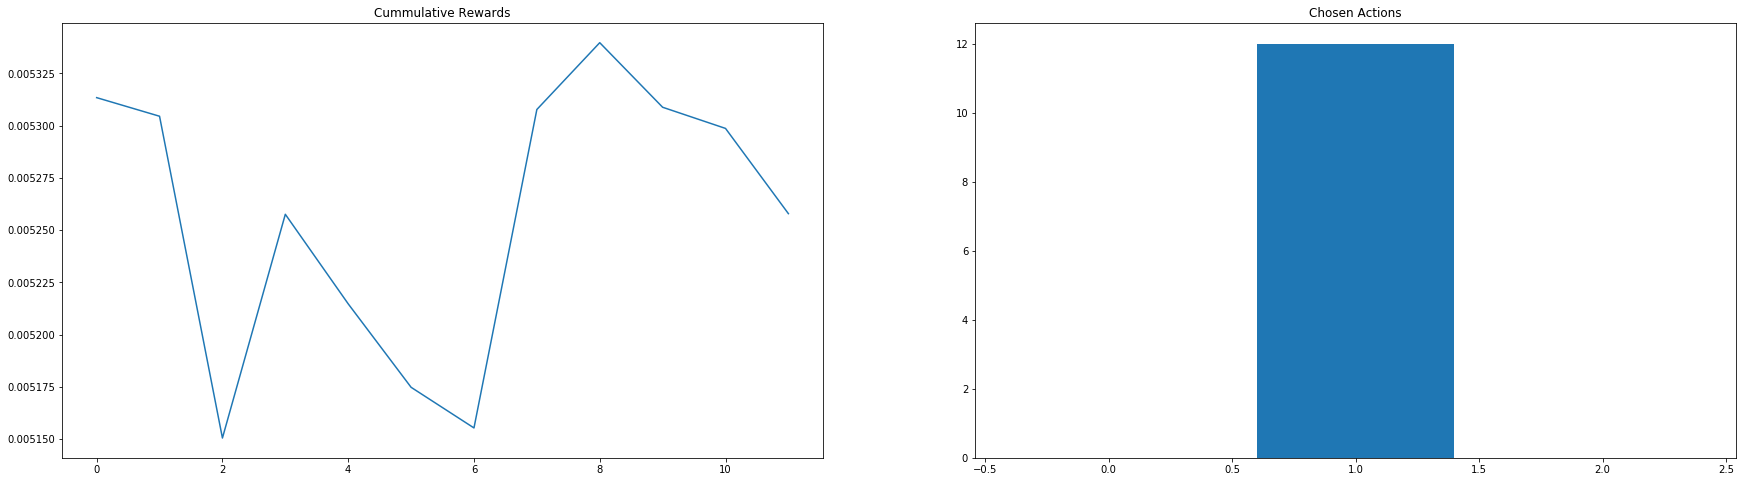

Restart at iteration: 941
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006637600000127956, 'merge_sort': 0.005219025000011849, 'heap_sort': 0.0}
Count per chosen algo {'quick_sort': 3, 'merge_sort': 12, 'heap_sort': 0}


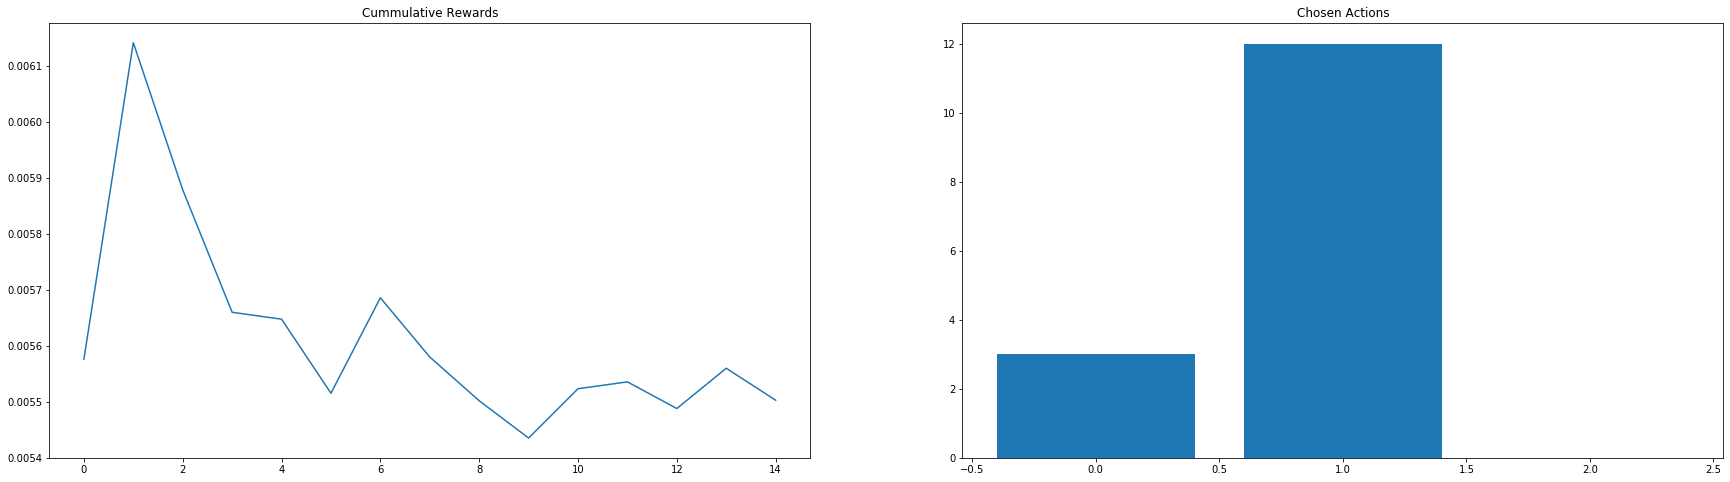

Restart at iteration: 970
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006711858333574128, 'merge_sort': 0.0048960307691371645, 'heap_sort': 0.012701025000069421}
Count per chosen algo {'quick_sort': 12, 'merge_sort': 13, 'heap_sort': 4}


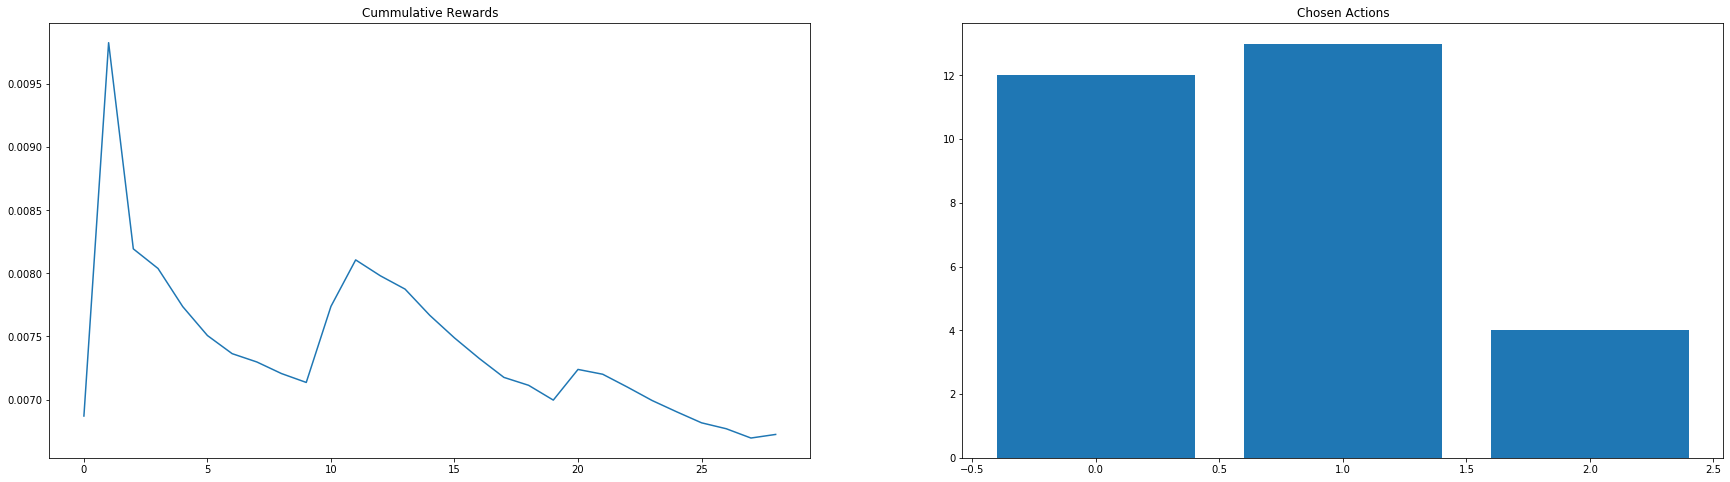

Restart at iteration: 986
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.00692979999999247, 'merge_sort': 0.0, 'heap_sort': 0.013090866666971124}
Count per chosen algo {'quick_sort': 13, 'merge_sort': 0, 'heap_sort': 3}


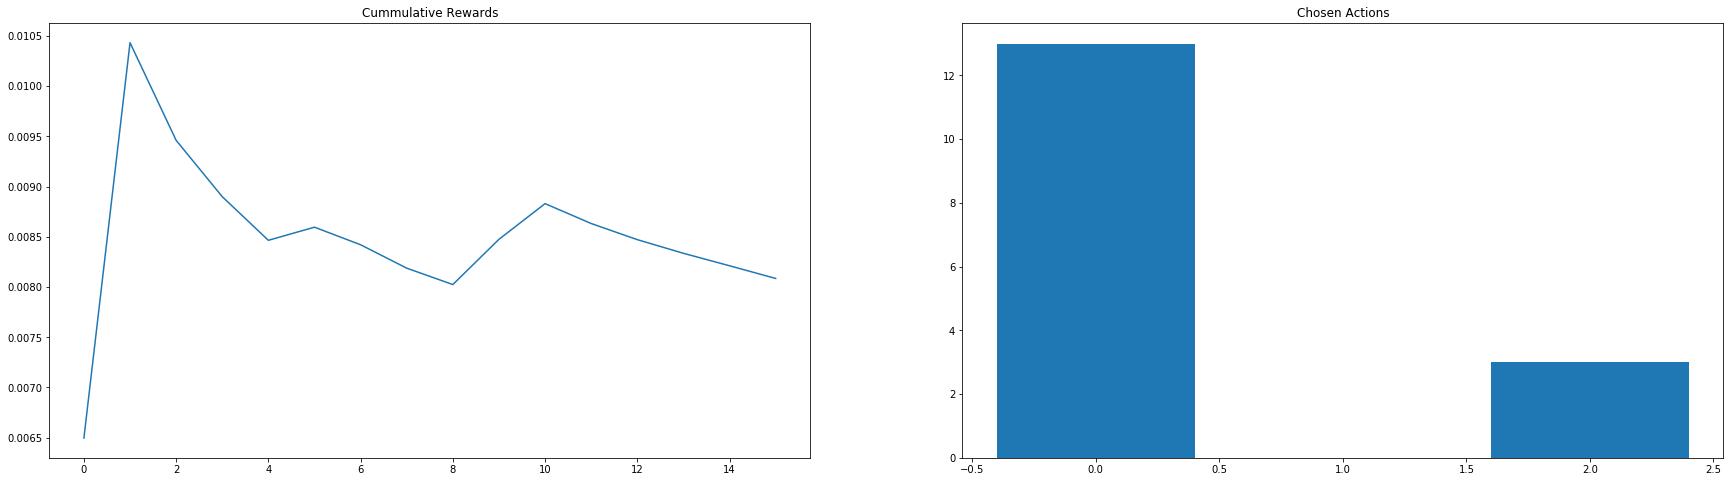

Restart at iteration: 999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0066606999998839456, 'merge_sort': 0.0058006500000071055, 'heap_sort': 0.0}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 12, 'heap_sort': 0}


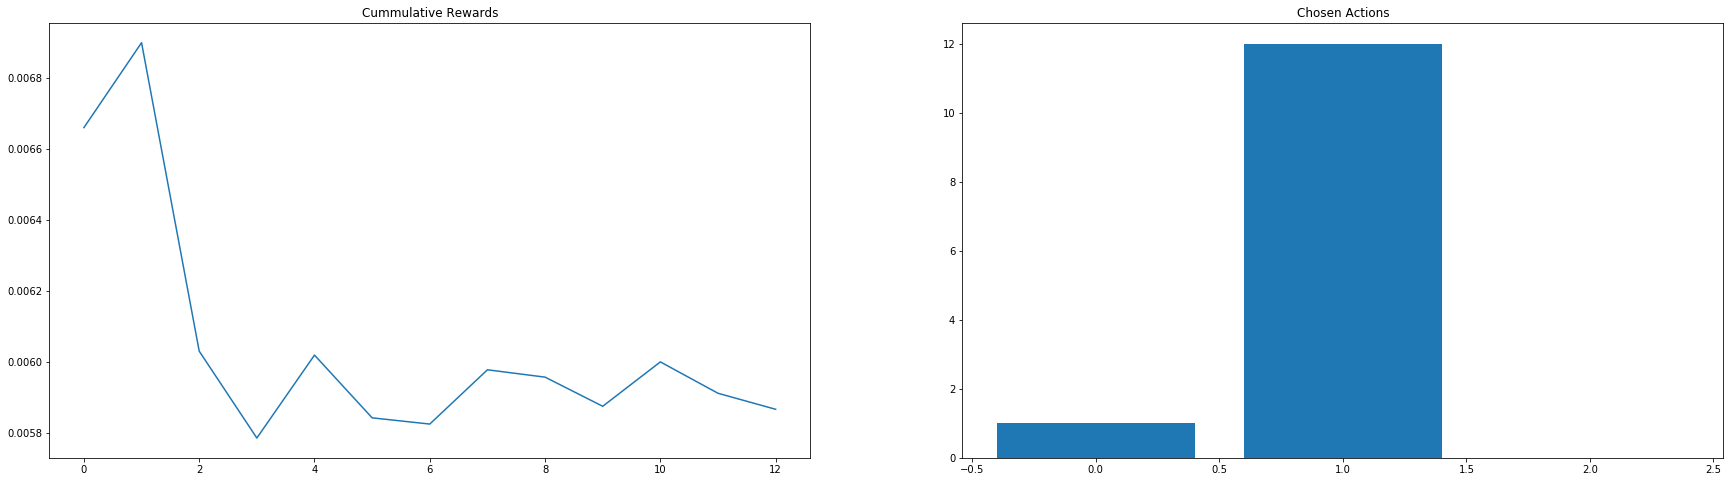

Total reward 11.2501


In [25]:
for elem in list_iteration_results_1:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_1,4))

## Two outliers in a row restart the expriment

In [26]:
list_iteration_results_2, total_reward_2, arm_rewards_2 = ts_quantile(list_distributions, n_samples, num_consec_elem=2)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.06330119385525876
Less than two values for merge_sort
merge_sort Theta 0.04262517878710566
Less than two values for heap_sort
heap_sort Theta 0.07113508883564475


Chosen algorithm is:  merge_sort with reward: 0.018202799999926356
Sample mean is:  0.018202799999926356 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.007896618928933175
Less than two values for merge_sort
merge_sort Theta 0.05651002592719068
Less than two values for heap_sort
heap_sort Theta 0.06903645596336609


Chosen algorithm is:  quick_sort with reward: 0.014540099999976519
Sample mean is:  0.014540099999976519 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.07628026841708146
Less than two values for merge_sort
merge_sort Theta 0.08250270325813457
Less than two values for heap_sort
heap_sort Theta 0.024039661470323204


Chosen algorithm is:  heap_sort with r



Iteration: 33
quick_sort Theta 0.012580100111058782
merge_sort Theta 0.014659066611489253
heap_sort Theta 0.027800471007256338


Chosen algorithm is:  quick_sort with reward: 0.01902940000036324
Sample mean is:  0.01436879444443346 Sample variance is: 2.238921724109859e-06


Iteration: 34
quick_sort Theta 0.011708509211011513
merge_sort Theta 0.019240980382475042
heap_sort Theta 0.022049363026709044


Chosen algorithm is:  quick_sort with reward: 0.01362539999990986
Sample mean is:  0.01432966842103748 Sample variance is: 2.148638961352481e-06


Iteration: 35
quick_sort Theta 0.013196730241753555
merge_sort Theta 0.015395013093818102
heap_sort Theta 0.026254474272764724


Chosen algorithm is:  quick_sort with reward: 0.012873599999693397
Sample mean is:  0.014256864999970276 Sample variance is: 2.141913437547541e-06


Iteration: 36
quick_sort Theta 0.019754279585542156
merge_sort Theta 0.012778889330547024
heap_sort Theta 0.01332536686746377


Chosen algorithm is:  merge_sort with re



Iteration: 66
quick_sort Theta 0.014644865785481515
merge_sort Theta 0.00781540256805072
heap_sort Theta 0.0187981882138524


Chosen algorithm is:  merge_sort with reward: 0.015492500000618747
Sample mean is:  0.015517647058807009 Sample variance is: 3.419384116794802e-06


Iteration: 67
quick_sort Theta 0.012534294126404845
merge_sort Theta 0.017910577857005783
heap_sort Theta 0.03338808281853134


Chosen algorithm is:  quick_sort with reward: 0.013461799999276991
Sample mean is:  0.013511688372048856 Sample variance is: 1.6122690118522159e-06


Iteration: 68
quick_sort Theta 0.01521239659497357
merge_sort Theta 0.015484690252342741
heap_sort Theta 0.0177454783977658


Chosen algorithm is:  quick_sort with reward: 0.012589099999786413
Sample mean is:  0.013490720454497436 Sample variance is: 1.5945316376671744e-06


Iteration: 69
quick_sort Theta 0.015430052310875766
merge_sort Theta 0.015426520824592845
heap_sort Theta 0.028906228623387285


Chosen algorithm is:  merge_sort with re

heap_sort Theta 0.02425157231935867


Chosen algorithm is:  quick_sort with reward: 0.017692600000373204
Sample mean is:  0.014944300000024668 Sample variance is: 1.577084523830244e-06


Iteration: 98
quick_sort Theta 0.013739030886002708
merge_sort Theta 0.015623415826572857
heap_sort Theta 0.022354300268223524


Chosen algorithm is:  quick_sort with reward: 0.01443699999981618
Sample mean is:  0.014871828571423456 Sample variance is: 1.3832993824926418e-06


Iteration: 99
quick_sort Theta 0.0095486206265829
merge_sort Theta 0.016049863407032905
heap_sort Theta 0.022206868213363345


Chosen algorithm is:  quick_sort with reward: 0.014001500000631495
Sample mean is:  0.01476303750007446 Sample variance is: 1.2932354401178966e-06


Iteration: 100
quick_sort Theta 0.019538082572516453
merge_sort Theta 0.015490561878295407
heap_sort Theta 0.022908310227063064


Chosen algorithm is:  merge_sort with reward: 0.01567120000072464
Sample mean is:  0.015790340000239666 Sample variance is: 3.496

Sample mean is:  0.014324999999795788 Sample variance is: 4.33330663298033e-09


Iteration: 127
quick_sort Theta 0.014529780331960918
merge_sort Theta 0.015723442844372593
heap_sort Theta 0.02156716720709988


Chosen algorithm is:  quick_sort with reward: 0.015897899999799847
Sample mean is:  0.014718224999796803 Sample variance is: 4.671276818521294e-07


Iteration: 128
quick_sort Theta 0.014578660941181994
merge_sort Theta 0.0160736561258097
heap_sort Theta 0.021623717112537473


Chosen algorithm is:  quick_sort with reward: 0.014329100000395556
Sample mean is:  0.014640399999916554 Sample variance is: 3.9792906790714674e-07


Iteration: 129
quick_sort Theta 0.014928524484643144
merge_sort Theta 0.015827232969534304
heap_sort Theta 0.02276264310502472


Chosen algorithm is:  quick_sort with reward: 0.014087100000324426
Sample mean is:  0.014548183333317866 Sample variance is: 3.741271245821567e-07


Iteration: 130
quick_sort Theta 0.016853214720437933
merge_sort Theta 0.0158297318024



Iteration: 158
quick_sort Theta 0.01495367550266491
merge_sort Theta 0.016345184212774005
heap_sort Theta 0.026866012316042135


Chosen algorithm is:  quick_sort with reward: 0.01565889999983483
Sample mean is:  0.014425570000003062 Sample variance is: 8.50144340153305e-07


Iteration: 159
quick_sort Theta 0.014456092858596581
merge_sort Theta 0.01632556261267847
heap_sort Theta 0.024107623282389853


Chosen algorithm is:  quick_sort with reward: 0.014345599999614933
Sample mean is:  0.014422990322571187 Sample variance is: 8.229199712501934e-07


Iteration: 160
quick_sort Theta 0.014984417081023988
merge_sort Theta 0.01587728430701192
heap_sort Theta 0.027023354434250604


Chosen algorithm is:  quick_sort with reward: 0.013946600000053877
Sample mean is:  0.014408103124992522 Sample variance is: 8.040742103527581e-07


Iteration: 161
quick_sort Theta 0.012650090592084454
merge_sort Theta 0.015821018957631834
heap_sort Theta 0.02459720045206896


Chosen algorithm is:  quick_sort with

Chosen algorithm is:  quick_sort with reward: 0.014560699999492499
Sample mean is:  0.014370215254268136 Sample variance is: 5.016031352479982e-07


Iteration: 189
quick_sort Theta 0.013989799559039003
merge_sort Theta 0.015770313414162504
heap_sort Theta 0.020133590564822453


Chosen algorithm is:  quick_sort with reward: 0.015702699999565084
Sample mean is:  0.014392423333356419 Sample variance is: 5.223418108245581e-07


Iteration: 190
quick_sort Theta 0.014773680038673733
merge_sort Theta 0.015728176772840108
heap_sort Theta 0.020286303605401835


Chosen algorithm is:  quick_sort with reward: 0.014110199999777251
Sample mean is:  0.014387796721330531 Sample variance is: 5.150631626495228e-07


Iteration: 191
quick_sort Theta 0.01383608932956688
merge_sort Theta 0.015343557731018587
heap_sort Theta 0.029232112167830296


Chosen algorithm is:  quick_sort with reward: 0.014064800000596733
Sample mean is:  0.014382587096802566 Sample variance is: 5.084112437352726e-07


Iteration: 192


merge_sort Theta 0.015274686831912436
heap_sort Theta 0.02221860338442726


Chosen algorithm is:  quick_sort with reward: 0.015309700000216253
Sample mean is:  0.014411484090942395 Sample variance is: 6.127604875343975e-07


Iteration: 219
quick_sort Theta 0.015265251255926381
merge_sort Theta 0.0157190812052807
heap_sort Theta 0.022451059189833724


Chosen algorithm is:  quick_sort with reward: 0.014583199999833596
Sample mean is:  0.014413413483177127 Sample variance is: 6.062031230230574e-07


Iteration: 220
quick_sort Theta 0.014338608909602396
merge_sort Theta 0.01605173050531601
heap_sort Theta 0.020924494220566133


Chosen algorithm is:  quick_sort with reward: 0.014624000000367232
Sample mean is:  0.014415753333368128 Sample variance is: 5.999547987707989e-07


Iteration: 221
quick_sort Theta 0.014770479670504131
merge_sort Theta 0.015877062920492405
heap_sort Theta 0.023425185342232827


Chosen algorithm is:  quick_sort with reward: 0.013750500000242027
Sample mean is:  0.0144



Iteration: 255
quick_sort Theta 0.01491198733139388
merge_sort Theta 0.015623034811920391
heap_sort Theta 0.021751772275937206


Chosen algorithm is:  quick_sort with reward: 0.01492569999936677
Sample mean is:  0.014430043200023647 Sample variance is: 6.846596814350869e-07


Iteration: 256
quick_sort Theta 0.014453650116288285
merge_sort Theta 0.01518347903671536
heap_sort Theta 0.024678921681815832


Chosen algorithm is:  quick_sort with reward: 0.014326200000141398
Sample mean is:  0.014429219047643629 Sample variance is: 6.793107778327567e-07


Iteration: 257
quick_sort Theta 0.01466191270217207
merge_sort Theta 0.015665621409375406
heap_sort Theta 0.02208403054295734


Chosen algorithm is:  quick_sort with reward: 0.014289699999608274
Sample mean is:  0.014428120472462249 Sample variance is: 6.741139393663663e-07


Iteration: 258
quick_sort Theta 0.01392402024688332
merge_sort Theta 0.01614424781232346
heap_sort Theta 0.020836385395972358


Chosen algorithm is:  quick_sort with 



Chosen algorithm is:  quick_sort with reward: 0.01844340000025113
Sample mean is:  0.0144993464516442 Sample variance is: 1.0310073751240614e-06


Iteration: 286
quick_sort Theta 0.01412961967689241
merge_sort Theta 0.015585319854901244
heap_sort Theta 0.025063032486889535


Chosen algorithm is:  quick_sort with reward: 0.014448800000536721
Sample mean is:  0.014499022435931973 Sample variance is: 1.0244146263468253e-06


Iteration: 287
quick_sort Theta 0.014437789269014232
merge_sort Theta 0.015338668675227077
heap_sort Theta 0.027542345378578914


Chosen algorithm is:  quick_sort with reward: 0.01376059999984136
Sample mean is:  0.014494319108313562 Sample variance is: 1.021340613768083e-06


Iteration: 288
quick_sort Theta 0.01477007942681737
merge_sort Theta 0.016020737850275895
heap_sort Theta 0.023313115592290375


Chosen algorithm is:  quick_sort with reward: 0.014295999999376363
Sample mean is:  0.014493063924079782 Sample variance is: 1.0151237841996193e-06


Iteration: 289


quick_sort Theta 0.014332110441715427
merge_sort Theta 0.015857015705270556
heap_sort Theta 0.021658177115252104


Chosen algorithm is:  quick_sort with reward: 0.017216199999893433
Sample mean is:  0.014471121621657378 Sample variance is: 9.340293928280922e-07


Iteration: 318
quick_sort Theta 0.013866288629702317
merge_sort Theta 0.015520476428563901
heap_sort Theta 0.020616884784506427


Chosen algorithm is:  quick_sort with reward: 0.014556500000253436
Sample mean is:  0.014471580645198217 Sample variance is: 9.290467094088338e-07


Iteration: 319
quick_sort Theta 0.013949519105673686
merge_sort Theta 0.015177480081859483
heap_sort Theta 0.022642582903386645


Chosen algorithm is:  quick_sort with reward: 0.014078600000175356
Sample mean is:  0.014469479144422695 Sample variance is: 9.248999780121679e-07


Iteration: 320
quick_sort Theta 0.014577144425987015
merge_sort Theta 0.015838760216197255
heap_sort Theta 0.022846286201509428


Chosen algorithm is:  quick_sort with reward: 0.

Sample mean is:  0.014456553738361614 Sample variance is: 8.498085522843589e-07


Iteration: 348
quick_sort Theta 0.014188436229346837
merge_sort Theta 0.015706267367075814
heap_sort Theta 0.022630673342716495


Chosen algorithm is:  quick_sort with reward: 0.014812200000051234
Sample mean is:  0.014458207907020636 Sample variance is: 8.464415169925899e-07


Iteration: 349
quick_sort Theta 0.01455875848316046
merge_sort Theta 0.01532072406119426
heap_sort Theta 0.02385504707651329


Chosen algorithm is:  quick_sort with reward: 0.014337600000544626
Sample mean is:  0.014457649537083247 Sample variance is: 8.425898383179731e-07


Iteration: 350
quick_sort Theta 0.014111306087270759
merge_sort Theta 0.015468729530572075
heap_sort Theta 0.022916910375767575


Chosen algorithm is:  quick_sort with reward: 0.014092299999902025
Sample mean is:  0.014455965898663057 Sample variance is: 8.393192177165119e-07


Iteration: 351
quick_sort Theta 0.013976147936302367
merge_sort Theta 0.015868190262

Sample mean is:  0.01443471061227646 Sample variance is: 7.72421515786453e-07


Iteration: 379
quick_sort Theta 0.014644934495587235
merge_sort Theta 0.015261441521289746
heap_sort Theta 0.023349555436378795


Chosen algorithm is:  quick_sort with reward: 0.01551389999985986
Sample mean is:  0.014439097561006474 Sample variance is: 7.73996694119676e-07


Iteration: 380
quick_sort Theta 0.014478333861623805
merge_sort Theta 0.01596476056148255
heap_sort Theta 0.022708409938167463


Chosen algorithm is:  quick_sort with reward: 0.014654699999482546
Sample mean is:  0.014439970445372773 Sample variance is: 7.710505383357054e-07


Iteration: 381
quick_sort Theta 0.014257607268736214
merge_sort Theta 0.016086058335678888
heap_sort Theta 0.026265081939648452


Chosen algorithm is:  quick_sort with reward: 0.014030600000296545
Sample mean is:  0.01443831975809424 Sample variance is: 7.686144814017551e-07


Iteration: 382
quick_sort Theta 0.013812003189025457
merge_sort Theta 0.015759984193615



Iteration: 410
quick_sort Theta 0.014660438875143268
merge_sort Theta 0.01573416578348167
heap_sort Theta 0.023821026732336027


Chosen algorithm is:  quick_sort with reward: 0.014465199999904144
Sample mean is:  0.01443064440434761 Sample variance is: 7.434229059822608e-07


Iteration: 411
quick_sort Theta 0.014133171948528924
merge_sort Theta 0.015905818148875997
heap_sort Theta 0.023183287865488365


Chosen algorithm is:  quick_sort with reward: 0.014492099999188213
Sample mean is:  0.014430865467638403 Sample variance is: 7.407622595742711e-07


Iteration: 412
quick_sort Theta 0.014568794622996978
merge_sort Theta 0.01585476447622154
heap_sort Theta 0.021426022470789157


Chosen algorithm is:  quick_sort with reward: 0.013898100000005797
Sample mean is:  0.014428955913990975 Sample variance is: 7.391208955588074e-07


Iteration: 413
quick_sort Theta 0.014499012853611166
merge_sort Theta 0.015711555768092744
heap_sort Theta 0.02223296526655283


Chosen algorithm is:  quick_sort wi

Sample mean is:  0.014411118831172975 Sample variance is: 6.859569797563083e-07


Iteration: 442
quick_sort Theta 0.014686263205429664
merge_sort Theta 0.01554500361084102
heap_sort Theta 0.024427901413009073


Chosen algorithm is:  quick_sort with reward: 0.015248600000631995
Sample mean is:  0.014413829126219767 Sample variance is: 6.859995296216053e-07


Iteration: 443
quick_sort Theta 0.014052623162271457
merge_sort Theta 0.015198303609749124
heap_sort Theta 0.024628343143714176


Chosen algorithm is:  quick_sort with reward: 0.014448899999479181
Sample mean is:  0.01441394225806899 Sample variance is: 6.837905827470789e-07


Iteration: 444
quick_sort Theta 0.013864881059389388
merge_sort Theta 0.01606513299349113
heap_sort Theta 0.02426072246051298


Chosen algorithm is:  quick_sort with reward: 0.014273400000092806
Sample mean is:  0.014413490353702508 Sample variance is: 6.816552066437667e-07


Iteration: 445
quick_sort Theta 0.014703992790670044
merge_sort Theta 0.0155229466989



Iteration: 472
quick_sort Theta 0.014793426047506782
merge_sort Theta 0.016502299080720678
Less than two values for heap_sort
heap_sort Theta 0.021893180667249115


Chosen algorithm is:  quick_sort with reward: 0.015368999999736843
Sample mean is:  0.0144793571428506 Sample variance is: 7.590855254645936e-07


Iteration: 473
quick_sort Theta 0.018170393763987828
merge_sort Theta 0.014602933241637648
Less than two values for heap_sort
heap_sort Theta 0.08749836923798049


Chosen algorithm is:  merge_sort with reward: 0.016255200000159675
Sample mean is:  0.015535725000063394 Sample variance is: 4.796636669015141e-07


Iteration: 474
quick_sort Theta 0.01171016031071256
merge_sort Theta 0.014719215484585038
Less than two values for heap_sort
heap_sort Theta 0.06053924221457038


Chosen algorithm is:  quick_sort with reward: 0.014138200000161305
Sample mean is:  0.014436712500014437 Sample variance is: 6.769297937198858e-07


Iteration: 475
quick_sort Theta 0.0164956376784205
merge_sort



Chosen algorithm is:  quick_sort with reward: 0.006132900000011432
Sample mean is:  0.00959065000006376 Sample variance is: 1.5033783127037907e-05


Iteration: 502
quick_sort Theta -0.009793397253193791
Less than two values for merge_sort
merge_sort Theta 0.05450987314234788
Less than two values for heap_sort
heap_sort Theta 0.052990841085587576


Chosen algorithm is:  quick_sort with reward: 0.005185100000744569
Sample mean is:  0.008709540000199922 Sample variance is: 1.5132445829070537e-05


Iteration: 503
quick_sort Theta 0.0250708864302992
Less than two values for merge_sort
merge_sort Theta 0.02581961573895125
Less than two values for heap_sort
heap_sort Theta 0.0019159657318693847


Chosen algorithm is:  heap_sort with reward: 0.01111730000047828
Sample mean is:  0.01111730000047828 Sample variance is: 0.0


Iteration: 504
quick_sort Theta 0.01592288962254409
Less than two values for merge_sort
merge_sort Theta 0.025692769512681204
Less than two values for heap_sort
heap_sort 



Chosen algorithm is:  quick_sort with reward: 0.006135699999504141
Sample mean is:  0.0058914320000258156 Sample variance is: 5.16305361580329e-06


Iteration: 537
quick_sort Theta 0.006589747801773318
merge_sort Theta 0.0036623102025857258
heap_sort Theta 0.010617656185033138


Chosen algorithm is:  merge_sort with reward: 0.0033518999998705112
Sample mean is:  0.0033362444442496374 Sample variance is: 1.2353744738077788e-08


Iteration: 538
quick_sort Theta 0.005207200198350312
merge_sort Theta 0.0033137413211747797
heap_sort Theta 0.01409180254005583


Chosen algorithm is:  merge_sort with reward: 0.002930499999820313
Sample mean is:  0.003295669999806705 Sample variance is: 2.593494014094353e-08


Iteration: 539
quick_sort Theta 0.00018122902908036895
merge_sort Theta 0.003448001720366898
heap_sort Theta 0.011699448514417274


Chosen algorithm is:  quick_sort with reward: 0.004805300000043644
Sample mean is:  0.005849657692334194 Sample variance is: 5.008101950157945e-06


Iterat



Chosen algorithm is:  merge_sort with reward: 0.004422799999701965
Sample mean is:  0.003429468420946298 Sample variance is: 2.884173674287406e-07


Iteration: 575
quick_sort Theta 0.006869644615186695
merge_sort Theta 0.003138781173395031
heap_sort Theta 0.010600829661294796


Chosen algorithm is:  merge_sort with reward: 0.0033141000003524823
Sample mean is:  0.0034265102563156877 Sample variance is: 2.8135457835849134e-07


Iteration: 576
quick_sort Theta 0.009634187039070896
merge_sort Theta 0.0035996398026715793
heap_sort Theta 0.00947808072036344


Chosen algorithm is:  merge_sort with reward: 0.003525699999954668
Sample mean is:  0.003428989999906662 Sample variance is: 2.7456052990233123e-07


Iteration: 577
quick_sort Theta 0.006607287963999187
merge_sort Theta 0.003027082305243855
heap_sort Theta 0.010908397449076589


Chosen algorithm is:  merge_sort with reward: 0.0023373000003630295
Sample mean is:  0.003402363414551939 Sample variance is: 2.962229335181239e-07


Iterati



Chosen algorithm is:  merge_sort with reward: 0.004461200000150711
Sample mean is:  0.0034124044775546906 Sample variance is: 2.3721614311300186e-07


Iteration: 605
quick_sort Theta 0.004249310594210257
merge_sort Theta 0.0031069137353196704
heap_sort Theta 0.010416539676743965


Chosen algorithm is:  merge_sort with reward: 0.003225100000236125
Sample mean is:  0.0034096499999470647 Sample variance is: 2.342360092618547e-07


Iteration: 606
quick_sort Theta 0.0064427087130516794
merge_sort Theta 0.003938114146210908
heap_sort Theta 0.012230691892881958


Chosen algorithm is:  merge_sort with reward: 0.003650000000561704
Sample mean is:  0.003413133333289306 Sample variance is: 2.3166637004971927e-07


Iteration: 607
quick_sort Theta 0.003925687427063748
merge_sort Theta 0.0029378040338676682
heap_sort Theta 0.010452579739328125


Chosen algorithm is:  merge_sort with reward: 0.0033129000003100373
Sample mean is:  0.003411701428532459 Sample variance is: 2.284983247126354e-07


Iter



Chosen algorithm is:  quick_sort with reward: 0.0061216999993121135
Sample mean is:  0.005308899999992998 Sample variance is: 1.2956166299646022e-07


Iteration: 633
quick_sort Theta 0.005278526348510801
Less than two values for merge_sort
merge_sort Theta 0.05480819688781368
Less than two values for heap_sort
heap_sort Theta 0.04057023655260764


Chosen algorithm is:  quick_sort with reward: 0.005363999999644875
Sample mean is:  0.005312835714253846 Sample variance is: 1.2050862650437268e-07


Iteration: 634
quick_sort Theta 0.005111647425608258
Less than two values for merge_sort
merge_sort Theta 0.08555051032344585
Less than two values for heap_sort
heap_sort Theta 0.08265191207889824


Chosen algorithm is:  quick_sort with reward: 0.005053799999586772
Sample mean is:  0.005295566666609375 Sample variance is: 1.1664979816240626e-07


Iteration: 635
quick_sort Theta 0.005039303989118867
Less than two values for merge_sort
merge_sort Theta 0.054781487545307164
Less than two values f



Chosen algorithm is:  merge_sort with reward: 0.004493100000217964
Sample mean is:  0.003423450000127559 Sample variance is: 9.275565053421656e-08


Iteration: 661
quick_sort Theta 0.005417455483192373
merge_sort Theta 0.003841305070524993
Less than two values for heap_sort
heap_sort Theta 0.07648417374127936


Chosen algorithm is:  merge_sort with reward: 0.0029223000001366017
Sample mean is:  0.003399585714413704 Sample variance is: 9.972879744714214e-08
RESTART EXPERIMENT


Iteration: 662
Less than two values for quick_sort
quick_sort Theta 0.09666169928405038
Less than two values for merge_sort
merge_sort Theta 0.09359309460205634
Less than two values for heap_sort
heap_sort Theta 0.025630207827019604


Chosen algorithm is:  heap_sort with reward: 0.010990599999786355
Sample mean is:  0.010990599999786355 Sample variance is: 0.0


Iteration: 663
Less than two values for quick_sort
quick_sort Theta 0.0674163116739903
Less than two values for merge_sort
merge_sort Theta 0.068724001

merge_sort Theta 0.04919708226620232
heap_sort Theta 0.011078786235778607


Chosen algorithm is:  quick_sort with reward: 0.005737100000260398
Sample mean is:  0.005230913636420486 Sample variance is: 2.037096511641237e-07


Iteration: 687
quick_sort Theta 0.0053432104158993195
Less than two values for merge_sort
merge_sort Theta 0.05582906112133951
heap_sort Theta 0.011189459146717136


Chosen algorithm is:  quick_sort with reward: 0.005455299999994168
Sample mean is:  0.005240669565271515 Sample variance is: 1.9694662905958154e-07


Iteration: 688
quick_sort Theta 0.005375603224876289
Less than two values for merge_sort
merge_sort Theta 0.06717500229814942
heap_sort Theta 0.01093197404200239


Chosen algorithm is:  quick_sort with reward: 0.005051099999946018
Sample mean is:  0.005232770833382953 Sample variance is: 1.9017548872072233e-07


Iteration: 689
quick_sort Theta 0.005331373260605804
Less than two values for merge_sort
merge_sort Theta 0.04732225905255538
heap_sort Theta 0.0



Chosen algorithm is:  merge_sort with reward: 0.0044289999996180995
Sample mean is:  0.003424922222115533 Sample variance is: 1.273392883407517e-07


Iteration: 714
quick_sort Theta 0.0052053808733285925
merge_sort Theta 0.003123314407095483
heap_sort Theta 0.010704528498652352


Chosen algorithm is:  merge_sort with reward: 0.0028331000003163354
Sample mean is:  0.003365739999935613 Sample variance is: 1.46128178306057e-07


Iteration: 715
quick_sort Theta 0.005226751551474398
merge_sort Theta 0.0031538001196990666
heap_sort Theta 0.011004568565238149


Chosen algorithm is:  merge_sort with reward: 0.003540400000019872
Sample mean is:  0.0033816181817614547 Sample variance is: 1.353649650409967e-07


Iteration: 716
quick_sort Theta 0.005224816046459139
merge_sort Theta 0.0037587698791785367
heap_sort Theta 0.011779775720642859


Chosen algorithm is:  merge_sort with reward: 0.0032295999999405467
Sample mean is:  0.003368949999943046 Sample variance is: 1.2584986242400726e-07


Itera



Chosen algorithm is:  merge_sort with reward: 0.0040948000005300855
Sample mean is:  0.0033989666666317275 Sample variance is: 1.1423767503156691e-07


Iteration: 744
quick_sort Theta 0.005431079005611276
merge_sort Theta 0.0032982936148285118
heap_sort Theta 0.011187736036672488


Chosen algorithm is:  merge_sort with reward: 0.003108799999608891
Sample mean is:  0.0033917124999561566 Sample variance is: 1.134340275878993e-07


Iteration: 745
quick_sort Theta 0.005489627708063865
merge_sort Theta 0.0035980939568461307
heap_sort Theta 0.011059396518460989


Chosen algorithm is:  merge_sort with reward: 0.003367400000570342
Sample mean is:  0.003391119512166259 Sample variance is: 1.1068140936895318e-07


Iteration: 746
quick_sort Theta 0.005198448092749013
merge_sort Theta 0.003060058248842987
heap_sort Theta 0.011032343979992087


Chosen algorithm is:  merge_sort with reward: 0.0033213000006071525
Sample mean is:  0.0033894571428434227 Sample variance is: 1.0815944005969714e-07


It

Sample mean is:  0.0034004200000708807 Sample variance is: 1.7378154142929392e-07


Iteration: 773
quick_sort Theta 0.009555671643987945
merge_sort Theta 0.0031796654482376483
Less than two values for heap_sort
heap_sort Theta 0.03304276232879686


Chosen algorithm is:  merge_sort with reward: 0.0028211999997438397
Sample mean is:  0.0033038833333497073 Sample variance is: 1.9141459129925287e-07


Iteration: 774
quick_sort Theta 0.008696474364051812
merge_sort Theta 0.004738612064671916
Less than two values for heap_sort
heap_sort Theta 0.051685419216932704


Chosen algorithm is:  merge_sort with reward: 0.003526899999997113
Sample mean is:  0.0033357428571564795 Sample variance is: 1.7015982522823966e-07


Iteration: 775
quick_sort Theta 0.009670770718909028
merge_sort Theta 0.00376862263579928
Less than two values for heap_sort
heap_sort Theta 0.03919891017460586


Chosen algorithm is:  merge_sort with reward: 0.003518399999848043
Sample mean is:  0.003358574999992925 Sample variance



Iteration: 801
Less than two values for quick_sort
quick_sort Theta 0.042980931111682386
merge_sort Theta 0.0034863747624704696
Less than two values for heap_sort
heap_sort Theta 0.047227702899800085


Chosen algorithm is:  merge_sort with reward: 0.0038640999991912395
Sample mean is:  0.0034954611111162296 Sample variance is: 1.9799862234761963e-07


Iteration: 802
Less than two values for quick_sort
quick_sort Theta 0.05692911114688416
merge_sort Theta 0.0035053300813765106
Less than two values for heap_sort
heap_sort Theta 0.021357792065377093


Chosen algorithm is:  merge_sort with reward: 0.003587600000173552
Sample mean is:  0.0035003105263297727 Sample variance is: 1.8800094512650093e-07


Iteration: 803
Less than two values for quick_sort
quick_sort Theta 0.0899645757085517
merge_sort Theta 0.003395756316249513
Less than two values for heap_sort
heap_sort Theta 0.050637749151592096


Chosen algorithm is:  merge_sort with reward: 0.0024326000002474757
Sample mean is:  0.003446



Iteration: 830
quick_sort Theta 0.007597692356808109
merge_sort Theta 0.002722288334334822
heap_sort Theta 0.010683996755243664


Chosen algorithm is:  merge_sort with reward: 0.0033477000006314483
Sample mean is:  0.003323531578787783 Sample variance is: 1.6856717579232232e-07


Iteration: 831
quick_sort Theta 0.003453826391013026
merge_sort Theta 0.002837671135081537
heap_sort Theta 0.012806335531597846


Chosen algorithm is:  merge_sort with reward: 0.0027012000000468106
Sample mean is:  0.0032924149998507348 Sample variance is: 1.7853540521287223e-07


Iteration: 832
quick_sort Theta 0.005339657925490757
merge_sort Theta 0.0036423716845032667
heap_sort Theta 0.012930467148133052


Chosen algorithm is:  merge_sort with reward: 0.0033026000000973
Sample mean is:  0.003292899999862476 Sample variance is: 1.7003842375058226e-07


Iteration: 833
quick_sort Theta 0.0058124115779987
merge_sort Theta 0.003677789526283273
heap_sort Theta 0.007227747315773372


Chosen algorithm is:  merge_



Chosen algorithm is:  merge_sort with reward: 0.004430799999681767
Sample mean is:  0.0033076199999083076 Sample variance is: 2.0841888774841655e-07


Iteration: 868
quick_sort Theta 0.0031644119548449655
merge_sort Theta 0.0030395880742152565
heap_sort Theta 0.010867713961140791


Chosen algorithm is:  merge_sort with reward: 0.0033595000004424946
Sample mean is:  0.003308546428489275 Sample variance is: 2.047443267411261e-07


Iteration: 869
quick_sort Theta 0.004991872668766158
merge_sort Theta 0.0030837531601189054
heap_sort Theta 0.011557282728487111


Chosen algorithm is:  merge_sort with reward: 0.0035664999995788094
Sample mean is:  0.00331307192973646 Sample variance is: 2.0229921005496884e-07


Iteration: 870
quick_sort Theta 0.005697797512992981
merge_sort Theta 0.002674579353533076
heap_sort Theta 0.015388676412539017


Chosen algorithm is:  merge_sort with reward: 0.0027382999996916624
Sample mean is:  0.0033031620688736187 Sample variance is: 2.0440899715251781e-07


It



Iteration: 905
quick_sort Theta 0.006090926691637998
merge_sort Theta 0.0027618197061211854
heap_sort Theta 0.012094924882837843


Chosen algorithm is:  merge_sort with reward: 0.00419419999980164
Sample mean is:  0.0033066296702979874 Sample variance is: 1.753260224942094e-07


Iteration: 906
quick_sort Theta 0.005939908215985879
merge_sort Theta 0.0036971426655620027
heap_sort Theta 0.01439157621775821


Chosen algorithm is:  merge_sort with reward: 0.0027992000004815054
Sample mean is:  0.0033011141304086777 Sample variance is: 1.7618863226302425e-07


Iteration: 907
quick_sort Theta 0.006852903549860408
merge_sort Theta 0.0034870732625748727
heap_sort Theta 0.00882570779836551


Chosen algorithm is:  merge_sort with reward: 0.003318799999760813
Sample mean is:  0.003301304301046873 Sample variance is: 1.7429745800903123e-07


Iteration: 908
quick_sort Theta 0.006119820133368198
merge_sort Theta 0.003531380461105867
heap_sort Theta 0.012950902942448425


Chosen algorithm is:  merg



Chosen algorithm is:  merge_sort with reward: 0.004348600000412262
Sample mean is:  0.003327792968754295 Sample variance is: 1.6954127421699415e-07


Iteration: 944
quick_sort Theta 0.0050907981252335
merge_sort Theta 0.0030917048146584837
heap_sort Theta 0.01009346364711947


Chosen algorithm is:  merge_sort with reward: 0.00331220000043686
Sample mean is:  0.003327672093030904 Sample variance is: 1.682288709738363e-07


Iteration: 945
quick_sort Theta 0.005240170915712374
merge_sort Theta 0.003192293934657106
heap_sort Theta 0.012055966189330422


Chosen algorithm is:  merge_sort with reward: 0.003267000000050757
Sample mean is:  0.0033272053846233646 Sample variance is: 1.6696290109473515e-07


Iteration: 946
quick_sort Theta 0.005991214006679073
merge_sort Theta 0.0033043236704029884
heap_sort Theta 0.008047606051407889


Chosen algorithm is:  merge_sort with reward: 0.0025277999993704725
Sample mean is:  0.003321103053438228 Sample variance is: 1.7052937309828172e-07


Iteration



Iteration: 981
Less than two values for quick_sort
quick_sort Theta 0.05528469817449129
merge_sort Theta 0.0035932716925004826
Less than two values for heap_sort
heap_sort Theta 0.08440881014246136


Chosen algorithm is:  merge_sort with reward: 0.003732099999979255
Sample mean is:  0.003576666666554552 Sample variance is: 6.09527554787079e-09


Iteration: 982
Less than two values for quick_sort
quick_sort Theta 0.0014506562906830946
merge_sort Theta 0.0035543663804819313
Less than two values for heap_sort
heap_sort Theta 0.06737549503339


Chosen algorithm is:  quick_sort with reward: 0.0049537999993845006
Sample mean is:  0.0049537999993845006 Sample variance is: 0.0


Iteration: 983
Less than two values for quick_sort
quick_sort Theta 0.004977624159629513
merge_sort Theta 0.0035500741353398178
Less than two values for heap_sort
heap_sort Theta 0.06545559310408547


Chosen algorithm is:  merge_sort with reward: 0.003417799999624549
Sample mean is:  0.003560779999861552 Sample varia

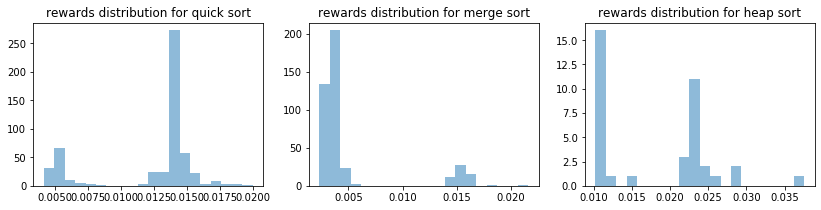

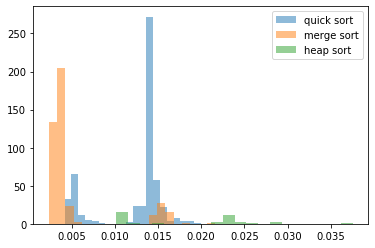

In [27]:
plot_rewards_distribution(arm_rewards_2)
plot_rewards_distribution_together(arm_rewards_2)

Restart at iteration: 83
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.013446489655099616, 'merge_sort': 0.015449244444425858, 'heap_sort': 0.026267037500019796}
Count per chosen algo {'quick_sort': 58, 'merge_sort': 18, 'heap_sort': 8}


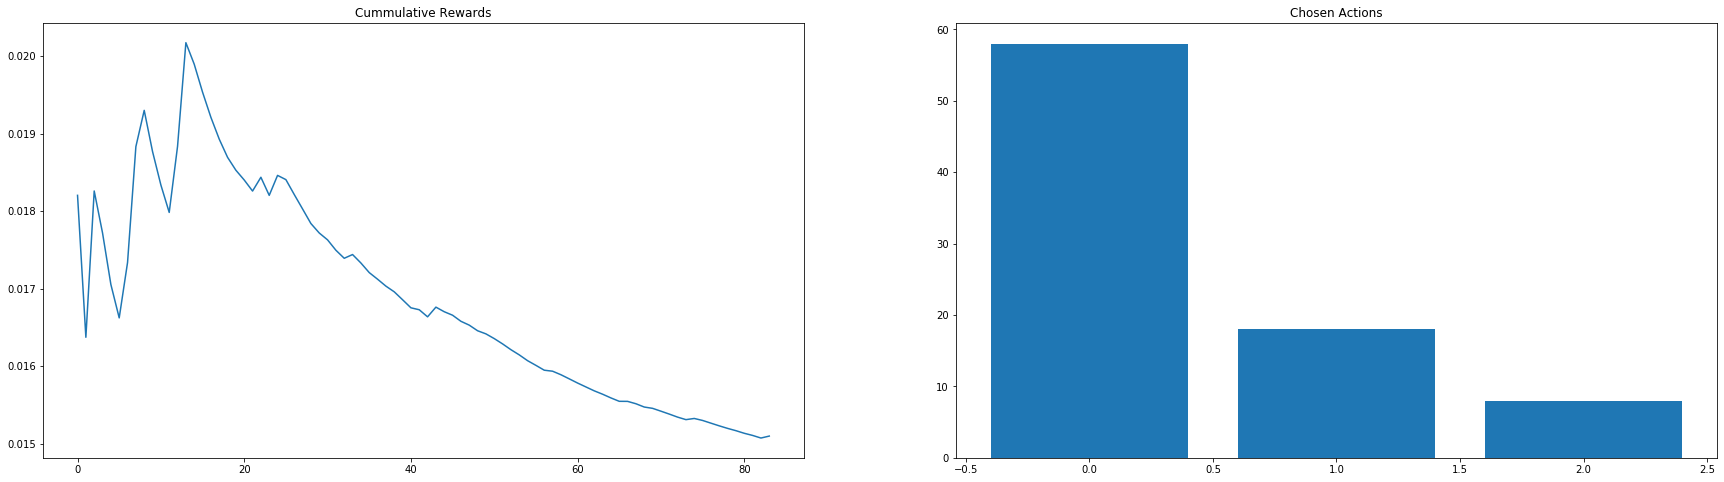

Restart at iteration: 116
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014664931250138125, 'merge_sort': 0.015844300000166046, 'heap_sort': 0.02320467499953338}
Count per chosen algo {'quick_sort': 16, 'merge_sort': 13, 'heap_sort': 4}


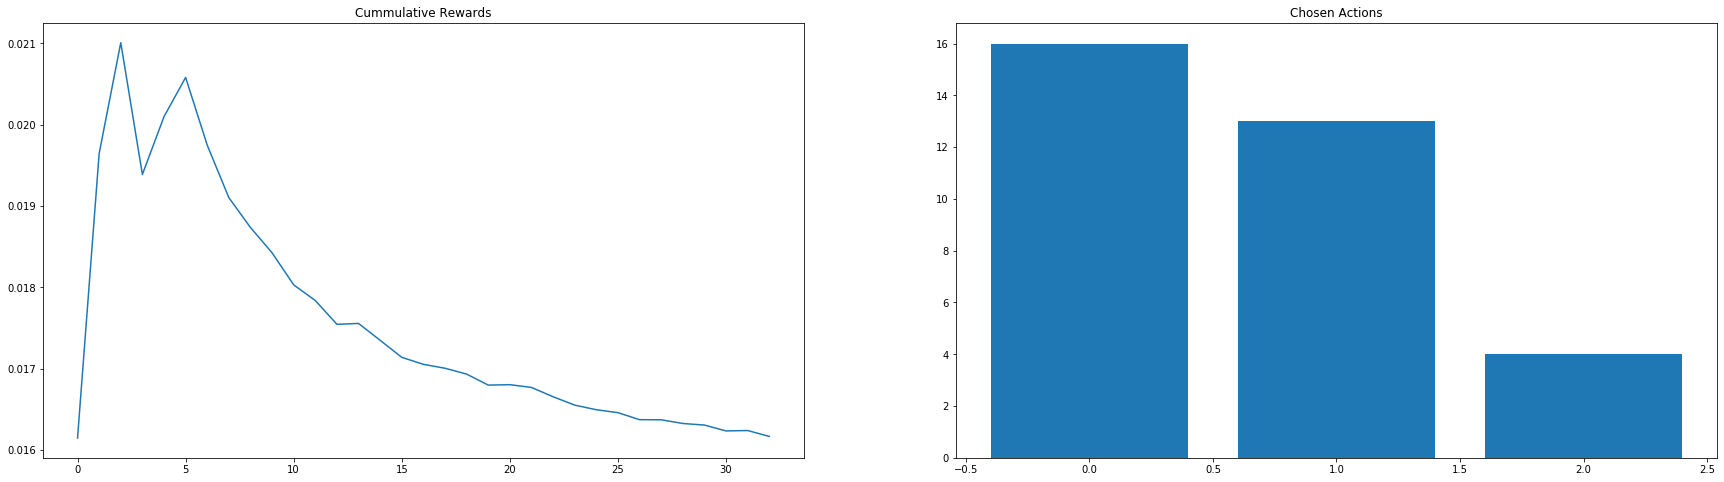

Restart at iteration: 458
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014407074461543323, 'merge_sort': 0.015669341666656084, 'heap_sort': 0.0230303799999092}
Count per chosen algo {'quick_sort': 325, 'merge_sort': 12, 'heap_sort': 5}


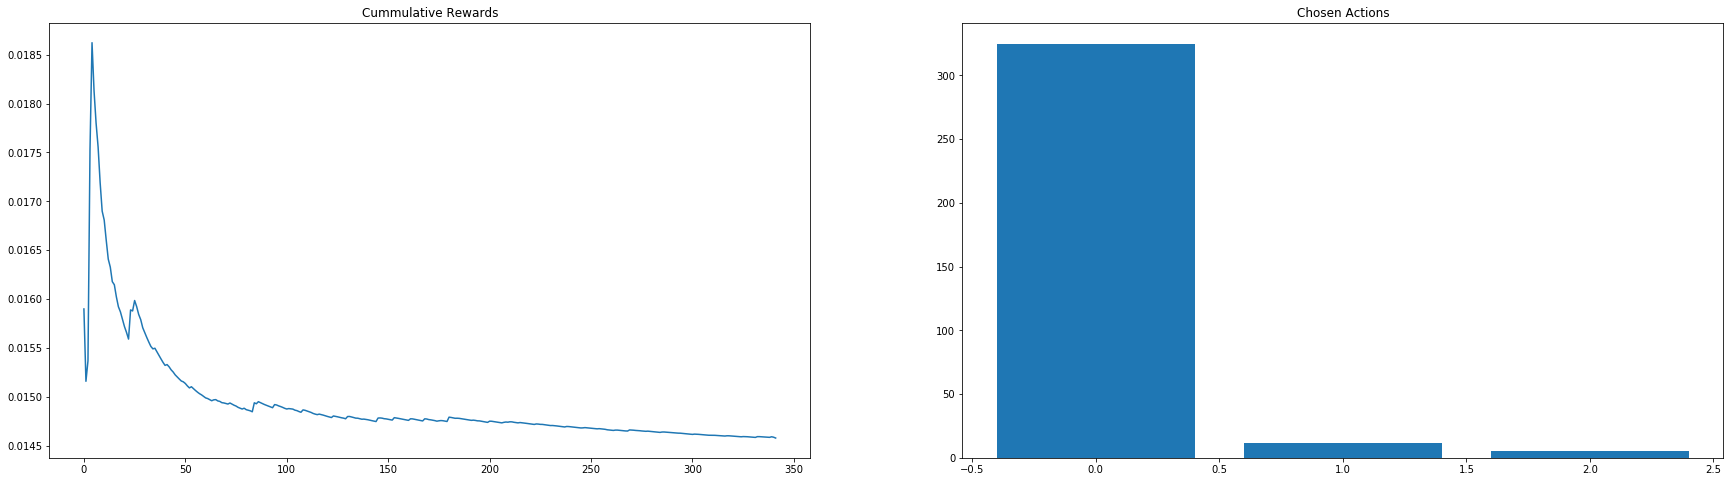

Restart at iteration: 497
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014328260869621337, 'merge_sort': 0.015479938461654595, 'heap_sort': 0.023877500000101765}
Count per chosen algo {'quick_sort': 23, 'merge_sort': 13, 'heap_sort': 3}


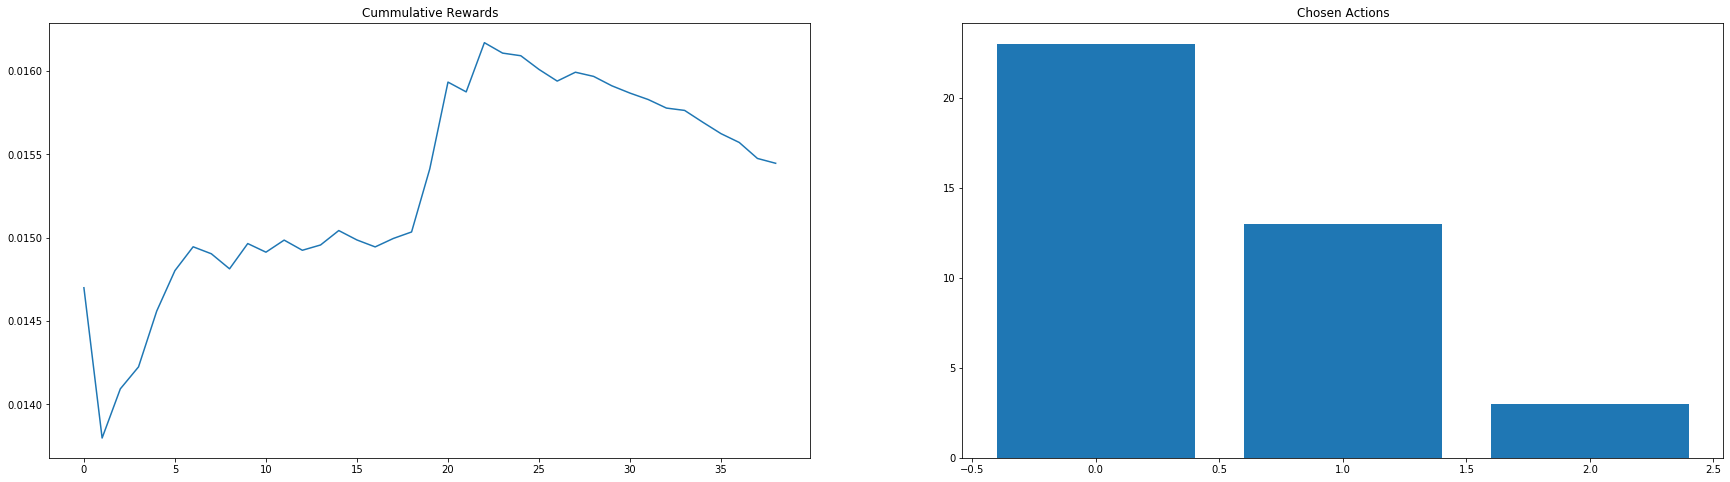

Restart at iteration: 618
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.005631200000018854, 'merge_sort': 0.0033796749999510213, 'heap_sort': 0.010815457142988245}
Count per chosen algo {'quick_sort': 34, 'merge_sort': 80, 'heap_sort': 7}


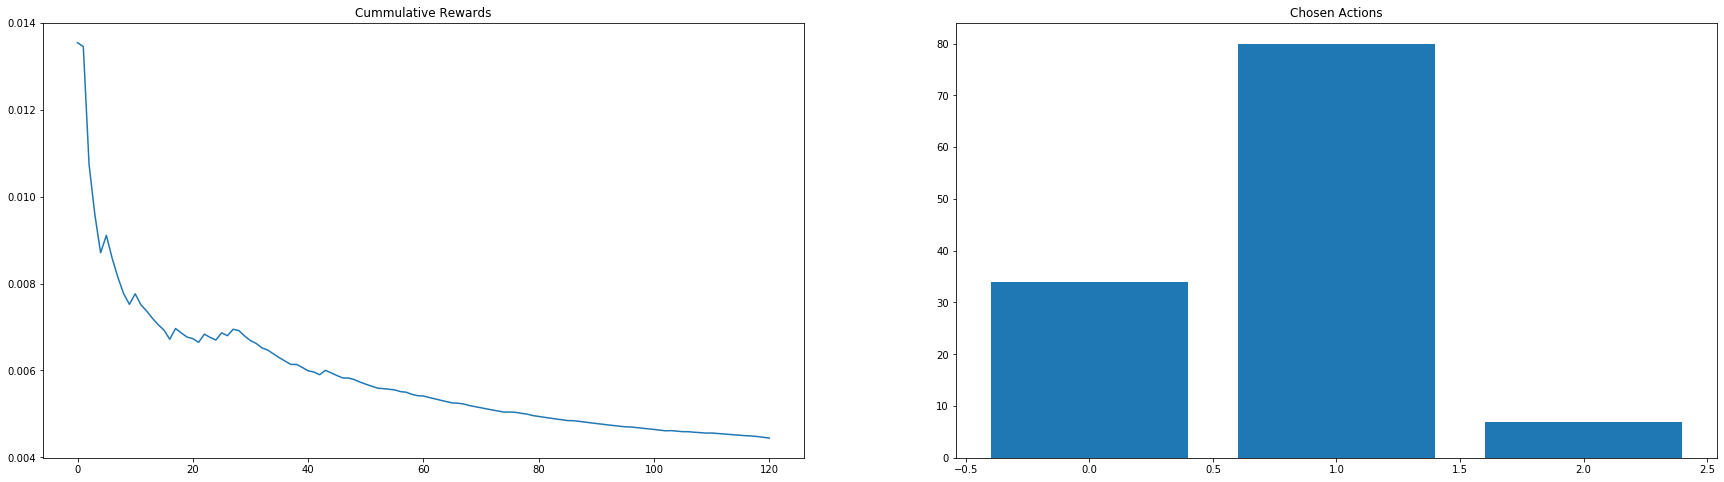

Restart at iteration: 661
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.005300186363663009, 'merge_sort': 0.003399585714413704, 'heap_sort': 0.0}
Count per chosen algo {'quick_sort': 22, 'merge_sort': 21, 'heap_sort': 0}


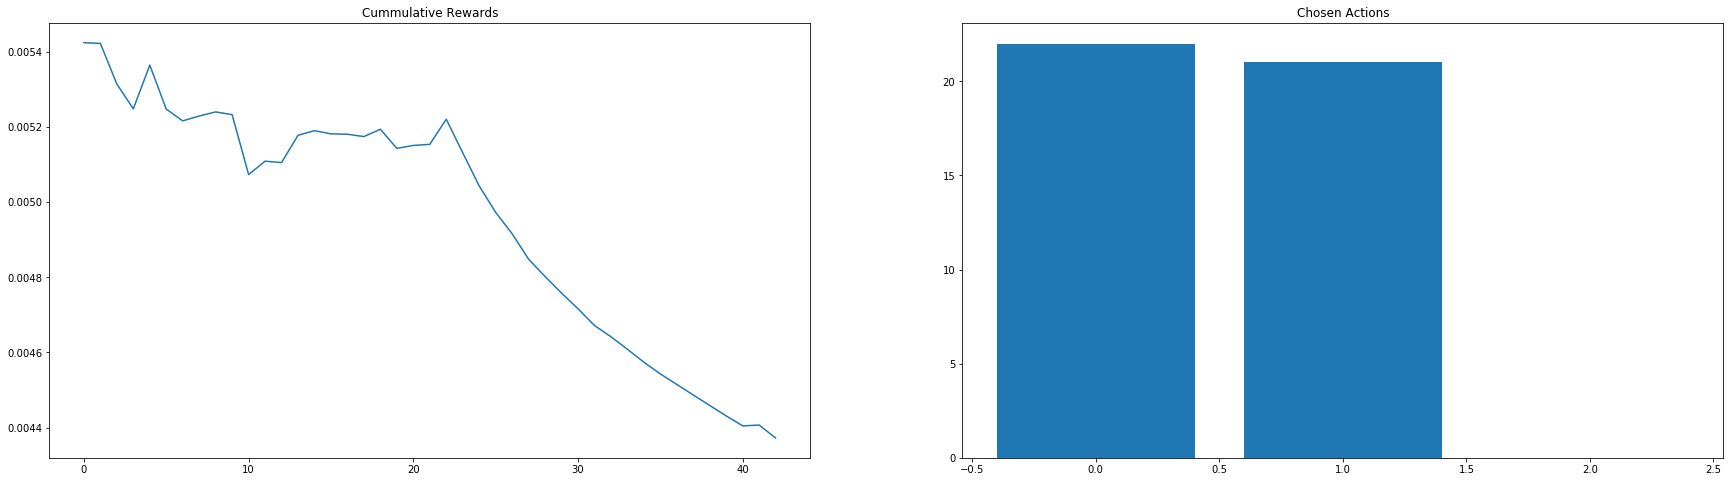

Restart at iteration: 751
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.005187645000000884, 'merge_sort': 0.0034596808510151335, 'heap_sort': 0.011018533333299274}
Count per chosen algo {'quick_sort': 40, 'merge_sort': 47, 'heap_sort': 3}


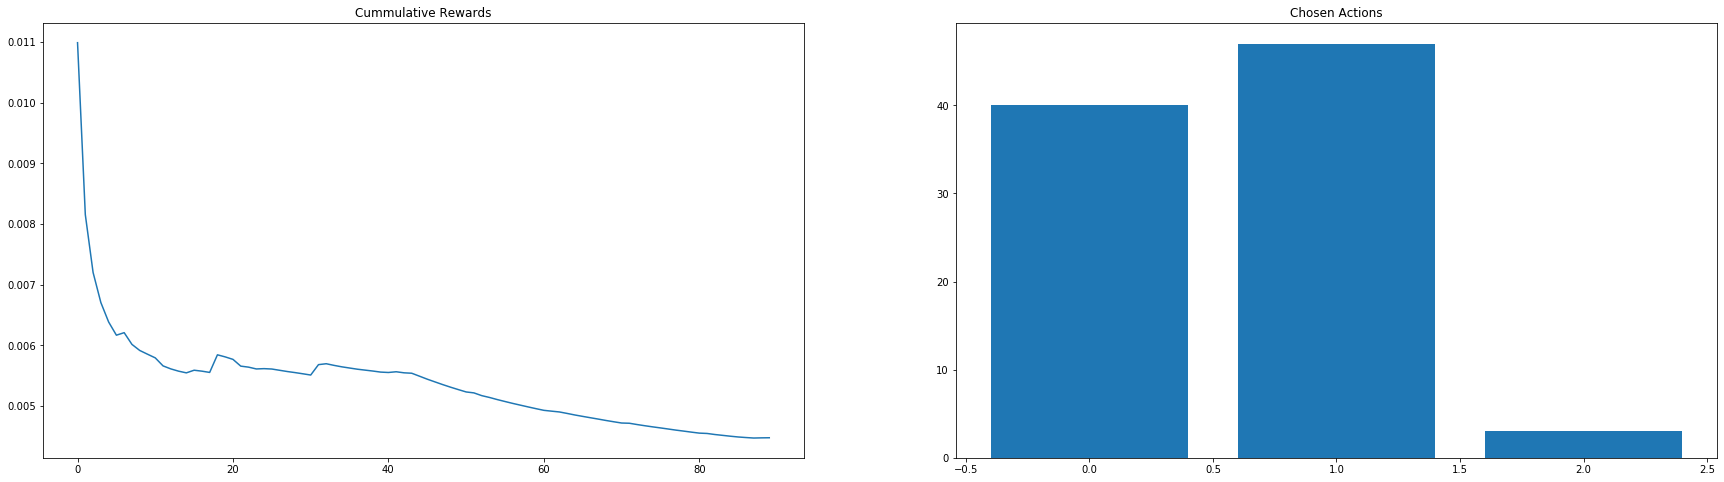

Restart at iteration: 782
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006278906666557305, 'merge_sort': 0.0034391866666434604, 'heap_sort': 0.014760800000658492}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 15, 'heap_sort': 1}


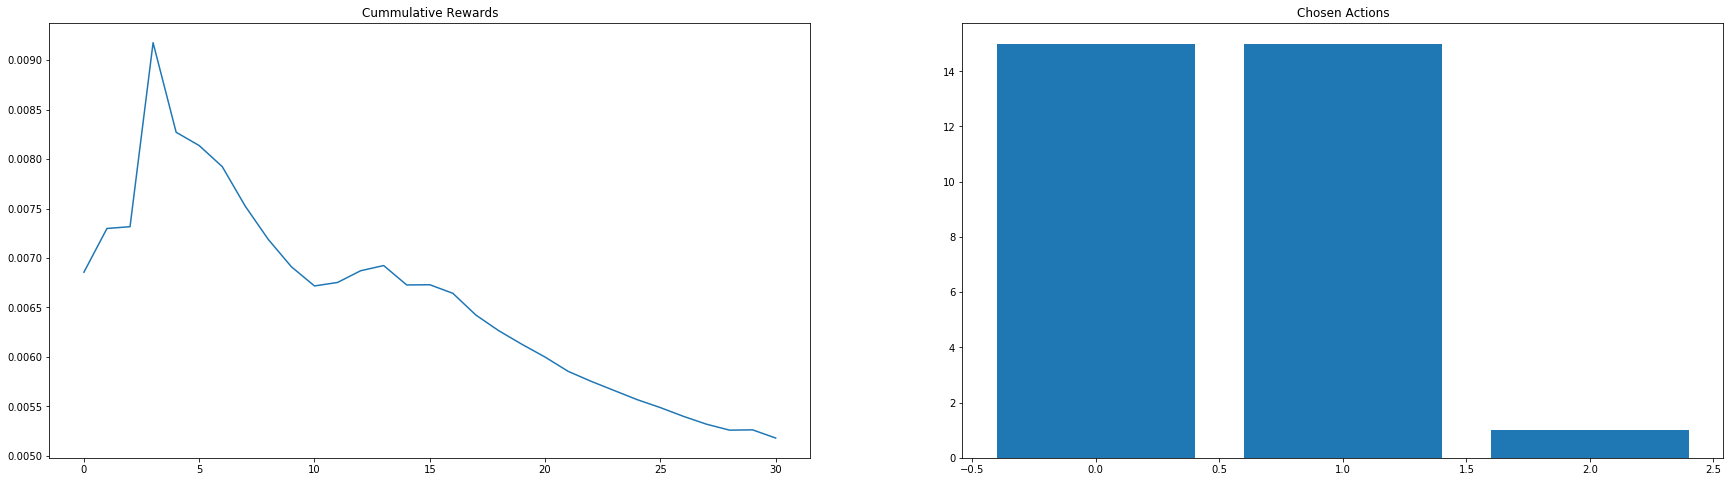

Restart at iteration: 804
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.0033950333333580473, 'heap_sort': 0.01087199999983568}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 21, 'heap_sort': 1}


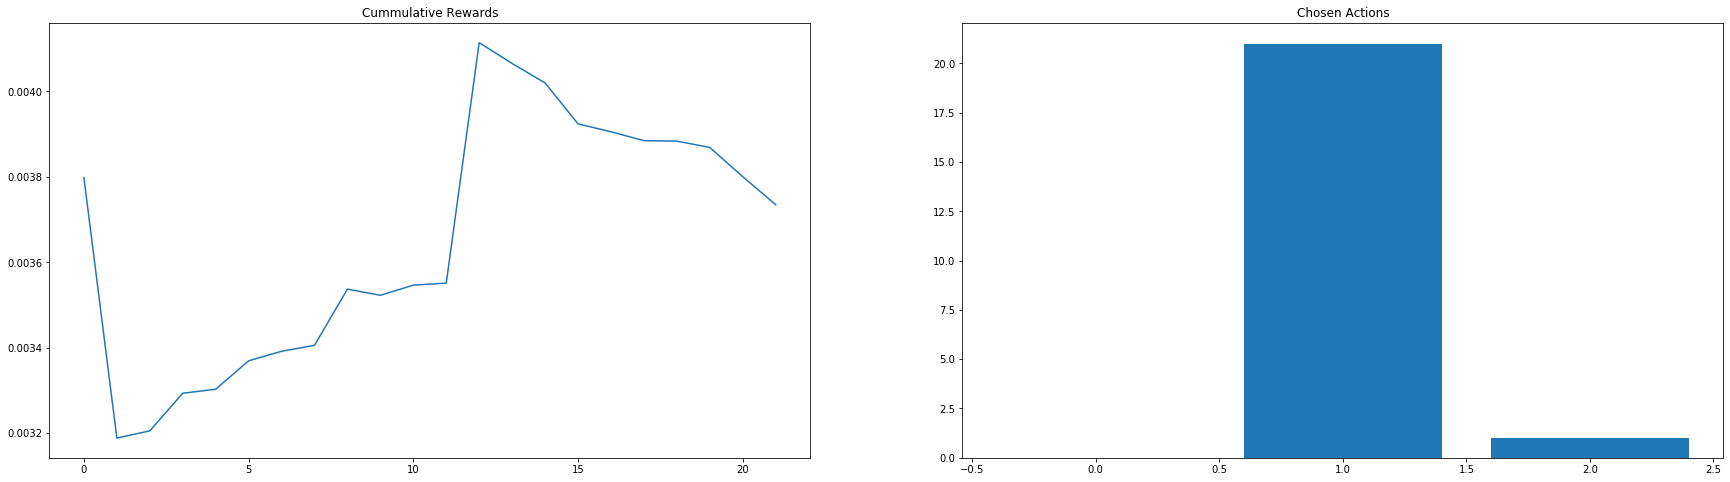

Restart at iteration: 971
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.005209787499893537, 'merge_sort': 0.0033229645161378767, 'heap_sort': 0.011113375000149972}
Count per chosen algo {'quick_sort': 8, 'merge_sort': 155, 'heap_sort': 4}


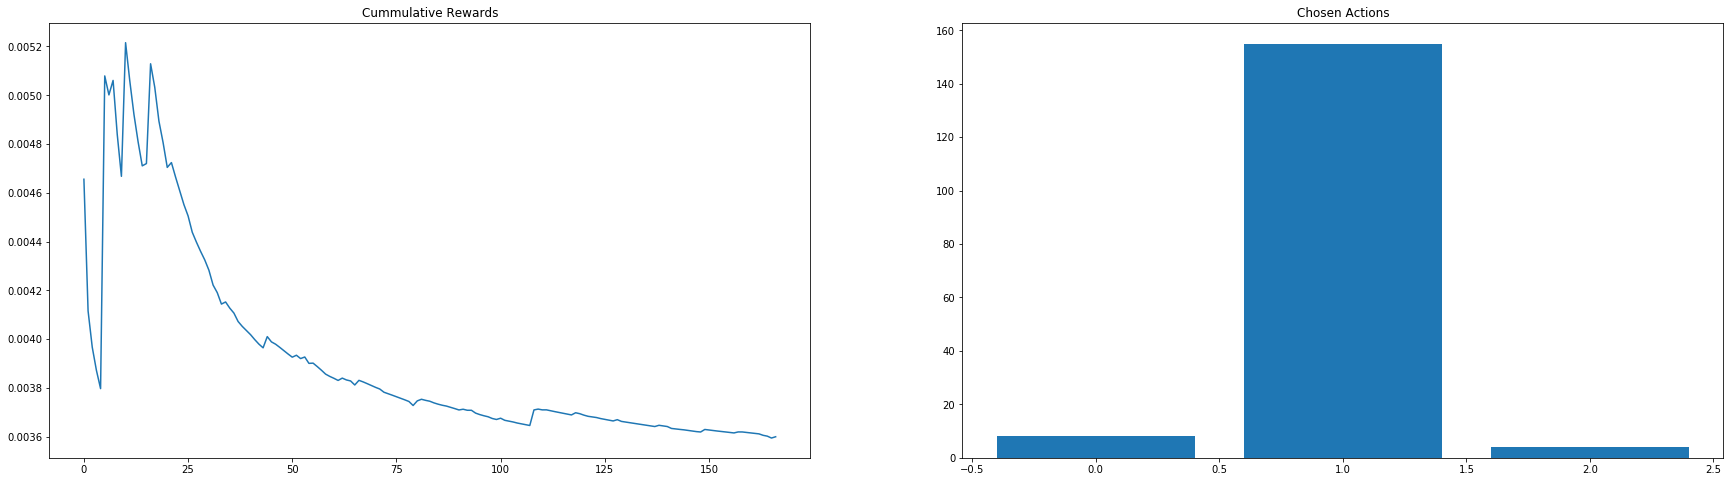

Restart at iteration: 999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.005123599999933504, 'merge_sort': 0.003521395833142075, 'heap_sort': 0.011250399999880756}
Count per chosen algo {'quick_sort': 2, 'merge_sort': 24, 'heap_sort': 2}


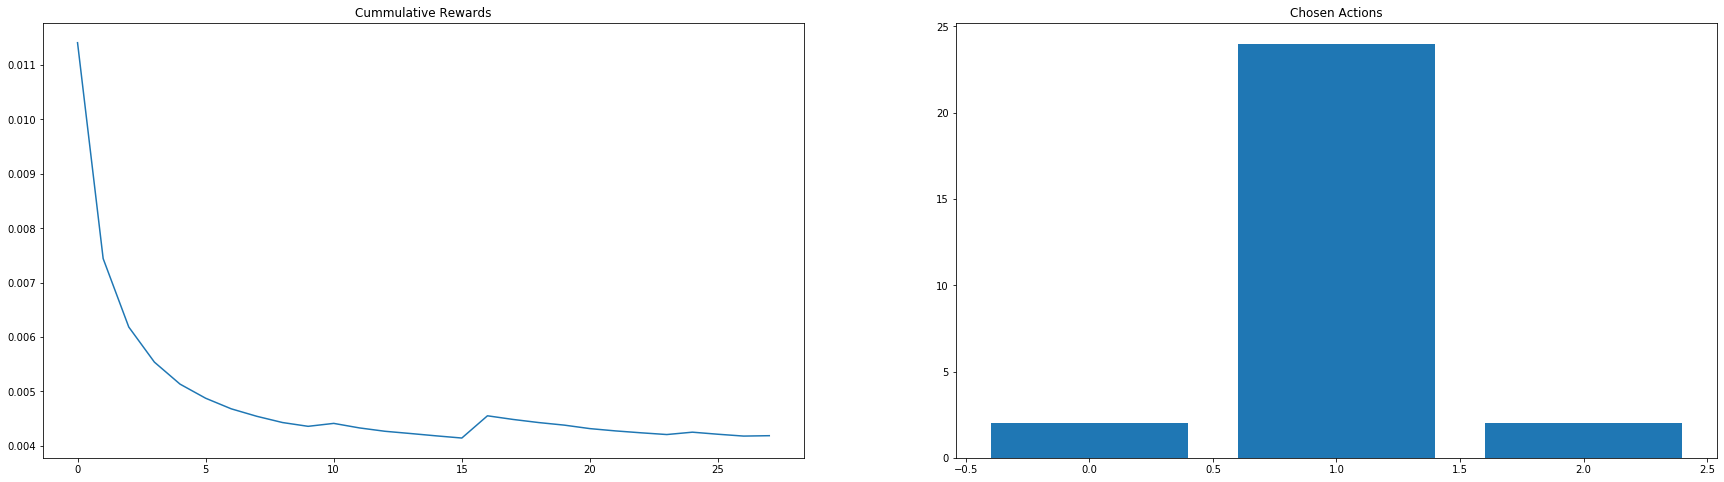

Total reward 9.4793


In [28]:
for elem in list_iteration_results_2:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_2,4))

## Three outliers in a row restart the expriment

In [29]:
list_iteration_results_3, total_reward_3, arm_rewards_3 = ts_quantile(list_distributions, n_samples, num_consec_elem=3)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.028066054689138142
Less than two values for merge_sort
merge_sort Theta 0.017487000930958663
Less than two values for heap_sort
heap_sort Theta 0.047458798316991416


Chosen algorithm is:  merge_sort with reward: 0.015763499999593478
Sample mean is:  0.015763499999593478 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.01319391681240676
Less than two values for merge_sort
merge_sort Theta 0.06805105033746009
Less than two values for heap_sort
heap_sort Theta 0.07071076744735949


Chosen algorithm is:  quick_sort with reward: 0.014309199999843258
Sample mean is:  0.014309199999843258 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.02465411463663686
Less than two values for merge_sort
merge_sort Theta 0.030813446749346964
Less than two values for heap_sort
heap_sort Theta 0.061539657371733086


Chosen algorithm is:  quick_sort wi



Iteration: 26
quick_sort Theta 0.008555124822356725
merge_sort Theta 0.01618350701835909
Less than two values for heap_sort
heap_sort Theta 0.07505448487731652


Chosen algorithm is:  quick_sort with reward: 0.01901700000053097
Sample mean is:  0.01625764999994317 Sample variance is: 1.2305512809558074e-05


Iteration: 27
quick_sort Theta 0.012844588310182642
merge_sort Theta 0.015567693030557977
Less than two values for heap_sort
heap_sort Theta 0.08046179639994751


Chosen algorithm is:  quick_sort with reward: 0.014316199999484525
Sample mean is:  0.01614344705873972 Sample variance is: 1.1790336103350484e-05


Iteration: 28
quick_sort Theta 0.016931722144466085
merge_sort Theta 0.013752463389782577
Less than two values for heap_sort
heap_sort Theta 0.07270139419050985


Chosen algorithm is:  merge_sort with reward: 0.015714899999693444
Sample mean is:  0.016152336363451137 Sample variance is: 7.698856877249607e-07


Iteration: 29
quick_sort Theta 0.017486478417222544
merge_sort T



Chosen algorithm is:  heap_sort with reward: 0.0239237999994657
Sample mean is:  0.022108424999942144 Sample variance is: 1.2366314613088814e-06


Iteration: 56
Less than two values for quick_sort
quick_sort Theta 0.013171454312745225
merge_sort Theta 0.01281858631836707
heap_sort Theta 0.024372295642710415


Chosen algorithm is:  merge_sort with reward: 0.01428710000072897
Sample mean is:  0.014478480000252602 Sample variance is: 2.4955107377388015e-07


Iteration: 57
Less than two values for quick_sort
quick_sort Theta 0.09037488474823538
merge_sort Theta 0.014780502980046614
heap_sort Theta 0.022476572947505706


Chosen algorithm is:  merge_sort with reward: 0.014247500000237778
Sample mean is:  0.014439983333583465 Sample variance is: 2.153691948680735e-07


Iteration: 58
Less than two values for quick_sort
quick_sort Theta 0.06407742339512966
merge_sort Theta 0.014418985717127356
heap_sort Theta 0.022039698306543593


Chosen algorithm is:  merge_sort with reward: 0.0140213999993



Iteration: 90
quick_sort Theta 0.01374914772135991
merge_sort Theta 0.014180000215094466
heap_sort Theta 0.02467505702140238


Chosen algorithm is:  quick_sort with reward: 0.013520900000003166
Sample mean is:  0.01303506190474547 Sample variance is: 1.2622045480442672e-06


Iteration: 91
quick_sort Theta 0.011914408572533305
merge_sort Theta 0.014613212085193852
heap_sort Theta 0.021723045733115925


Chosen algorithm is:  quick_sort with reward: 0.013056699999651755
Sample mean is:  0.013036045454513938 Sample variance is: 1.2048519288153431e-06


Iteration: 92
quick_sort Theta 0.013490533633675254
merge_sort Theta 0.015023117239618388
heap_sort Theta 0.024214556589762022


Chosen algorithm is:  quick_sort with reward: 0.012547199999971781
Sample mean is:  0.013014791304316453 Sample variance is: 1.1624053181586905e-06


Iteration: 93
quick_sort Theta 0.012472024140399229
merge_sort Theta 0.014794281133629322
heap_sort Theta 0.02577031324262635


Chosen algorithm is:  quick_sort wit

merge_sort Theta 0.014304876692529778
heap_sort Theta 0.019941093817494662


Chosen algorithm is:  quick_sort with reward: 0.01756070000010368
Sample mean is:  0.013530787755111564 Sample variance is: 1.2728337187196248e-06


Iteration: 123
quick_sort Theta 0.01523327487501521
merge_sort Theta 0.013944209140984426
heap_sort Theta 0.020234369573689567


Chosen algorithm is:  merge_sort with reward: 0.016133500000250933
Sample mean is:  0.01450606521757436 Sample variance is: 7.497033780809489e-07


Iteration: 124
quick_sort Theta 0.013524105329501393
merge_sort Theta 0.01452163037460204
heap_sort Theta 0.02482828139947878


Chosen algorithm is:  quick_sort with reward: 0.014218499999515188
Sample mean is:  0.013544541999999637 Sample variance is: 1.2566468277148447e-06


Iteration: 125
quick_sort Theta 0.012840616430436845
merge_sort Theta 0.014832058112022907
heap_sort Theta 0.019306550128219


Chosen algorithm is:  quick_sort with reward: 0.01398719999997411
Sample mean is:  0.0135532



Iteration: 153
quick_sort Theta 0.013567170773347598
merge_sort Theta 0.014811200721729858
heap_sort Theta 0.02131437375409008


Chosen algorithm is:  quick_sort with reward: 0.01408869999977469
Sample mean is:  0.013702040540526985 Sample variance is: 9.660651789567826e-07


Iteration: 154
quick_sort Theta 0.013886080432463956
merge_sort Theta 0.014191663027951024
heap_sort Theta 0.02125391384834234


Chosen algorithm is:  quick_sort with reward: 0.012417399999321788
Sample mean is:  0.013684911999977583 Sample variance is: 9.748949406041122e-07


Iteration: 155
quick_sort Theta 0.01363704636339957
merge_sort Theta 0.015713839437666872
heap_sort Theta 0.011683462355220199


Chosen algorithm is:  heap_sort with reward: 0.021365700000387733
Sample mean is:  0.021954783333361167 Sample variance is: 8.98102910923398e-07


Iteration: 156
quick_sort Theta 0.013320630738339714
merge_sort Theta 0.0131591931514319
heap_sort Theta 0.022236353893568546


Chosen algorithm is:  merge_sort with r



Iteration: 188
quick_sort Theta 0.013140492259039528
merge_sort Theta 0.01432481722207432
heap_sort Theta 0.023296860938286118


Chosen algorithm is:  quick_sort with reward: 0.014337399999931222
Sample mean is:  0.013446048571417383 Sample variance is: 9.278663444561677e-07


Iteration: 189
quick_sort Theta 0.013317133813744119
merge_sort Theta 0.014873302415108477
heap_sort Theta 0.017067077399144658


Chosen algorithm is:  quick_sort with reward: 0.013037600000643579
Sample mean is:  0.013442195283013856 Sample variance is: 9.206719106860715e-07


Iteration: 190
quick_sort Theta 0.013253940902852064
merge_sort Theta 0.014177147088649205
heap_sort Theta 0.02194154147530162


Chosen algorithm is:  quick_sort with reward: 0.012442299999747775
Sample mean is:  0.013432850467282398 Sample variance is: 9.213240118976492e-07


Iteration: 191
quick_sort Theta 0.013280819073831879
merge_sort Theta 0.015133027137303409
heap_sort Theta 0.021910468196110054


Chosen algorithm is:  quick_sort 

Chosen algorithm is:  quick_sort with reward: 0.012450999999600754
Sample mean is:  0.013308585185169013 Sample variance is: 8.933314601549519e-07


Iteration: 223
quick_sort Theta 0.013239032777605141
merge_sort Theta 0.01362873818938849
heap_sort Theta 0.02113268591095693


Chosen algorithm is:  quick_sort with reward: 0.014308900000287395
Sample mean is:  0.013315940441162532 Sample variance is: 8.940663182259157e-07


Iteration: 224
quick_sort Theta 0.013048429774282519
merge_sort Theta 0.015522184797091882
heap_sort Theta 0.022840416967188137


Chosen algorithm is:  quick_sort with reward: 0.011782300000049872
Sample mean is:  0.013304745985387986 Sample variance is: 9.045832409580194e-07


Iteration: 225
quick_sort Theta 0.013633248898229713
merge_sort Theta 0.0156716668786533
heap_sort Theta 0.023566912074010016


Chosen algorithm is:  quick_sort with reward: 0.012789800000064133
Sample mean is:  0.013301014492740713 Sample variance is: 8.999358830571871e-07


Iteration: 226
qui

Chosen algorithm is:  quick_sort with reward: 0.012185200000203622
Sample mean is:  0.013205297041404588 Sample variance is: 8.238715473236245e-07


Iteration: 257
quick_sort Theta 0.01355150144565307
merge_sort Theta 0.014597467576950149
heap_sort Theta 0.02344817819399769


Chosen algorithm is:  quick_sort with reward: 0.013348299999961455
Sample mean is:  0.013206138235278452 Sample variance is: 8.191448297096227e-07


Iteration: 258
quick_sort Theta 0.013553280480783905
merge_sort Theta 0.014213031874432364
heap_sort Theta 0.022051640553583624


Chosen algorithm is:  quick_sort with reward: 0.012053200000082143
Sample mean is:  0.013199395906417654 Sample variance is: 8.220825388074593e-07


Iteration: 259
quick_sort Theta 0.012708177638485096
merge_sort Theta 0.014591517330202662
heap_sort Theta 0.02447260519624329


Chosen algorithm is:  quick_sort with reward: 0.01278439999987313
Sample mean is:  0.01319698313951914 Sample variance is: 8.18298456105453e-07


Iteration: 260
quick



Iteration: 290
quick_sort Theta 0.013377612677387907
merge_sort Theta 0.014479368595754358
heap_sort Theta 0.024966358823001106


Chosen algorithm is:  quick_sort with reward: 0.014788299999963783
Sample mean is:  0.013207294088657328 Sample variance is: 9.185630685757297e-07


Iteration: 291
quick_sort Theta 0.013003654009512521
merge_sort Theta 0.014794810470305345
heap_sort Theta 0.023537251794654955


Chosen algorithm is:  quick_sort with reward: 0.013934600000538921
Sample mean is:  0.013210859313715571 Sample variance is: 9.166406068679853e-07


Iteration: 292
quick_sort Theta 0.013195451190067781
merge_sort Theta 0.014803874456307445
heap_sort Theta 0.022507766904591126


Chosen algorithm is:  quick_sort with reward: 0.0127106999998432
Sample mean is:  0.013208419512184487 Sample variance is: 9.133835261017682e-07


Iteration: 293
quick_sort Theta 0.013607299477464448
merge_sort Theta 0.014480981807432016
heap_sort Theta 0.02278092716358411


Chosen algorithm is:  quick_sort w

Sample mean is:  0.013146114042540425 Sample variance is: 8.538364048173332e-07


Iteration: 324
quick_sort Theta 0.012717723649465088
merge_sort Theta 0.01515225529183581
heap_sort Theta 0.024230059169888518


Chosen algorithm is:  quick_sort with reward: 0.013460299999678682
Sample mean is:  0.013147445338968975 Sample variance is: 8.506349562419218e-07


Iteration: 325
quick_sort Theta 0.013051639480577424
merge_sort Theta 0.014885843718985213
heap_sort Theta 0.025552938052318595


Chosen algorithm is:  quick_sort with reward: 0.012827499999730207
Sample mean is:  0.013146095358634636 Sample variance is: 8.474758766804985e-07


Iteration: 326
quick_sort Theta 0.012803410435408906
merge_sort Theta 0.014962922997780995
heap_sort Theta 0.020535766491403346


Chosen algorithm is:  quick_sort with reward: 0.012379699999655713
Sample mean is:  0.013142875210067496 Sample variance is: 8.463725912295186e-07


Iteration: 327
quick_sort Theta 0.013305492154719798
merge_sort Theta 0.0142089029



Iteration: 358
quick_sort Theta 0.013453873416780598
merge_sort Theta 0.0148232704313042
heap_sort Theta 0.02210894265161468


Chosen algorithm is:  quick_sort with reward: 0.014331400000628491
Sample mean is:  0.01310750483270361 Sample variance is: 8.202309755781327e-07


Iteration: 359
quick_sort Theta 0.012832286418670137
merge_sort Theta 0.014249702394735542
heap_sort Theta 0.019126177365249394


Chosen algorithm is:  quick_sort with reward: 0.013287700000546465
Sample mean is:  0.013108172222214139 Sample variance is: 8.173128980320991e-07


Iteration: 360
quick_sort Theta 0.013382791742594118
merge_sort Theta 0.013865658143368315
heap_sort Theta 0.023003193524809097


Chosen algorithm is:  quick_sort with reward: 0.012223999999150692
Sample mean is:  0.013104909594084753 Sample variance is: 8.171710637030904e-07


Iteration: 361
quick_sort Theta 0.012429262159679003
merge_sort Theta 0.015590968950950274
heap_sort Theta 0.024453737481982967


Chosen algorithm is:  quick_sort wi



Iteration: 391
quick_sort Theta 0.012343680349973789
merge_sort Theta 0.014302779250730565
heap_sort Theta 0.022552017987456395


Chosen algorithm is:  quick_sort with reward: 0.014202999999724852
Sample mean is:  0.013078809933766939 Sample variance is: 7.863490778619404e-07


Iteration: 392
quick_sort Theta 0.01308679059750741
merge_sort Theta 0.014740699772858147
heap_sort Theta 0.0210024679124077


Chosen algorithm is:  quick_sort with reward: 0.01261860000067827
Sample mean is:  0.01307729108910328 Sample variance is: 7.844505468957705e-07


Iteration: 393
quick_sort Theta 0.012973312801118117
merge_sort Theta 0.014705982144625429
heap_sort Theta 0.023528585650643856


Chosen algorithm is:  quick_sort with reward: 0.012881999999990512
Sample mean is:  0.013076648684204883 Sample variance is: 7.819951607333982e-07


Iteration: 394
quick_sort Theta 0.013179544159720065
merge_sort Theta 0.015198762881639351
heap_sort Theta 0.0228691164781262


Chosen algorithm is:  quick_sort with 



Chosen algorithm is:  quick_sort with reward: 0.01453029999993305
Sample mean is:  0.01305980830859149 Sample variance is: 7.721770399377661e-07


Iteration: 428
quick_sort Theta 0.013291224002628046
merge_sort Theta 0.014183611337137695
heap_sort Theta 0.023132078650994002


Chosen algorithm is:  quick_sort with reward: 0.013480100000379025
Sample mean is:  0.01306105177513524 Sample variance is: 7.704135649306374e-07


Iteration: 429
quick_sort Theta 0.013251024947495162
merge_sort Theta 0.013156636854100482
heap_sort Theta 0.022921020300421646


Chosen algorithm is:  merge_sort with reward: 0.014278300000114541
Sample mean is:  0.014562407894836246 Sample variance is: 6.522119403267925e-07


Iteration: 430
quick_sort Theta 0.013287117995887924
merge_sort Theta 0.015412475382353012
heap_sort Theta 0.024277831850301124


Chosen algorithm is:  quick_sort with reward: 0.012721299999611801
Sample mean is:  0.013060049557508327 Sample variance is: 7.684804593224441e-07


Iteration: 431




Iteration: 461
quick_sort Theta 0.012597121279486239
merge_sort Theta 0.014572286483283755
heap_sort Theta 0.019562166739235255


Chosen algorithm is:  quick_sort with reward: 0.014694600000439095
Sample mean is:  0.013059715489112517 Sample variance is: 7.757265139905343e-07


Iteration: 462
quick_sort Theta 0.013074589704401228
merge_sort Theta 0.015311441370562864
heap_sort Theta 0.02266850195722252


Chosen algorithm is:  quick_sort with reward: 0.012539400000605383
Sample mean is:  0.013058305420037972 Sample variance is: 7.743559665997771e-07


Iteration: 463
quick_sort Theta 0.013053014557644271
merge_sort Theta 0.014417015813214237
heap_sort Theta 0.020206447196913693


Chosen algorithm is:  quick_sort with reward: 0.012712300000202958
Sample mean is:  0.013057370270254633 Sample variance is: 7.72585805024269e-07


Iteration: 464
quick_sort Theta 0.012985020263370785
merge_sort Theta 0.015605270302987776
heap_sort Theta 0.016718793461296438


Chosen algorithm is:  quick_sort 



Iteration: 497
quick_sort Theta 0.012578935500692827
merge_sort Theta 0.013574195215653456
heap_sort Theta 0.02082951132244128


Chosen algorithm is:  quick_sort with reward: 0.014458900000136055
Sample mean is:  0.013053311194010831 Sample variance is: 7.7523268005328e-07


Iteration: 498
quick_sort Theta 0.013459220616856284
merge_sort Theta 0.014523802501735815
heap_sort Theta 0.01668219159155012


Chosen algorithm is:  quick_sort with reward: 0.012666100000387814
Sample mean is:  0.013052350372190429 Sample variance is: 7.736801435457112e-07


Iteration: 499
quick_sort Theta 0.012701868864392292
merge_sort Theta 0.013422319196502696
heap_sort Theta 0.018217730522795315


Chosen algorithm is:  quick_sort with reward: 0.012551499999972293
Sample mean is:  0.013051110643546323 Sample variance is: 7.723844753111875e-07


Iteration: 500
quick_sort Theta 0.012924783438814428
merge_sort Theta 0.01511934474520267
heap_sort Theta 0.02220205550433518


Chosen algorithm is:  quick_sort with

Less than two values for heap_sort
heap_sort Theta 0.01194774999805589


Chosen algorithm is:  quick_sort with reward: 0.006053799999790499
Sample mean is:  0.005392311111083675 Sample variance is: 9.02817721107382e-08


Iteration: 522
quick_sort Theta 0.005071172334610407
Less than two values for merge_sort
merge_sort Theta 0.06840366466618836
Less than two values for heap_sort
heap_sort Theta 0.021569864443396005


Chosen algorithm is:  quick_sort with reward: 0.00443619999987277
Sample mean is:  0.005341989473651522 Sample variance is: 1.3111090938373846e-07


Iteration: 523
quick_sort Theta 0.005072222509722561
Less than two values for merge_sort
merge_sort Theta 0.008084654045613083
Less than two values for heap_sort
heap_sort Theta 0.06674925878614624


Chosen algorithm is:  quick_sort with reward: 0.00501310000072408
Sample mean is:  0.00532554500000515 Sample variance is: 1.2969335747116983e-07


Iteration: 524
quick_sort Theta 0.0050113264510470885
Less than two values for mer

merge_sort Theta 0.08525017876824674
heap_sort Theta 0.010830769440944158


Chosen algorithm is:  quick_sort with reward: 0.005743599999732396
Sample mean is:  0.005299995238125294 Sample variance is: 1.1661220520285513e-07


Iteration: 548
quick_sort Theta 0.0053170735591405935
Less than two values for merge_sort
merge_sort Theta 0.032025885850723024
heap_sort Theta 0.013555648923386683


Chosen algorithm is:  quick_sort with reward: 0.006433500000639469
Sample mean is:  0.005326355813997716 Sample variance is: 1.4308525178763314e-07


Iteration: 549
quick_sort Theta 0.005417409968064695
Less than two values for merge_sort
merge_sort Theta 0.0833162352500675
heap_sort Theta 0.010071426192864547


Chosen algorithm is:  quick_sort with reward: 0.005254300000160583
Sample mean is:  0.005324718181865054 Sample variance is: 1.3994863332408798e-07


Iteration: 550
quick_sort Theta 0.005375238709728345
Less than two values for merge_sort
merge_sort Theta 0.09758944191979557
heap_sort Theta 0



Chosen algorithm is:  merge_sort with reward: 0.004361299999800394
Sample mean is:  0.003273655555656458 Sample variance is: 2.287780357188141e-07


Iteration: 575
quick_sort Theta 0.005423886181846664
merge_sort Theta 0.004001195390382321
heap_sort Theta 0.010830361672449077


Chosen algorithm is:  merge_sort with reward: 0.0025531000001137727
Sample mean is:  0.0032016000001021893 Sample variance is: 2.526282599230412e-07


Iteration: 576
quick_sort Theta 0.0054879961225541545
merge_sort Theta 0.003446851574745107
heap_sort Theta 0.01271475891780452


Chosen algorithm is:  merge_sort with reward: 0.0030658000005132635
Sample mean is:  0.0031892545455941054 Sample variance is: 2.3118615694560373e-07


Iteration: 577
quick_sort Theta 0.005176237670875057
merge_sort Theta 0.003921137810225584
heap_sort Theta 0.012547665917536076


Chosen algorithm is:  merge_sort with reward: 0.0033078000005843933
Sample mean is:  0.0031991333335099625 Sample variance is: 2.129941388243548e-07


Itera

quick_sort Theta 0.00512522908107437
merge_sort Theta 0.002758381355447544
heap_sort Theta 0.011324815469401896


Chosen algorithm is:  merge_sort with reward: 0.0036342999992484692
Sample mean is:  0.0033273829787233014 Sample variance is: 1.5119685163580846e-07


Iteration: 613
quick_sort Theta 0.00522866501460276
merge_sort Theta 0.0031838522996552304
heap_sort Theta 0.011694696459825649


Chosen algorithm is:  merge_sort with reward: 0.00426309999966179
Sample mean is:  0.0033468770833261865 Sample variance is: 1.659078625973359e-07


Iteration: 614
quick_sort Theta 0.005157833948330296
merge_sort Theta 0.003787913367389752
heap_sort Theta 0.012427594277333871


Chosen algorithm is:  merge_sort with reward: 0.0031799999997019768
Sample mean is:  0.0033434714285583457 Sample variance is: 1.63078715101542e-07


Iteration: 615
quick_sort Theta 0.005097941192336502
merge_sort Theta 0.0033665797748322463
heap_sort Theta 0.012708608633110735


Chosen algorithm is:  merge_sort with reward



Chosen algorithm is:  merge_sort with reward: 0.0050602000001163105
Sample mean is:  0.003330693975939024 Sample variance is: 2.0615932587947677e-07


Iteration: 650
quick_sort Theta 0.005117822060628743
merge_sort Theta 0.0032637461228192327
heap_sort Theta 0.010928539405674372


Chosen algorithm is:  merge_sort with reward: 0.003385099999832164
Sample mean is:  0.0033313416666996567 Sample variance is: 2.0373986696611235e-07


Iteration: 651
quick_sort Theta 0.0054495602217710165
merge_sort Theta 0.003241034668331781
heap_sort Theta 0.00970900334070143


Chosen algorithm is:  merge_sort with reward: 0.0027871000002051005
Sample mean is:  0.0033249388235644267 Sample variance is: 2.0478662497275279e-07


Iteration: 652
quick_sort Theta 0.005207321879152653
merge_sort Theta 0.003229694829675872
heap_sort Theta 0.009815881218461473


Chosen algorithm is:  merge_sort with reward: 0.003359999999702268
Sample mean is:  0.0033253465116590527 Sample variance is: 2.024195129620007e-07


Ite



Chosen algorithm is:  merge_sort with reward: 0.00440820000039821
Sample mean is:  0.003339595000003707 Sample variance is: 2.0203442964301245e-07


Iteration: 687
quick_sort Theta 0.005707617099057447
merge_sort Theta 0.003260415426064939
heap_sort Theta 0.010805881994348914


Chosen algorithm is:  merge_sort with reward: 0.0029554000002463
Sample mean is:  0.003336419834716456 Sample variance is: 2.0157452456506875e-07


Iteration: 688
quick_sort Theta 0.0050963703452244135
merge_sort Theta 0.0027993153912746205
heap_sort Theta 0.01118449946575603


Chosen algorithm is:  merge_sort with reward: 0.0030261000001701177
Sample mean is:  0.003333876229515256 Sample variance is: 2.0070513558148358e-07


Iteration: 689
quick_sort Theta 0.005464140163399151
merge_sort Theta 0.0033323218747895716
heap_sort Theta 0.013636282675220521


Chosen algorithm is:  merge_sort with reward: 0.00329890000011801
Sample mean is:  0.0033335918699266606 Sample variance is: 1.9908325147754187e-07


Iteratio



Chosen algorithm is:  merge_sort with reward: 0.004388399999697867
Sample mean is:  0.0033394778481032274 Sample variance is: 1.8093203120744724e-07


Iteration: 725
quick_sort Theta 0.004912874169941316
merge_sort Theta 0.0031680490846900606
heap_sort Theta 0.009351825220636623


Chosen algorithm is:  merge_sort with reward: 0.004167300000517571
Sample mean is:  0.003344684276734764 Sample variance is: 1.840769839613109e-07


Iteration: 726
quick_sort Theta 0.005124949686071745
merge_sort Theta 0.00333644077826762
heap_sort Theta 0.009549919483783963


Chosen algorithm is:  merge_sort with reward: 0.0032269000002997927
Sample mean is:  0.0033439481250070457 Sample variance is: 1.8301266799078215e-07


Iteration: 727
quick_sort Theta 0.005252596816315557
merge_sort Theta 0.0034589909715675845
heap_sort Theta 0.011154122809872257


Chosen algorithm is:  merge_sort with reward: 0.003293400000075053
Sample mean is:  0.0033436341614981515 Sample variance is: 1.818917150384634e-07


Itera

merge_sort Theta 0.0031558531674845333
heap_sort Theta 0.009957202951804616


Chosen algorithm is:  merge_sort with reward: 0.004265599999598635
Sample mean is:  0.0033437448979542267 Sample variance is: 1.781520746063719e-07


Iteration: 763
quick_sort Theta 0.0050194803105851095
merge_sort Theta 0.003451690572608679
heap_sort Theta 0.011221897622382576


Chosen algorithm is:  merge_sort with reward: 0.0028986999996050145
Sample mean is:  0.003341485786795094 Sample variance is: 1.7824805166750958e-07


Iteration: 764
quick_sort Theta 0.0051020000641734085
merge_sort Theta 0.003430485772136008
heap_sort Theta 0.01154441482030582


Chosen algorithm is:  merge_sort with reward: 0.0032565000001341105
Sample mean is:  0.0033410565656503415 Sample variance is: 1.7738410244816735e-07


Iteration: 765
quick_sort Theta 0.005520785593591137
merge_sort Theta 0.0033452836712817113
heap_sort Theta 0.01149022264658464


Chosen algorithm is:  merge_sort with reward: 0.0033145000006697956
Sample mea



Chosen algorithm is:  merge_sort with reward: 0.00426439999955619
Sample mean is:  0.0033417755364758086 Sample variance is: 1.766638814921643e-07


Iteration: 800
quick_sort Theta 0.005659760131692259
merge_sort Theta 0.0034604951624632426
heap_sort Theta 0.010418907992396021


Chosen algorithm is:  merge_sort with reward: 0.0033036000004358357
Sample mean is:  0.0033416123931593986 Sample variance is: 1.7591510910744734e-07


Iteration: 801
quick_sort Theta 0.005293317689165382
merge_sort Theta 0.0033521211392327733
heap_sort Theta 0.011822191886899758


Chosen algorithm is:  merge_sort with reward: 0.003432599999541708
Sample mean is:  0.0033419995744631533 Sample variance is: 1.7520161296577784e-07


Iteration: 802
quick_sort Theta 0.0054650593610571134
merge_sort Theta 0.003075777925044306
heap_sort Theta 0.011742864878771643


Chosen algorithm is:  merge_sort with reward: 0.0023361000003205845
Sample mean is:  0.0033377372881320407 Sample variance is: 1.787284981703926e-07


It



Chosen algorithm is:  merge_sort with reward: 0.004353399999672547
Sample mean is:  0.0033425162962885226 Sample variance is: 1.7814709200776923e-07


Iteration: 837
quick_sort Theta 0.005295749220198462
merge_sort Theta 0.0032892272291739845
heap_sort Theta 0.011095387149893995


Chosen algorithm is:  merge_sort with reward: 0.0031742999999551103
Sample mean is:  0.0033418955719478087 Sample variance is: 1.7759375331549886e-07


Iteration: 838
quick_sort Theta 0.0050213942091472475
merge_sort Theta 0.0032697802877541733
heap_sort Theta 0.010051152936309359


Chosen algorithm is:  merge_sort with reward: 0.0026039000003947876
Sample mean is:  0.003339182352934746 Sample variance is: 1.7893581716366088e-07


Iteration: 839
quick_sort Theta 0.005186928898810736
merge_sort Theta 0.0033140022667334968
heap_sort Theta 0.012979878682061062


Chosen algorithm is:  merge_sort with reward: 0.003288000000793545
Sample mean is:  0.003338994871791372 Sample variance is: 1.7828993518666874e-07






Chosen algorithm is:  merge_sort with reward: 0.004415100000187522
Sample mean is:  0.003342897087373685 Sample variance is: 1.7163561482646796e-07


Iteration: 876
quick_sort Theta 0.004908443012164108
merge_sort Theta 0.0034024438365656577
heap_sort Theta 0.01079296720649118


Chosen algorithm is:  merge_sort with reward: 0.0028497000002971618
Sample mean is:  0.0033413061290282773 Sample variance is: 1.7186407642599277e-07


Iteration: 877
quick_sort Theta 0.005321040574981492
merge_sort Theta 0.0033493648387341386
heap_sort Theta 0.012508126042312027


Chosen algorithm is:  merge_sort with reward: 0.003120399999716028
Sample mean is:  0.00334059581993081 Sample variance is: 1.7146786591122875e-07


Iteration: 878
quick_sort Theta 0.005102868449721482
merge_sort Theta 0.00339037155105361
heap_sort Theta 0.010488555830434579


Chosen algorithm is:  merge_sort with reward: 0.0033056000002034125
Sample mean is:  0.0033404836538419402 Sample variance is: 1.7092220218091765e-07


Itera

quick_sort Theta 0.005255074440608396
merge_sort Theta 0.003513848458983361
heap_sort Theta 0.011145488840664691


Chosen algorithm is:  merge_sort with reward: 0.004085999999915657
Sample mean is:  0.003345175504319749 Sample variance is: 1.6682763555277883e-07


Iteration: 914
quick_sort Theta 0.004894741809411851
merge_sort Theta 0.0033453791804407044
heap_sort Theta 0.011842091040417462


Chosen algorithm is:  merge_sort with reward: 0.0032831999997142702
Sample mean is:  0.0033449974137892734 Sample variance is: 1.6635925132969789e-07


Iteration: 915
quick_sort Theta 0.0052585954207055585
merge_sort Theta 0.003490426395773667
heap_sort Theta 0.011444059655175119


Chosen algorithm is:  merge_sort with reward: 0.0029912999998487066
Sample mean is:  0.0033439839541504752 Sample variance is: 1.6624000821005656e-07


Iteration: 916
quick_sort Theta 0.00519629816814269
merge_sort Theta 0.0033699173115921952
heap_sort Theta 0.011227658413422903


Chosen algorithm is:  merge_sort with r

merge_sort Theta 0.0033604555425339614
heap_sort Theta 0.011894347392410234


Chosen algorithm is:  merge_sort with reward: 0.003997199999503209
Sample mean is:  0.00334630364582722 Sample variance is: 1.6714363252089323e-07


Iteration: 951
quick_sort Theta 0.005350805084403868
merge_sort Theta 0.0033870772827519
heap_sort Theta 0.01177840519464745


Chosen algorithm is:  merge_sort with reward: 0.0032789999995657126
Sample mean is:  0.0033461288311616055 Sample variance is: 1.6672122831989267e-07


Iteration: 952
quick_sort Theta 0.005507132103879282
merge_sort Theta 0.0034617101748115387
heap_sort Theta 0.007271003138401169


Chosen algorithm is:  merge_sort with reward: 0.002898099999583792
Sample mean is:  0.003344968134706741 Sample variance is: 1.6680798629950044e-07


Iteration: 953
quick_sort Theta 0.00516207799177689
merge_sort Theta 0.0033289934491386552
heap_sort Theta 0.011155732192682856


Chosen algorithm is:  merge_sort with reward: 0.0033152000005429727
Sample mean is:



Chosen algorithm is:  merge_sort with reward: 0.004468099999940023
Sample mean is:  0.0033432658767662223 Sample variance is: 1.702547537013809e-07


Iteration: 989
quick_sort Theta 0.005159185698233528
merge_sort Theta 0.0034704878031418247
heap_sort Theta 0.010904430510957637


Chosen algorithm is:  merge_sort with reward: 0.00316949999978533
Sample mean is:  0.0033428550827308066 Sample variance is: 1.6992347342789563e-07


Iteration: 990
quick_sort Theta 0.004948438944458818
merge_sort Theta 0.003467256790445846
heap_sort Theta 0.012525342951791247


Chosen algorithm is:  merge_sort with reward: 0.0025061999995159567
Sample mean is:  0.0033408818396100165 Sample variance is: 1.711697407178813e-07


Iteration: 991
quick_sort Theta 0.005199886871807136
merge_sort Theta 0.0033509563369335596
heap_sort Theta 0.011332319682865324


Chosen algorithm is:  merge_sort with reward: 0.002751999999418331
Sample mean is:  0.003339496235280154 Sample variance is: 1.7158102571496864e-07


Itera

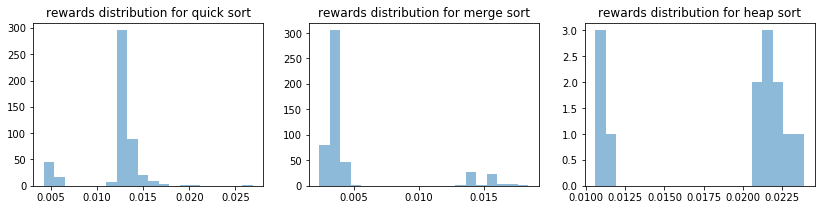

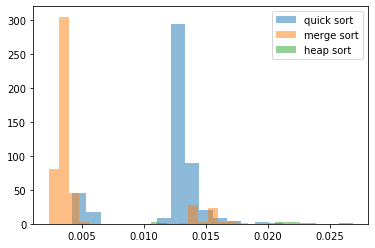

In [30]:
plot_rewards_distribution(arm_rewards_3)
plot_rewards_distribution_together(arm_rewards_3)

Restart at iteration: 46
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.0155452639998839, 'merge_sort': 0.01609337619031846, 'heap_sort': 0.022764700000152516}
Count per chosen algo {'quick_sort': 25, 'merge_sort': 21, 'heap_sort': 1}


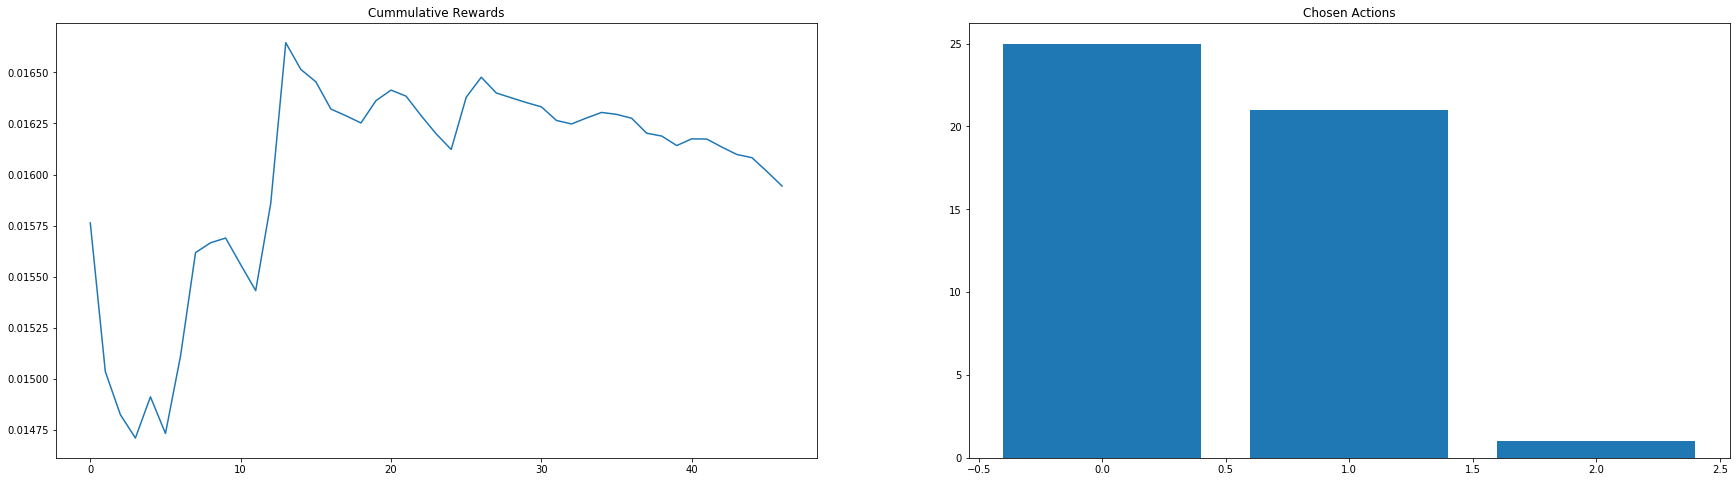

Restart at iteration: 502
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.013010803940866976, 'merge_sort': 0.014260557142950433, 'heap_sort': 0.021768537500065577}
Count per chosen algo {'quick_sort': 406, 'merge_sort': 42, 'heap_sort': 8}


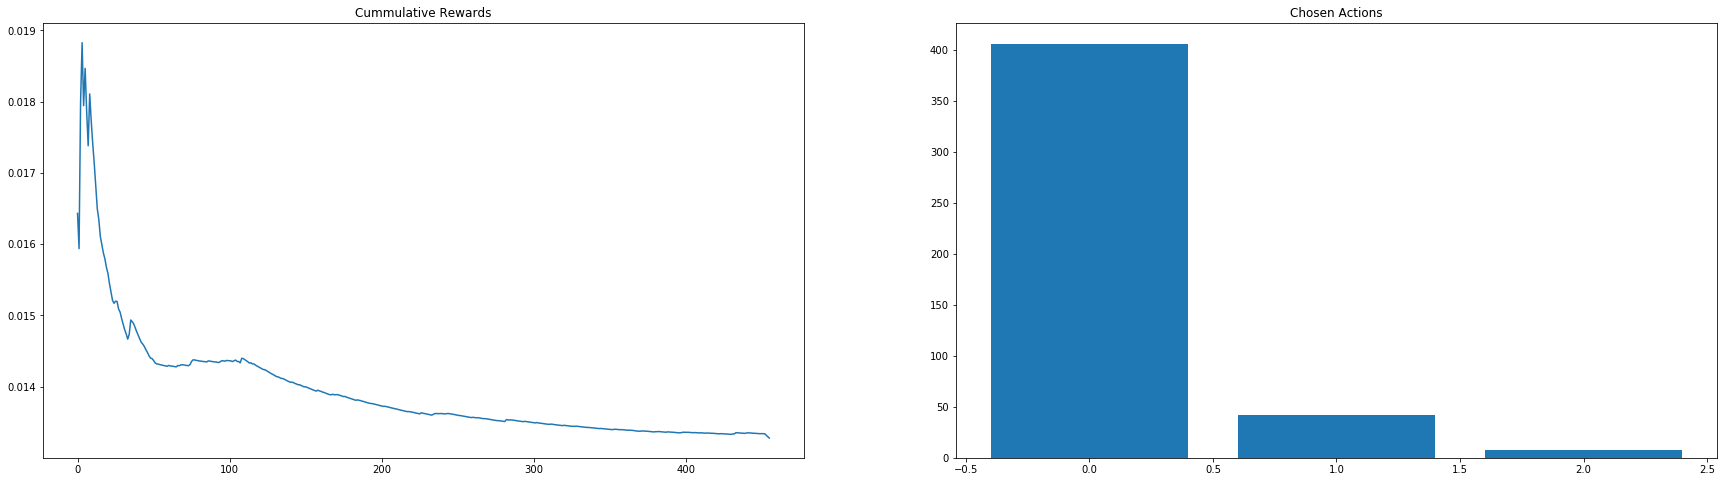

Restart at iteration: 999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.005282261666722358, 'merge_sort': 0.0033419078521815765, 'heap_sort': 0.011017199999969307}
Count per chosen algo {'quick_sort': 60, 'merge_sort': 433, 'heap_sort': 4}


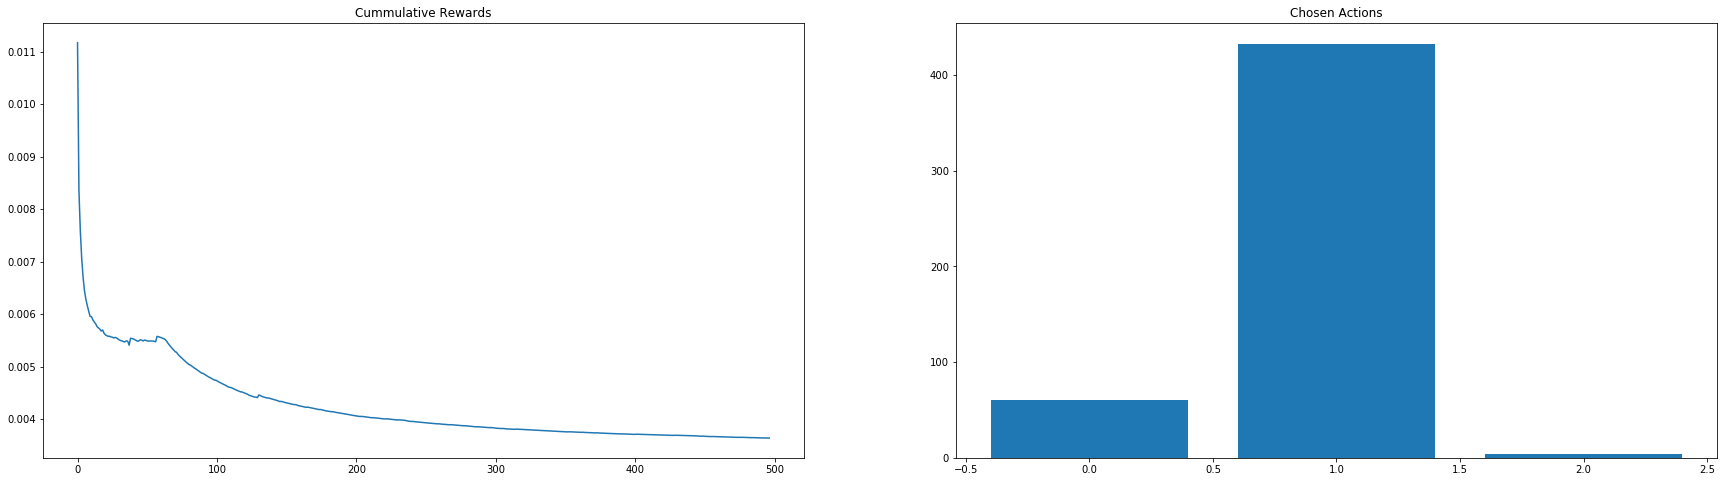

Total reward 8.6129


In [31]:
for elem in list_iteration_results_3:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_3,4))

## Four outliers in a row restart the expriment

In [32]:
list_iteration_results_4, total_reward_4, arm_rewards_4 = ts_quantile(list_distributions, n_samples, num_consec_elem=4)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.07175898511524927
Less than two values for merge_sort
merge_sort Theta 0.023706524146409426
Less than two values for heap_sort
heap_sort Theta 0.04838668133766001


Chosen algorithm is:  merge_sort with reward: 0.022167799999806448
Sample mean is:  0.022167799999806448 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.031061687639793736
Less than two values for merge_sort
merge_sort Theta 0.07676838647198367
Less than two values for heap_sort
heap_sort Theta 0.0008645714048545194


Chosen algorithm is:  heap_sort with reward: 0.02260489999935089
Sample mean is:  0.02260489999935089 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.07758364372689153
Less than two values for merge_sort
merge_sort Theta 0.0001462480190783544
Less than two values for heap_sort
heap_sort Theta 0.06913166263457926


Chosen algorithm is:  merge_sort with

quick_sort Theta 0.015099765045616668
merge_sort Theta 0.01976955967743827
heap_sort Theta 0.023910108042091618


Chosen algorithm is:  quick_sort with reward: 0.017770299999938288
Sample mean is:  0.014397075000109302 Sample variance is: 3.042111499691305e-06


Iteration: 33
quick_sort Theta 0.016657397442082812
merge_sort Theta 0.015490255594586572
heap_sort Theta 0.023881427585731602


Chosen algorithm is:  merge_sort with reward: 0.0163460000003397
Sample mean is:  0.01627921578959726 Sample variance is: 4.578637758140117e-06


Iteration: 34
quick_sort Theta 0.013739846353131606
merge_sort Theta 0.01755064504100809
heap_sort Theta 0.01928418681604063


Chosen algorithm is:  quick_sort with reward: 0.01594230000046082
Sample mean is:  0.014515938461674803 Sample variance is: 2.9776451927359748e-06


Iteration: 35
quick_sort Theta 0.016054759941390478
merge_sort Theta 0.015667518556905916
heap_sort Theta 0.02214475991613105


Chosen algorithm is:  merge_sort with reward: 0.0162835999



Iteration: 62
quick_sort Theta 0.014434223748262613
merge_sort Theta 0.018232403168343313
heap_sort Theta 0.027650213945121644


Chosen algorithm is:  quick_sort with reward: 0.01617459999943094
Sample mean is:  0.014543324242450499 Sample variance is: 1.5452487397864016e-06


Iteration: 63
quick_sort Theta 0.014919695779355414
merge_sort Theta 0.01657299434651258
heap_sort Theta 0.02148273270376518


Chosen algorithm is:  quick_sort with reward: 0.01424349999979313
Sample mean is:  0.01453450588237234 Sample variance is: 1.5023664420971884e-06


Iteration: 64
quick_sort Theta 0.014523229598639917
merge_sort Theta 0.015803010861729506
heap_sort Theta 0.02187576861534108


Chosen algorithm is:  quick_sort with reward: 0.014325200000712357
Sample mean is:  0.014528525714324912 Sample variance is: 1.4606576085444637e-06


Iteration: 65
quick_sort Theta 0.015949778838809405
merge_sort Theta 0.01691905126664487
heap_sort Theta 0.022019140833675947


Chosen algorithm is:  quick_sort with r



Iteration: 96
quick_sort Theta 0.01499497204180989
merge_sort Theta 0.015377940210013138
heap_sort Theta 0.024872186219475723


Chosen algorithm is:  quick_sort with reward: 0.015443799999957264
Sample mean is:  0.014714580327906377 Sample variance is: 1.7805029585899725e-06


Iteration: 97
quick_sort Theta 0.014506042394154013
merge_sort Theta 0.014344605770137728
heap_sort Theta 0.028046294645476203


Chosen algorithm is:  merge_sort with reward: 0.0157496000001629
Sample mean is:  0.016107267647171016 Sample variance is: 2.7621478157208595e-06


Iteration: 98
quick_sort Theta 0.013877973892404503
merge_sort Theta 0.014336722373310018
heap_sort Theta 0.020495625742516153


Chosen algorithm is:  quick_sort with reward: 0.015199499999653199
Sample mean is:  0.014722401612934552 Sample variance is: 1.7555166914043043e-06


Iteration: 99
quick_sort Theta 0.013863611899453301
merge_sort Theta 0.015434641440445823
heap_sort Theta 0.023232566941758893


Chosen algorithm is:  quick_sort wi



Chosen algorithm is:  merge_sort with reward: 0.019931499999984226
Sample mean is:  0.016282028571497773 Sample variance is: 2.8196943196808427e-06


Iteration: 127
quick_sort Theta 0.01487700331541865
merge_sort Theta 0.015101438864548506
heap_sort Theta 0.03069176419449567


Chosen algorithm is:  quick_sort with reward: 0.014663799999652838
Sample mean is:  0.014727764634166883 Sample variance is: 1.6893760239664837e-06


Iteration: 128
quick_sort Theta 0.014539888986111459
merge_sort Theta 0.015912406532699427
heap_sort Theta 0.016100860787350124


Chosen algorithm is:  quick_sort with reward: 0.014889799999764364
Sample mean is:  0.014729716867487334 Sample variance is: 1.669334615591761e-06


Iteration: 129
quick_sort Theta 0.014696878236270819
merge_sort Theta 0.017257670973994325
heap_sort Theta 0.022917835320332283


Chosen algorithm is:  quick_sort with reward: 0.014242099999137281
Sample mean is:  0.01472391190476888 Sample variance is: 1.652258484603262e-06


Iteration: 13

quick_sort Theta 0.01475209346288366
merge_sort Theta 0.017859842168005007
heap_sort Theta 0.023866849321427516


Chosen algorithm is:  quick_sort with reward: 0.016818699999930686
Sample mean is:  0.01473232990656045 Sample variance is: 1.6131518348872613e-06


Iteration: 157
quick_sort Theta 0.015864768560460707
merge_sort Theta 0.01890237012639812
heap_sort Theta 0.023910555433818616


Chosen algorithm is:  quick_sort with reward: 0.015079899999363988
Sample mean is:  0.014735548148160483 Sample variance is: 1.599323451276082e-06


Iteration: 158
quick_sort Theta 0.01396243090130937
merge_sort Theta 0.014502157762509581
heap_sort Theta 0.0239126106981907


Chosen algorithm is:  quick_sort with reward: 0.0140666000006604
Sample mean is:  0.014729411009192592 Sample variance is: 1.58871852233135e-06


Iteration: 159
quick_sort Theta 0.013397485419013805
merge_sort Theta 0.01585065527242881
heap_sort Theta 0.02546255282994606


Chosen algorithm is:  quick_sort with reward: 0.0142149999

quick_sort Theta 0.015525795880651679
merge_sort Theta 0.016669974740609564
heap_sort Theta 0.024603832442296455


Chosen algorithm is:  quick_sort with reward: 0.016933400000198162
Sample mean is:  0.014720282733839844 Sample variance is: 1.4766776524200485e-06


Iteration: 190
quick_sort Theta 0.014508226492916422
merge_sort Theta 0.01685318170034623
heap_sort Theta 0.023501488657109992


Chosen algorithm is:  quick_sort with reward: 0.014145899999675748
Sample mean is:  0.014716180000024386 Sample variance is: 1.468469661944472e-06


Iteration: 191
quick_sort Theta 0.014861877798203731
merge_sort Theta 0.0159900933669422
heap_sort Theta 0.02104933786380962


Chosen algorithm is:  quick_sort with reward: 0.014166199999635865
Sample mean is:  0.014712279432645744 Sample variance is: 1.4601850031135108e-06


Iteration: 192
quick_sort Theta 0.01393149993648171
merge_sort Theta 0.01607877806492098
heap_sort Theta 0.02420961515171646


Chosen algorithm is:  quick_sort with reward: 0.01578

Chosen algorithm is:  quick_sort with reward: 0.014394400000128371
Sample mean is:  0.014699319753095484 Sample variance is: 1.3527644767050123e-06


Iteration: 220
quick_sort Theta 0.015610863625601806
merge_sort Theta 0.015460147146831924
heap_sort Theta 0.023071338677322934


Chosen algorithm is:  merge_sort with reward: 0.018611699999382836
Sample mean is:  0.01630802777786071 Sample variance is: 2.4468397411942146e-06


Iteration: 221
quick_sort Theta 0.014571722106922876
merge_sort Theta 0.015830253726047176
heap_sort Theta 0.020729477925477933


Chosen algorithm is:  quick_sort with reward: 0.014519400000608584
Sample mean is:  0.014698215950932987 Sample variance is: 1.3446626855689267e-06


Iteration: 222
quick_sort Theta 0.014874775787078576
merge_sort Theta 0.015405170861072558
heap_sort Theta 0.023921026470146604


Chosen algorithm is:  quick_sort with reward: 0.014107099999819184
Sample mean is:  0.014694611585377416 Sample variance is: 1.3385811293745286e-06


Iteration: 



Iteration: 249
quick_sort Theta 0.012527033495082175
Less than two values for merge_sort
merge_sort Theta 0.06353733141785282
heap_sort Theta 0.019624105138331592


Chosen algorithm is:  quick_sort with reward: 0.014546400000654103
Sample mean is:  0.013327770588201768 Sample variance is: 5.928264575680137e-07


Iteration: 250
quick_sort Theta 0.013154126396577072
Less than two values for merge_sort
merge_sort Theta 0.0710794506422238
heap_sort Theta 0.017077907420137185


Chosen algorithm is:  quick_sort with reward: 0.013146799999958603
Sample mean is:  0.013317716666632704 Sample variance is: 5.616100371313781e-07


Iteration: 251
quick_sort Theta 0.013531818410681549
Less than two values for merge_sort
merge_sort Theta 0.08465140022335321
heap_sort Theta 0.029696519206134055


Chosen algorithm is:  quick_sort with reward: 0.014461999999184627
Sample mean is:  0.013377942105188069 Sample variance is: 5.97339476209811e-07


Iteration: 252
quick_sort Theta 0.014411322416270203
Less 

merge_sort Theta 0.016395725470177914
heap_sort Theta 0.027852988763345875


Chosen algorithm is:  quick_sort with reward: 0.01703319999978703
Sample mean is:  0.013977845237994708 Sample variance is: 1.851602432956278e-06


Iteration: 280
quick_sort Theta 0.013643158764371653
merge_sort Theta 0.016249262417599712
heap_sort Theta 0.017483404593770163


Chosen algorithm is:  quick_sort with reward: 0.015629300000000512
Sample mean is:  0.014016251162692518 Sample variance is: 1.8704925434391604e-06


Iteration: 281
quick_sort Theta 0.013798080921168384
merge_sort Theta 0.013679302783948698
heap_sort Theta 0.01828543693426673


Chosen algorithm is:  merge_sort with reward: 0.016402299999754177
Sample mean is:  0.016057340000043042 Sample variance is: 1.812970264138599e-07


Iteration: 282
quick_sort Theta 0.0145019078678197
merge_sort Theta 0.016670227314278342
heap_sort Theta 0.020132021557902616


Chosen algorithm is:  quick_sort with reward: 0.014487200000075973
Sample mean is:  0.014



Iteration: 309
quick_sort Theta 0.014112260832569754
merge_sort Theta 0.015859706311475565
heap_sort Theta 0.017717374252643484


Chosen algorithm is:  quick_sort with reward: 0.015414899999996123
Sample mean is:  0.014269366666614613 Sample variance is: 1.6864791263018827e-06


Iteration: 310
quick_sort Theta 0.013439102704700012
merge_sort Theta 0.016757450925342962
heap_sort Theta 0.019704816806307944


Chosen algorithm is:  quick_sort with reward: 0.014277400000537455
Sample mean is:  0.014269481428527797 Sample variance is: 1.6623874761051865e-06


Iteration: 311
quick_sort Theta 0.013990908397410606
merge_sort Theta 0.017757639039312653
heap_sort Theta 0.02936654043095111


Chosen algorithm is:  quick_sort with reward: 0.014119599999503407
Sample mean is:  0.0142673704224852 Sample variance is: 1.6392855122468602e-06


Iteration: 312
quick_sort Theta 0.015062328602595132
merge_sort Theta 0.01588774410430363
heap_sort Theta 0.020123711051338797


Chosen algorithm is:  quick_sort



Iteration: 346
quick_sort Theta 0.01537658520155388
merge_sort Theta 0.014622574684061534
heap_sort Theta 0.02117663870677935


Chosen algorithm is:  merge_sort with reward: 0.01735480000024836
Sample mean is:  0.016189620000113793 Sample variance is: 3.8993906973980214e-07


Iteration: 347
quick_sort Theta 0.013142899832172063
merge_sort Theta 0.01640028795850054
heap_sort Theta 0.020648102010175185


Chosen algorithm is:  quick_sort with reward: 0.014509999999972933
Sample mean is:  0.014373896078375444 Sample variance is: 1.6525973718590176e-06


Iteration: 348
quick_sort Theta 0.014640580315885396
merge_sort Theta 0.014773973202062666
heap_sort Theta 0.02360940965705593


Chosen algorithm is:  quick_sort with reward: 0.014250299999730487
Sample mean is:  0.014372696116446851 Sample variance is: 1.6366996078610425e-06


Iteration: 349
quick_sort Theta 0.014654550400646756
merge_sort Theta 0.018320442811392664
heap_sort Theta 0.02351290212828942


Chosen algorithm is:  quick_sort w

quick_sort Theta 0.01472733405248493
merge_sort Theta 0.017984798414288614
heap_sort Theta 0.02563769879203094


Chosen algorithm is:  quick_sort with reward: 0.01767589999963093
Sample mean is:  0.014363042307601203 Sample variance is: 1.4078742474522444e-06


Iteration: 377
quick_sort Theta 0.015341411343337994
merge_sort Theta 0.014775448632898173
heap_sort Theta 0.0203584675728414


Chosen algorithm is:  merge_sort with reward: 0.015651900000193564
Sample mean is:  0.016108775000096404 Sample variance is: 3.580907986689933e-07


Iteration: 378
quick_sort Theta 0.014224503581634528
merge_sort Theta 0.015287721698669134
heap_sort Theta 0.022243356952472516


Chosen algorithm is:  quick_sort with reward: 0.014014100000167673
Sample mean is:  0.01436037862586507 Sample variance is: 1.398049491843187e-06


Iteration: 379
quick_sort Theta 0.014339343950832618
merge_sort Theta 0.016633694264635526
heap_sort Theta 0.02139102770024047


Chosen algorithm is:  quick_sort with reward: 0.014150

heap_sort Theta 0.0237663816954824


Chosen algorithm is:  merge_sort with reward: 0.019735700000637735
Sample mean is:  0.016407200000079076 Sample variance is: 1.2234278308748793e-06


Iteration: 407
quick_sort Theta 0.014439212483591306
merge_sort Theta 0.016031073879452806
heap_sort Theta 0.02497781223588297


Chosen algorithm is:  quick_sort with reward: 0.015165899999374233
Sample mean is:  0.014383570700559923 Sample variance is: 1.28400726022983e-06


Iteration: 408
quick_sort Theta 0.015093345217982616
merge_sort Theta 0.017006856448049463
heap_sort Theta 0.022362608154516152


Chosen algorithm is:  quick_sort with reward: 0.014489799999864772
Sample mean is:  0.014384243037897296 Sample variance is: 1.2759516018872776e-06


Iteration: 409
quick_sort Theta 0.013838692000662142
merge_sort Theta 0.015893228019924023
heap_sort Theta 0.02266664625775459


Chosen algorithm is:  quick_sort with reward: 0.01389389999985724
Sample mean is:  0.014381159119419056 Sample variance is: 1.2

Sample mean is:  0.014376637297214443 Sample variance is: 1.1512012286715227e-06


Iteration: 438
quick_sort Theta 0.015122649273326757
merge_sort Theta 0.016293749469147956
heap_sort Theta 0.02335184950605969


Chosen algorithm is:  quick_sort with reward: 0.015411599999424652
Sample mean is:  0.014382201612817724 Sample variance is: 1.1507398722585226e-06


Iteration: 439
quick_sort Theta 0.013837960966008585
merge_sort Theta 0.014174328447283157
heap_sort Theta 0.01591213915680423


Chosen algorithm is:  quick_sort with reward: 0.0146271000003253
Sample mean is:  0.014383511229863219 Sample variance is: 1.1449051911079481e-06


Iteration: 440
quick_sort Theta 0.014327356032367235
merge_sort Theta 0.014379205523597713
heap_sort Theta 0.021569363502226477


Chosen algorithm is:  quick_sort with reward: 0.014235000000553555
Sample mean is:  0.014382721276515827 Sample variance is: 1.138931962795078e-06


Iteration: 441
quick_sort Theta 0.013975278825151543
merge_sort Theta 0.0159231377



Iteration: 474
quick_sort Theta 0.014362913165865196
merge_sort Theta 0.013550125244376826
heap_sort Theta 0.020678358778329377


Chosen algorithm is:  merge_sort with reward: 0.017679100000350445
Sample mean is:  0.016434995454636173 Sample variance is: 1.3915978023513802e-06


Iteration: 475
quick_sort Theta 0.014619177647931381
merge_sort Theta 0.01576857967577465
heap_sort Theta 0.018726692677389852


Chosen algorithm is:  quick_sort with reward: 0.014507200000480225
Sample mean is:  0.014404933027448134 Sample variance is: 1.111385251881853e-06


Iteration: 476
quick_sort Theta 0.014388987474994319
merge_sort Theta 0.01651924535856911
heap_sort Theta 0.0209720834655715


Chosen algorithm is:  quick_sort with reward: 0.014018400000168185
Sample mean is:  0.014403168036455988 Sample variance is: 1.106989545498223e-06


Iteration: 477
quick_sort Theta 0.014047155316980314
merge_sort Theta 0.016482135650317916
heap_sort Theta 0.021916540066491946


Chosen algorithm is:  quick_sort w

Chosen algorithm is:  merge_sort with reward: 0.005272800000057032
Sample mean is:  0.005255400000169175 Sample variance is: 2.7031131947707833e-08


Iteration: 511
Less than two values for quick_sort
quick_sort Theta 0.06738297832126423
merge_sort Theta 0.005253137520879725
heap_sort Theta 0.012483008126440836


Chosen algorithm is:  merge_sort with reward: 0.005762200000390294
Sample mean is:  0.005339866666872695 Sample variance is: 5.8199032209774096e-08


Iteration: 512
Less than two values for quick_sort
quick_sort Theta 0.03997082514862052
merge_sort Theta 0.005569656880392317
heap_sort Theta 0.012600406196619791


Chosen algorithm is:  merge_sort with reward: 0.005139400000189198
Sample mean is:  0.005311228571632195 Sample variance is: 5.4805727745258455e-08


Iteration: 513
Less than two values for quick_sort
quick_sort Theta 0.023686237212016105
merge_sort Theta 0.005166360514271388
heap_sort Theta 0.012837094253063825


Chosen algorithm is:  merge_sort with reward: 0.005322

Iteration: 543
Less than two values for quick_sort
quick_sort Theta 0.07239314814472643
merge_sort Theta 0.004910745702001203
heap_sort Theta 0.012777497768264149


Chosen algorithm is:  merge_sort with reward: 0.005891199999496166
Sample mean is:  0.005279654053992999 Sample variance is: 2.1485317110243758e-07


Iteration: 544
Less than two values for quick_sort
quick_sort Theta 0.09478582940955058
merge_sort Theta 0.005129150753569015
heap_sort Theta 0.013192134025724833


Chosen algorithm is:  merge_sort with reward: 0.005975899999612011
Sample mean is:  0.005297976315719815 Sample variance is: 2.2162023545103252e-07


Iteration: 545
Less than two values for quick_sort
quick_sort Theta 0.036812569043606705
merge_sort Theta 0.005458621258004657
heap_sort Theta 0.01333921754562304


Chosen algorithm is:  merge_sort with reward: 0.004779899999448389
Sample mean is:  0.005284692307610292 Sample variance is: 2.2264333042651036e-07


Iteration: 546
Less than two values for quick_sort
quic



Chosen algorithm is:  merge_sort with reward: 0.006989699999394361
Sample mean is:  0.005244770967692602 Sample variance is: 2.500241097250659e-07


Iteration: 574
quick_sort Theta 0.007417291656722818
merge_sort Theta 0.005311129412232992
heap_sort Theta 0.012798315207532095


Chosen algorithm is:  merge_sort with reward: 0.004890400000476802
Sample mean is:  0.00523914603170505 Sample variance is: 2.4801714716433513e-07


Iteration: 575
quick_sort Theta 0.006991476881998868
merge_sort Theta 0.005350606181769879
heap_sort Theta 0.012658838314407806


Chosen algorithm is:  merge_sort with reward: 0.004852399999435875
Sample mean is:  0.005233103124950844 Sample variance is: 2.464424327284141e-07


Iteration: 576
quick_sort Theta 0.005766901059471427
merge_sort Theta 0.004633626312572155
heap_sort Theta 0.012518542062046108


Chosen algorithm is:  merge_sort with reward: 0.00506150000001071
Sample mean is:  0.005230463076874842 Sample variance is: 2.4309708133242904e-07


Iteration: 5

Chosen algorithm is:  merge_sort with reward: 0.004481599999962782
Sample mean is:  0.005181239361669949 Sample variance is: 2.421361468167266e-07


Iteration: 607
quick_sort Theta 0.00591615408444757
merge_sort Theta 0.0051724888779355336
heap_sort Theta 0.01323847483030236


Chosen algorithm is:  merge_sort with reward: 0.004871400000411086
Sample mean is:  0.0051779778947093295 Sample variance is: 2.405872389443974e-07


Iteration: 608
quick_sort Theta 0.006349660174581049
merge_sort Theta 0.005310744362202646
heap_sort Theta 0.012913441676291984


Chosen algorithm is:  merge_sort with reward: 0.005047800000284042
Sample mean is:  0.005176621874975733 Sample variance is: 2.382558068762608e-07


Iteration: 609
quick_sort Theta 0.006525684249514951
merge_sort Theta 0.004948495394718903
heap_sort Theta 0.009244630481711773


Chosen algorithm is:  merge_sort with reward: 0.004873099999713304
Sample mean is:  0.005173492783478182 Sample variance is: 2.3673951795015107e-07


Iteration: 61

Sample mean is:  0.005153934399953868 Sample variance is: 2.4858320289673344e-07


Iteration: 639
quick_sort Theta 0.006578018251526506
merge_sort Theta 0.005072875580337073
heap_sort Theta 0.012121907688968217


Chosen algorithm is:  merge_sort with reward: 0.004813699999431265
Sample mean is:  0.005151234126933848 Sample variance is: 2.4752175463189245e-07


Iteration: 640
quick_sort Theta 0.006204648219425422
merge_sort Theta 0.0051620633764465264
heap_sort Theta 0.012414514649873986


Chosen algorithm is:  merge_sort with reward: 0.004988000000594184
Sample mean is:  0.0051499488188524335 Sample variance is: 2.457809185628234e-07


Iteration: 641
quick_sort Theta 0.006124217910039635
merge_sort Theta 0.005315381186131684
heap_sort Theta 0.013171039686376973


Chosen algorithm is:  merge_sort with reward: 0.004891100000349979
Sample mean is:  0.005147926562457883 Sample variance is: 2.4438012429406437e-07


Iteration: 642
quick_sort Theta 0.00634155419359071
merge_sort Theta 0.00519

merge_sort Theta 0.0049428852341882575
heap_sort Theta 0.019945829060694076


Chosen algorithm is:  merge_sort with reward: 0.00583569999980682
Sample mean is:  0.005120723684153984 Sample variance is: 2.3547966694043519e-07


Iteration: 671
quick_sort Theta 0.0066726078715579895
merge_sort Theta 0.005064460416153727
heap_sort Theta 0.011633869628772348


Chosen algorithm is:  merge_sort with reward: 0.005062299999735842
Sample mean is:  0.005120341830007461 Sample variance is: 2.3396274766353586e-07


Iteration: 672
quick_sort Theta 0.006245686240317409
merge_sort Theta 0.005347359768685236
heap_sort Theta 0.012734458203070249


Chosen algorithm is:  merge_sort with reward: 0.0052249999998821295
Sample mean is:  0.005121021428513141 Sample variance is: 2.3251417272406912e-07


Iteration: 673
quick_sort Theta 0.006520141194016751
merge_sort Theta 0.00483088314489371
heap_sort Theta 0.014798657119925843


Chosen algorithm is:  merge_sort with reward: 0.004876999999396503
Sample mean is:



Chosen algorithm is:  merge_sort with reward: 0.005801100000098813
Sample mean is:  0.005123134972618672 Sample variance is: 2.2318621681367942e-07


Iteration: 703
quick_sort Theta 0.007698724386991377
merge_sort Theta 0.00514567731861572
heap_sort Theta 0.017907311142028474


Chosen algorithm is:  merge_sort with reward: 0.005005099999834783
Sample mean is:  0.005122493478201368 Sample variance is: 2.220485555050399e-07


Iteration: 704
quick_sort Theta 0.006748590413225189
merge_sort Theta 0.005312362948532637
heap_sort Theta 0.01265305832377128


Chosen algorithm is:  merge_sort with reward: 0.004904200000055425
Sample mean is:  0.005121313513454634 Sample variance is: 2.2110447933470132e-07


Iteration: 705
quick_sort Theta 0.005861923742485032
merge_sort Theta 0.0054264407326268934
heap_sort Theta 0.013733552781306666


Chosen algorithm is:  merge_sort with reward: 0.005107999999381718
Sample mean is:  0.005121241935421983 Sample variance is: 2.1991669340656755e-07


Iteration:

quick_sort Theta 0.005558784872172146
merge_sort Theta 0.005388499147615664
heap_sort Theta 0.013857678175627419


Chosen algorithm is:  merge_sort with reward: 0.0057589999996707775
Sample mean is:  0.005126200462916165 Sample variance is: 2.3433832561495977e-07


Iteration: 736
quick_sort Theta 0.007832445884147898
merge_sort Theta 0.005060042711955401
heap_sort Theta 0.009068370159661453


Chosen algorithm is:  merge_sort with reward: 0.00587690000065777
Sample mean is:  0.00512965990779055 Sample variance is: 2.3584346140612314e-07


Iteration: 737
quick_sort Theta 0.006537699232771265
merge_sort Theta 0.005064498887476276
heap_sort Theta 0.024038267369540907


Chosen algorithm is:  merge_sort with reward: 0.004931200000100944
Sample mean is:  0.005128749541241515 Sample variance is: 2.3494145315975967e-07


Iteration: 738
quick_sort Theta 0.006169270522837982
merge_sort Theta 0.005030583826706578
heap_sort Theta 0.016248818700142203


Chosen algorithm is:  merge_sort with reward: 



Chosen algorithm is:  merge_sort with reward: 0.005693999999493826
Sample mean is:  0.005111890204044562 Sample variance is: 2.2166962358645216e-07


Iteration: 768
quick_sort Theta 0.0067366839385450674
merge_sort Theta 0.005249487955692587
heap_sort Theta 0.010960111260449032


Chosen algorithm is:  merge_sort with reward: 0.005816200000481331
Sample mean is:  0.005114753251997556 Sample variance is: 2.227768032329944e-07


Iteration: 769
quick_sort Theta 0.006436099059911669
merge_sort Theta 0.005375904699245754
heap_sort Theta 0.010482897283721341


Chosen algorithm is:  merge_sort with reward: 0.004923400000734546
Sample mean is:  0.005113978542478273 Sample variance is: 2.2202251586599287e-07


Iteration: 770
quick_sort Theta 0.006326853542570671
merge_sort Theta 0.005144052408856459
heap_sort Theta 0.013848140700437763


Chosen algorithm is:  merge_sort with reward: 0.004861099999288854
Sample mean is:  0.0051129588709331545 Sample variance is: 2.2138407711068945e-07


Iterati



Iteration: 800
quick_sort Theta 0.006410758732253374
merge_sort Theta 0.005161169856483143
heap_sort Theta 0.011560290078305764


Chosen algorithm is:  merge_sort with reward: 0.00586979999934556
Sample mean is:  0.005119820863269491 Sample variance is: 2.3296524828267117e-07


Iteration: 801
quick_sort Theta 0.007137518022799783
merge_sort Theta 0.004966615080983109
heap_sort Theta 0.01870273277859047


Chosen algorithm is:  merge_sort with reward: 0.004874299999755749
Sample mean is:  0.00511894086017446 Sample variance is: 2.323455321071087e-07


Iteration: 802
quick_sort Theta 0.007814578008367136
merge_sort Theta 0.005288451387365912
heap_sort Theta 0.015037506206759617


Chosen algorithm is:  merge_sort with reward: 0.004877900000792579
Sample mean is:  0.005118079999962382 Sample variance is: 2.317224880403198e-07


Iteration: 803
quick_sort Theta 0.0066308517568307345
merge_sort Theta 0.005022769752536746
heap_sort Theta 0.01298003319414351


Chosen algorithm is:  merge_sort 

Iteration: 832
quick_sort Theta 0.006545218627619255
merge_sort Theta 0.005284001615241068
heap_sort Theta 0.007401542264517244


Chosen algorithm is:  merge_sort with reward: 0.005755000000135624
Sample mean is:  0.005110605177971687 Sample variance is: 2.2273112069604464e-07


Iteration: 833
quick_sort Theta 0.0063318941936395074
merge_sort Theta 0.0051879011044592225
heap_sort Theta 0.006504159113940849


Chosen algorithm is:  merge_sort with reward: 0.0048403000000689644
Sample mean is:  0.005109733225784904 Sample variance is: 2.222475661002834e-07


Iteration: 834
quick_sort Theta 0.006045168958319375
merge_sort Theta 0.0051349163428739755
heap_sort Theta 0.011597308719162213


Chosen algorithm is:  merge_sort with reward: 0.004276800000297953
Sample mean is:  0.005107054983902309 Sample variance is: 2.2375656737156924e-07


Iteration: 835
quick_sort Theta 0.0073334645942637125
merge_sort Theta 0.004955669531252735
heap_sort Theta 0.010994999774327083


Chosen algorithm is:  merg

Iteration: 864
quick_sort Theta 0.006596911461935741
merge_sort Theta 0.005093499678978647
heap_sort Theta 0.01146995055116368


Chosen algorithm is:  merge_sort with reward: 0.0062605000002804445
Sample mean is:  0.005105367741917553 Sample variance is: 2.1843657163458323e-07


Iteration: 865
quick_sort Theta 0.006690359747983027
merge_sort Theta 0.005257169185534005
heap_sort Theta 0.017363599195596293


Chosen algorithm is:  merge_sort with reward: 0.004898900000625872
Sample mean is:  0.005104764035071671 Sample variance is: 2.179221497356669e-07


Iteration: 866
quick_sort Theta 0.006375427568241021
merge_sort Theta 0.0050168341209694866
heap_sort Theta 0.013439160531821958


Chosen algorithm is:  merge_sort with reward: 0.004722099999526108
Sample mean is:  0.005103648396484074 Sample variance is: 2.1771247830592993e-07


Iteration: 867
quick_sort Theta 0.0072986645761879704
merge_sort Theta 0.005081930017882208
heap_sort Theta 0.01627942070180243


Chosen algorithm is:  merge_so


Chosen algorithm is:  merge_sort with reward: 0.00493579999965732
Sample mean is:  0.0050962231805779645 Sample variance is: 2.2002520944317622e-07


Iteration: 896
quick_sort Theta 0.007422766279754983
merge_sort Theta 0.005240015687214615
heap_sort Theta 0.014189056624169426


Chosen algorithm is:  merge_sort with reward: 0.0053299999999580905
Sample mean is:  0.005096851612888126 Sample variance is: 2.1958026180589034e-07


Iteration: 897
quick_sort Theta 0.006626131887647011
merge_sort Theta 0.005270344257507915
heap_sort Theta 0.010363675300996293


Chosen algorithm is:  merge_sort with reward: 0.00489339999967342
Sample mean is:  0.005096306166203905 Sample variance is: 2.191022492726623e-07


Iteration: 898
quick_sort Theta 0.006805171833127938
merge_sort Theta 0.005137400349620006
heap_sort Theta 0.00997974200690912


Chosen algorithm is:  merge_sort with reward: 0.004851700000472192
Sample mean is:  0.005095652139022804 Sample variance is: 2.186759657110587e-07


Iteration: 8



Chosen algorithm is:  quick_sort with reward: 0.00740479999967647
Sample mean is:  0.006671306666612508 Sample variance is: 1.998477219259042e-07


Iteration: 928
quick_sort Theta 0.007970131120746208
merge_sort Theta 0.005095421701843029
heap_sort Theta 0.014301057768420233


Chosen algorithm is:  merge_sort with reward: 0.004982700000255136
Sample mean is:  0.0050881069478744675 Sample variance is: 2.1745276680659245e-07


Iteration: 929
quick_sort Theta 0.007030644637975075
merge_sort Theta 0.0051107567145640565
heap_sort Theta 0.012598842041683898


Chosen algorithm is:  merge_sort with reward: 0.004894900000181224
Sample mean is:  0.005087628712855425 Sample variance is: 2.1700668700337967e-07


Iteration: 930
quick_sort Theta 0.007001218013248282
merge_sort Theta 0.005151661122529469
heap_sort Theta 0.01249603683282599


Chosen algorithm is:  merge_sort with reward: 0.005123099999764236
Sample mean is:  0.005087716296279891 Sample variance is: 2.1647396704904588e-07


Iteration



Chosen algorithm is:  merge_sort with reward: 0.006069499999284744
Sample mean is:  0.005082726206871913 Sample variance is: 2.143337875951137e-07


Iteration: 961
quick_sort Theta 0.0068491645868366795
merge_sort Theta 0.004924773363924215
heap_sort Theta 0.012327605042312785


Chosen algorithm is:  merge_sort with reward: 0.0048412999994980055
Sample mean is:  0.005082172477038487 Sample variance is: 2.1397557461602708e-07


Iteration: 962
quick_sort Theta 0.006842725386838145
merge_sort Theta 0.005093009243254735
heap_sort Theta 0.01082308947219089


Chosen algorithm is:  merge_sort with reward: 0.004829499999686959
Sample mean is:  0.00508159427914981 Sample variance is: 2.1363168837232455e-07


Iteration: 963
quick_sort Theta 0.007730671103140532
merge_sort Theta 0.004984424655897049
heap_sort Theta 0.012771712885957064


Chosen algorithm is:  merge_sort with reward: 0.004878200000348443
Sample mean is:  0.005081129908650264 Sample variance is: 2.1323817945445685e-07


Iteration

heap_sort Theta 0.016943978143824413


Chosen algorithm is:  merge_sort with reward: 0.00576569999975618
Sample mean is:  0.005079368736591768 Sample variance is: 2.1114969795867503e-07


Iteration: 993
quick_sort Theta 0.007801282716619549
merge_sort Theta 0.004897958717888296
heap_sort Theta 0.012458338772657432


Chosen algorithm is:  merge_sort with reward: 0.005808500000057393
Sample mean is:  0.005080926709376951 Sample variance is: 2.118320627764934e-07


Iteration: 994
quick_sort Theta 0.005579426432058087
merge_sort Theta 0.004974914164044852
heap_sort Theta 0.01243422519564644


Chosen algorithm is:  merge_sort with reward: 0.004922699999951874
Sample mean is:  0.005080589338994382 Sample variance is: 2.114336624519593e-07


Iteration: 995
quick_sort Theta 0.006676105580532484
merge_sort Theta 0.005192977724167177
heap_sort Theta 0.007740926818927855


Chosen algorithm is:  merge_sort with reward: 0.004865299999437411
Sample mean is:  0.005080131276569792 Sample variance is: 

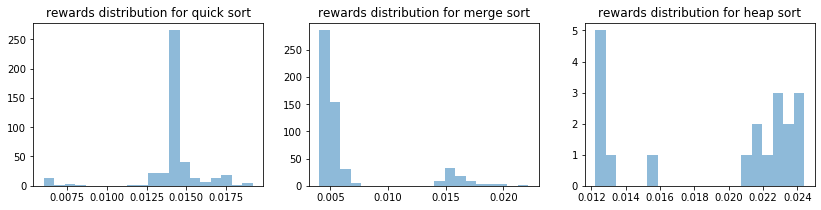

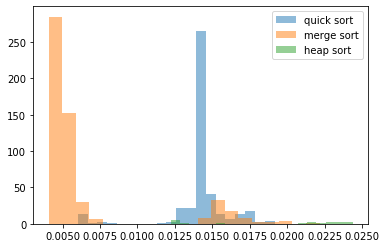

In [33]:
plot_rewards_distribution(arm_rewards_4)
plot_rewards_distribution_together(arm_rewards_4)

Restart at iteration: 229
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014653427647076837, 'merge_sort': 0.016291830909176498, 'heap_sort': 0.023133019999659155}
Count per chosen algo {'quick_sort': 170, 'merge_sort': 55, 'heap_sort': 5}


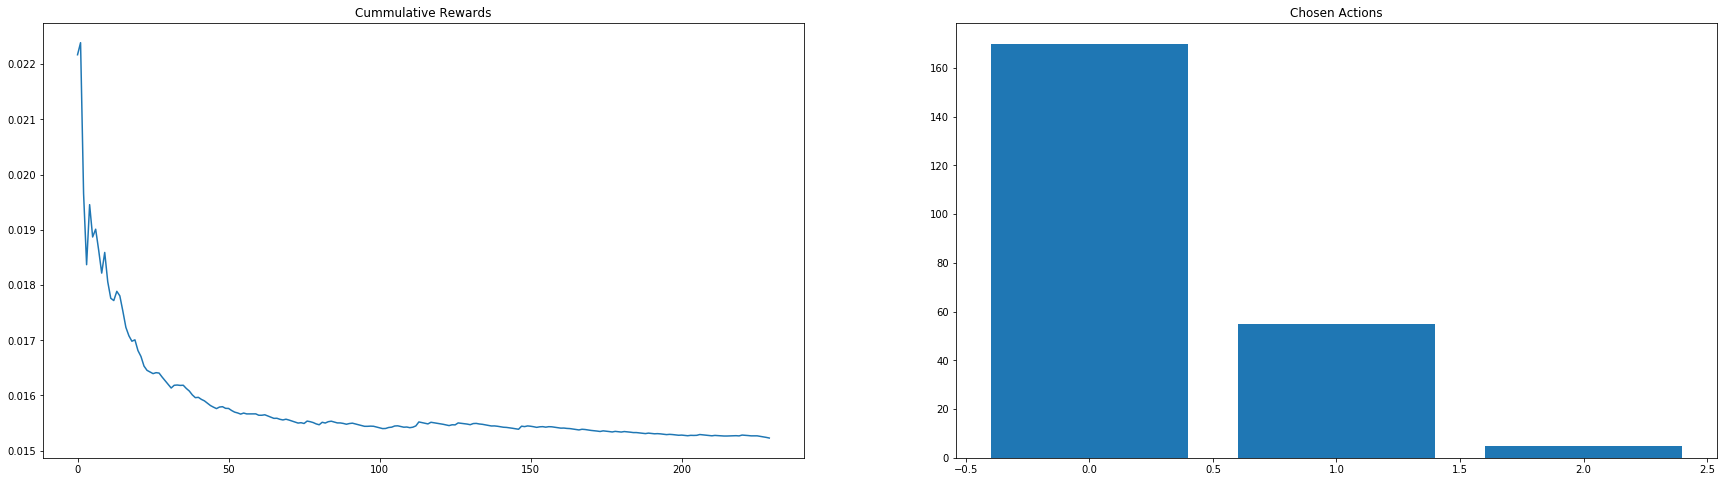

Restart at iteration: 503
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014262919262237715, 'merge_sort': 0.016402426087077638, 'heap_sort': 0.022716928571363888}
Count per chosen algo {'quick_sort': 244, 'merge_sort': 23, 'heap_sort': 7}


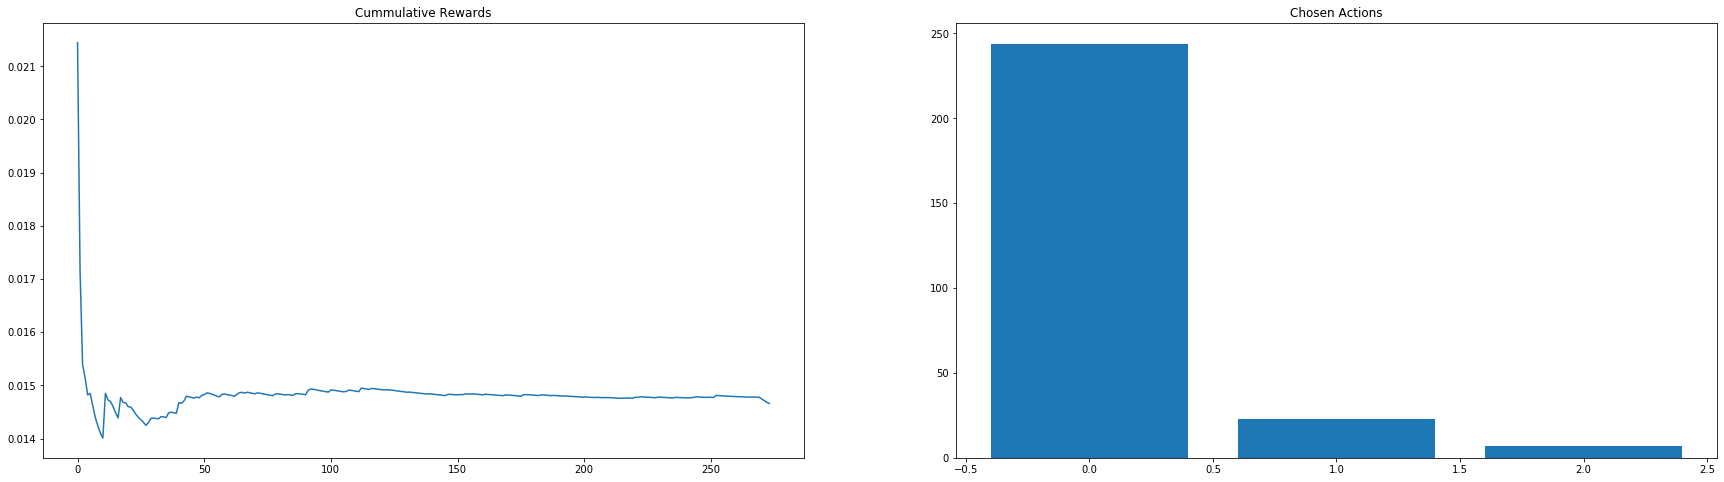

Restart at iteration: 999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006671306666612508, 'merge_sort': 0.005078539240478864, 'heap_sort': 0.013018971428599408}
Count per chosen algo {'quick_sort': 15, 'merge_sort': 474, 'heap_sort': 7}


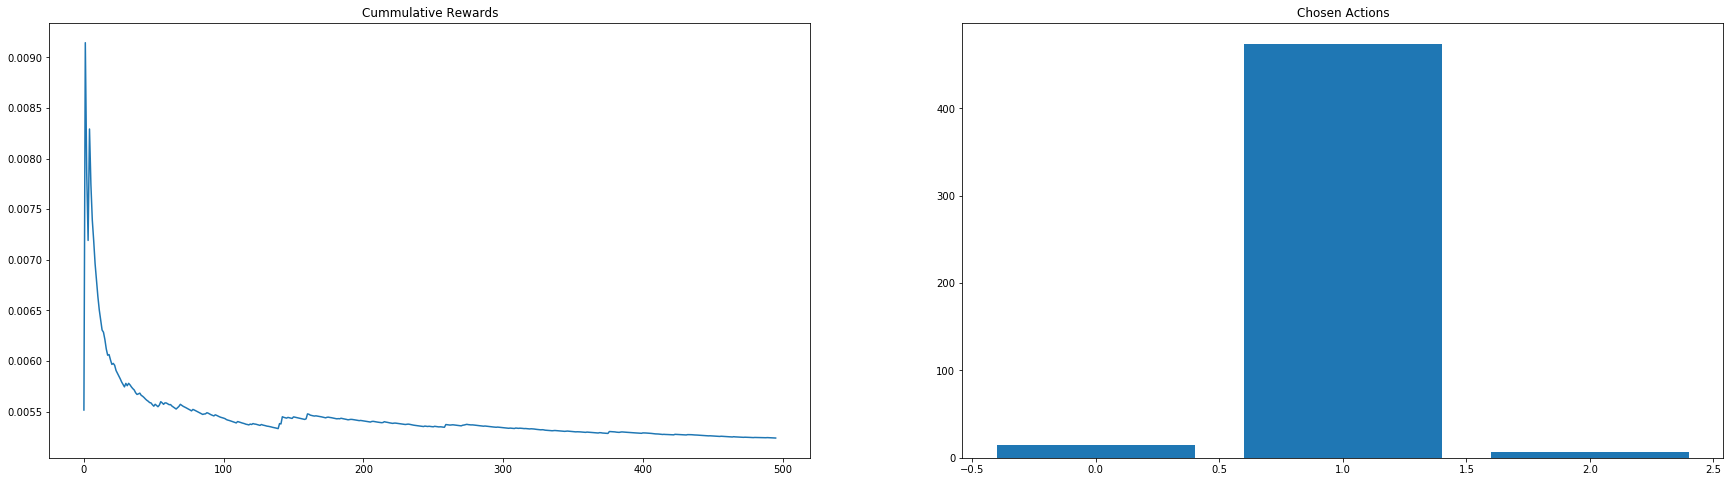

Total reward 10.1177


In [34]:
for elem in list_iteration_results_4:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_4,4))

## Five outliers in a row restart the expriment

In [35]:
list_iteration_results_5, total_reward_5, arm_rewards_5 = ts_quantile(list_distributions, n_samples, num_consec_elem=5)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.044760818577991315
Less than two values for merge_sort
merge_sort Theta 0.04397865112891243
Less than two values for heap_sort
heap_sort Theta 0.08651560486990226


Chosen algorithm is:  merge_sort with reward: 0.027549800000088
Sample mean is:  0.027549800000088 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.025862448818184103
Less than two values for merge_sort
merge_sort Theta 0.05982940987944771
Less than two values for heap_sort
heap_sort Theta 0.01897989778118815


Chosen algorithm is:  heap_sort with reward: 0.02251070000056643
Sample mean is:  0.02251070000056643 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.05072725540079092
Less than two values for merge_sort
merge_sort Theta 0.0029027156646272093
Less than two values for heap_sort
heap_sort Theta 0.03568149806804011


Chosen algorithm is:  merge_sort with reward:



Iteration: 26
quick_sort Theta 0.011766150324540543
merge_sort Theta 0.018890078159440746
Less than two values for heap_sort
heap_sort Theta 0.08453431034085795


Chosen algorithm is:  quick_sort with reward: 0.01579889999993611
Sample mean is:  0.015158916666753916 Sample variance is: 5.119001722308213e-06


Iteration: 27
quick_sort Theta 0.01632111829083958
merge_sort Theta 0.00862180873766655
Less than two values for heap_sort
heap_sort Theta 0.07818994873041973


Chosen algorithm is:  merge_sort with reward: 0.016238799999882758
Sample mean is:  0.01697079999982331 Sample variance is: 1.0892704589640039e-05


Iteration: 28
quick_sort Theta 0.01170228228846862
merge_sort Theta 0.01795684853515398
Less than two values for heap_sort
heap_sort Theta 0.03524899494094953


Chosen algorithm is:  quick_sort with reward: 0.014076300000851916
Sample mean is:  0.01507563846168453 Sample variance is: 4.8084554723286785e-06


Iteration: 29
quick_sort Theta 0.012298364914931848
merge_sort Thet

RESTART EXPERIMENT


Iteration: 57
Less than two values for quick_sort
quick_sort Theta 0.0765466006489121
Less than two values for merge_sort
merge_sort Theta 0.050883647464572704
Less than two values for heap_sort
heap_sort Theta 0.05362466053267592


Chosen algorithm is:  merge_sort with reward: 0.014739299999746436
Sample mean is:  0.014739299999746436 Sample variance is: 0.0


Iteration: 58
Less than two values for quick_sort
quick_sort Theta 0.09095590888272223
Less than two values for merge_sort
merge_sort Theta 0.051854874941328614
Less than two values for heap_sort
heap_sort Theta 0.06985955175259138


Chosen algorithm is:  merge_sort with reward: 0.014969599999858474
Sample mean is:  0.014854449999802455 Sample variance is: 1.3259522512901188e-08


Iteration: 59
Less than two values for quick_sort
quick_sort Theta 0.048531212226806036
merge_sort Theta 0.014849823914999753
Less than two values for heap_sort
heap_sort Theta 0.011279076026887115


Chosen algorithm is:  heap_sort



Chosen algorithm is:  quick_sort with reward: 0.015766200000143726
Sample mean is:  0.013162754999984826 Sample variance is: 1.1276087194211742e-06


Iteration: 90
quick_sort Theta 0.014616163320500265
merge_sort Theta 0.011847034201141662
heap_sort Theta 0.020955328589648894


Chosen algorithm is:  merge_sort with reward: 0.014705900000080874
Sample mean is:  0.01463352727271492 Sample variance is: 6.383308913002363e-07


Iteration: 91
quick_sort Theta 0.012047891057496297
merge_sort Theta 0.015842172151730085
heap_sort Theta 0.02028738873221865


Chosen algorithm is:  quick_sort with reward: 0.012550599999485712
Sample mean is:  0.013133604761865822 Sample variance is: 1.0909077937632987e-06


Iteration: 92
quick_sort Theta 0.01242505228847268
merge_sort Theta 0.017024785226606172
heap_sort Theta 0.021188097618861895


Chosen algorithm is:  quick_sort with reward: 0.012862499999755528
Sample mean is:  0.013121281818133535 Sample variance is: 1.0445100296517776e-06


Iteration: 93
q



Chosen algorithm is:  merge_sort with reward: 0.017278799999985495
Sample mean is:  0.014641758823499378 Sample variance is: 9.03421841413726e-07


Iteration: 126
quick_sort Theta 0.012477770922157554
merge_sort Theta 0.014246236535764265
heap_sort Theta 0.022191526857150156


Chosen algorithm is:  quick_sort with reward: 0.013202600000113307
Sample mean is:  0.013011438000012277 Sample variance is: 8.505585260009754e-07


Iteration: 127
quick_sort Theta 0.012355244442026854
merge_sort Theta 0.013881468411574477
heap_sort Theta 0.020435631180951833


Chosen algorithm is:  quick_sort with reward: 0.012455199999749311
Sample mean is:  0.01300053137255614 Sample variance is: 8.398286339674412e-07


Iteration: 128
quick_sort Theta 0.013604640694414402
merge_sort Theta 0.015118159222843293
heap_sort Theta 0.02116195646600982


Chosen algorithm is:  quick_sort with reward: 0.012689600000157952
Sample mean is:  0.012994551923086944 Sample variance is: 8.25501527927909e-07


Iteration: 129
q



Iteration: 160
quick_sort Theta 0.013362104157073921
merge_sort Theta 0.013346104762806388
heap_sort Theta 0.021828126370036168


Chosen algorithm is:  merge_sort with reward: 0.01697890000014013
Sample mean is:  0.0146505166666581 Sample variance is: 9.604003847853398e-07


Iteration: 161
quick_sort Theta 0.01338783382398718
merge_sort Theta 0.01555534198420655
heap_sort Theta 0.021058654967381282


Chosen algorithm is:  quick_sort with reward: 0.014235900000130641
Sample mean is:  0.013184564102536966 Sample variance is: 9.281739166564911e-07


Iteration: 162
quick_sort Theta 0.0133378332162493
merge_sort Theta 0.012995868636815348
heap_sort Theta 0.021123942783947344


Chosen algorithm is:  merge_sort with reward: 0.015320599999540718
Sample mean is:  0.014677319999973406 Sample variance is: 9.392264176373977e-07


Iteration: 163
quick_sort Theta 0.01334409221141218
merge_sort Theta 0.015012714776186953
heap_sort Theta 0.021202631329994566


Chosen algorithm is:  quick_sort with r

Chosen algorithm is:  quick_sort with reward: 0.013722799999413837
Sample mean is:  0.01337008811879059 Sample variance is: 9.270262463852493e-07


Iteration: 191
quick_sort Theta 0.01369849456371384
merge_sort Theta 0.01579630434502821
heap_sort Theta 0.021049919578595998


Chosen algorithm is:  quick_sort with reward: 0.01485080000020389
Sample mean is:  0.013384604901941701 Sample variance is: 9.39222190072323e-07


Iteration: 192
quick_sort Theta 0.012863177125787167
merge_sort Theta 0.014277964606124165
heap_sort Theta 0.02094598016088133


Chosen algorithm is:  quick_sort with reward: 0.01428699999996752
Sample mean is:  0.013393366019398263 Sample variance is: 9.379327602997274e-07


Iteration: 193
quick_sort Theta 0.012690404627553243
merge_sort Theta 0.013682978409859858
heap_sort Theta 0.02368434634565371


Chosen algorithm is:  quick_sort with reward: 0.013854700000592857
Sample mean is:  0.013397801923063595 Sample variance is: 9.309409319228716e-07


Iteration: 194
quick_s

quick_sort Theta 0.012684141241877517
merge_sort Theta 0.01554314932852168
heap_sort Theta 0.021956854426485168


Chosen algorithm is:  quick_sort with reward: 0.015465699999367644
Sample mean is:  0.01349458837207502 Sample variance is: 9.86785337575741e-07


Iteration: 223
quick_sort Theta 0.013367753072666582
merge_sort Theta 0.014776955637819809
heap_sort Theta 0.0218697322725407


Chosen algorithm is:  quick_sort with reward: 0.012765500000568863
Sample mean is:  0.01348897999998651 Sample variance is: 9.832522261681791e-07


Iteration: 224
quick_sort Theta 0.013069532275151589
merge_sort Theta 0.015591818036251216
heap_sort Theta 0.021223972946172252


Chosen algorithm is:  quick_sort with reward: 0.012701900000138266
Sample mean is:  0.01348297175571286 Sample variance is: 9.804393538864307e-07


Iteration: 225
quick_sort Theta 0.013763306666595141
merge_sort Theta 0.015771331248363347
heap_sort Theta 0.022009113905946696


Chosen algorithm is:  quick_sort with reward: 0.0125255

merge_sort Theta 0.016453366754515943
heap_sort Theta 0.021717438878775593


Chosen algorithm is:  quick_sort with reward: 0.01857209999980114
Sample mean is:  0.013457568354428814 Sample variance is: 1.0936972907116287e-06


Iteration: 256
quick_sort Theta 0.013926646368967413
merge_sort Theta 0.015497931678101788
heap_sort Theta 0.02171138263371386


Chosen algorithm is:  quick_sort with reward: 0.014027100000021164
Sample mean is:  0.013461150314463986 Sample variance is: 1.0888459005545609e-06


Iteration: 257
quick_sort Theta 0.013671265539470533
merge_sort Theta 0.015079599400222408
heap_sort Theta 0.021347137153148368


Chosen algorithm is:  quick_sort with reward: 0.012977999999748135
Sample mean is:  0.013458130624997011 Sample variance is: 1.0834904590679309e-06


Iteration: 258
quick_sort Theta 0.013243638643614969
merge_sort Theta 0.013992812087270608
heap_sort Theta 0.02008171717036829


Chosen algorithm is:  quick_sort with reward: 0.013697200000024168
Sample mean is:  0.



Iteration: 285
quick_sort Theta 0.013450407703236258
merge_sort Theta 0.015127677617750997
heap_sort Theta 0.020897546201141


Chosen algorithm is:  quick_sort with reward: 0.01442270000006829
Sample mean is:  0.0135308210810812 Sample variance is: 1.0221235459573133e-06


Iteration: 286
quick_sort Theta 0.013782797330021227
merge_sort Theta 0.014853224779616647
heap_sort Theta 0.020984486021682944


Chosen algorithm is:  quick_sort with reward: 0.014212699999916367
Sample mean is:  0.013534487096773861 Sample variance is: 1.019114597221709e-06


Iteration: 287
quick_sort Theta 0.01311514651161261
merge_sort Theta 0.01600631830879397
heap_sort Theta 0.021699031691518798


Chosen algorithm is:  quick_sort with reward: 0.013966700000310084
Sample mean is:  0.013536798395723254 Sample variance is: 1.0146584176684022e-06


Iteration: 288
quick_sort Theta 0.012969151694494592
merge_sort Theta 0.015380841836595258
heap_sort Theta 0.0214592788990418


Chosen algorithm is:  quick_sort with r



Iteration: 318
quick_sort Theta 0.01368603595952975
merge_sort Theta 0.016648811105677227
heap_sort Theta 0.02154795842983538


Chosen algorithm is:  quick_sort with reward: 0.015080999999554479
Sample mean is:  0.01361464444443283 Sample variance is: 1.053940460657753e-06


Iteration: 319
quick_sort Theta 0.01340139782365904
merge_sort Theta 0.014266605046166527
heap_sort Theta 0.02178401494763951


Chosen algorithm is:  quick_sort with reward: 0.013871400000425638
Sample mean is:  0.013615827649759984 Sample variance is: 1.0493859867422406e-06


Iteration: 320
quick_sort Theta 0.013924133812250567
merge_sort Theta 0.016598416660193092
heap_sort Theta 0.020874813149032768


Chosen algorithm is:  quick_sort with reward: 0.013788200000817596
Sample mean is:  0.013616618348618046 Sample variance is: 1.044707958971808e-06


Iteration: 321
quick_sort Theta 0.013480357199627967
merge_sort Theta 0.01442307704846946
heap_sort Theta 0.021113005953116496


Chosen algorithm is:  quick_sort wit

quick_sort Theta 0.013434225699239803
merge_sort Theta 0.015391976293064932
heap_sort Theta 0.02091600933497096


Chosen algorithm is:  quick_sort with reward: 0.01690969999981462
Sample mean is:  0.013663440243898942 Sample variance is: 9.90043705438586e-07


Iteration: 350
quick_sort Theta 0.013239599598517855
merge_sort Theta 0.015642395623323032
heap_sort Theta 0.021839378659402678


Chosen algorithm is:  quick_sort with reward: 0.014112800000475545
Sample mean is:  0.013665259514168481 Sample variance is: 9.86849628428653e-07


Iteration: 351
quick_sort Theta 0.013950868549810248
merge_sort Theta 0.014005694399542301
heap_sort Theta 0.021410352855965622


Chosen algorithm is:  quick_sort with reward: 0.013731600000028266
Sample mean is:  0.013665527016127594 Sample variance is: 9.828880707085946e-07


Iteration: 352
quick_sort Theta 0.014155493987738606
merge_sort Theta 0.015313698194986234
heap_sort Theta 0.021598967861506932


Chosen algorithm is:  quick_sort with reward: 0.0136



Iteration: 386
quick_sort Theta 0.01400704403336429
merge_sort Theta 0.015168366299280955
heap_sort Theta 0.022260308854320614


Chosen algorithm is:  quick_sort with reward: 0.015071700000589772
Sample mean is:  0.013718697142842627 Sample variance is: 1.0132882552123312e-06


Iteration: 387
quick_sort Theta 0.013990791164422044
merge_sort Theta 0.015333695380775293
heap_sort Theta 0.021146935611769987


Chosen algorithm is:  quick_sort with reward: 0.014063600000554288
Sample mean is:  0.013719924555147651 Sample variance is: 1.010104078657291e-06


Iteration: 388
quick_sort Theta 0.013840678639784694
merge_sort Theta 0.015319585988231675
heap_sort Theta 0.022166816569145126


Chosen algorithm is:  quick_sort with reward: 0.013626900000417663
Sample mean is:  0.013719594680840098 Sample variance is: 1.0065527268938686e-06


Iteration: 389
quick_sort Theta 0.01440327124797243
merge_sort Theta 0.015181258106267262
heap_sort Theta 0.02111098995490418


Chosen algorithm is:  quick_sort



Chosen algorithm is:  quick_sort with reward: 0.016701099999409053
Sample mean is:  0.013752360702858768 Sample variance is: 9.6908444965349e-07


Iteration: 420
quick_sort Theta 0.013893692468251099
merge_sort Theta 0.01589619413994904
heap_sort Theta 0.021150788655834498


Chosen algorithm is:  quick_sort with reward: 0.014324600000691134
Sample mean is:  0.01375418312100473 Sample variance is: 9.670377315167064e-07


Iteration: 421
quick_sort Theta 0.013458015317494378
merge_sort Theta 0.016601975048874843
heap_sort Theta 0.021712045458571524


Chosen algorithm is:  quick_sort with reward: 0.013889600000766222
Sample mean is:  0.013754613015861117 Sample variance is: 9.640258006747621e-07


Iteration: 422
quick_sort Theta 0.013361870635680412
merge_sort Theta 0.013890169014418849
heap_sort Theta 0.021341951031512485


Chosen algorithm is:  quick_sort with reward: 0.013750599999184487
Sample mean is:  0.013754600316441254 Sample variance is: 9.609751369173731e-07


Iteration: 423
q



Iteration: 450
quick_sort Theta 0.01381362707147217
merge_sort Theta 0.013947275594347391
heap_sort Theta 0.021030967312635065


Chosen algorithm is:  quick_sort with reward: 0.015812699999514734
Sample mean is:  0.013780955847937947 Sample variance is: 9.580977722754227e-07


Iteration: 451
quick_sort Theta 0.013493041595570996
merge_sort Theta 0.014997428784855625
heap_sort Theta 0.021339250039350135


Chosen algorithm is:  quick_sort with reward: 0.013903799999752664
Sample mean is:  0.01378131399415315 Sample variance is: 9.55348352208926e-07


Iteration: 452
quick_sort Theta 0.0137262341609335
merge_sort Theta 0.01396908683699185
heap_sort Theta 0.021198575732636258


Chosen algorithm is:  quick_sort with reward: 0.013858799999979965
Sample mean is:  0.01378153924417009 Sample variance is: 9.52588579753013e-07


Iteration: 453
quick_sort Theta 0.013877593715668247
merge_sort Theta 0.014184632288746698
heap_sort Theta 0.021098084935097336


Chosen algorithm is:  quick_sort with r

merge_sort Theta 0.014978578075447323
heap_sort Theta 0.020952619817227527


Chosen algorithm is:  quick_sort with reward: 0.017269199999645934
Sample mean is:  0.013822217567554322 Sample variance is: 1.0308336944688283e-06


Iteration: 481
quick_sort Theta 0.013622183009287204
merge_sort Theta 0.014817216091553249
heap_sort Theta 0.021794689702098424


Chosen algorithm is:  quick_sort with reward: 0.014481299999715702
Sample mean is:  0.013823994070066885 Sample variance is: 1.0292228726260202e-06


Iteration: 482
quick_sort Theta 0.013608825000115553
merge_sort Theta 0.015485886477496729
heap_sort Theta 0.02073689667379744


Chosen algorithm is:  quick_sort with reward: 0.013969300000098883
Sample mean is:  0.013824384677405682 Sample variance is: 1.0265127494623477e-06


Iteration: 483
quick_sort Theta 0.014122234573992802
merge_sort Theta 0.014013424410330967
heap_sort Theta 0.020803042312537726


Chosen algorithm is:  merge_sort with reward: 0.015457299999980023
Sample mean is:  



Iteration: 511
quick_sort Theta 0.006451822805001112
Less than two values for merge_sort
merge_sort Theta 0.021046812129582194
Less than two values for heap_sort
heap_sort Theta 0.020334826751256332


Chosen algorithm is:  quick_sort with reward: 0.007471199999599776
Sample mean is:  0.006632533333383132 Sample variance is: 1.5052407875484003e-07


Iteration: 512
quick_sort Theta 0.0063898094094163825
Less than two values for merge_sort
merge_sort Theta 0.05360028441278672
Less than two values for heap_sort
heap_sort Theta 0.02846100603777335


Chosen algorithm is:  quick_sort with reward: 0.006514100000458711
Sample mean is:  0.006615614285822501 Sample variance is: 1.3073816395487347e-07


Iteration: 513
quick_sort Theta 0.0068018792415360015
Less than two values for merge_sort
merge_sort Theta 0.0044430353794110205
Less than two values for heap_sort
heap_sort Theta 0.09644974257621583


Chosen algorithm is:  merge_sort with reward: 0.004740000000310829
Sample mean is:  0.004740000

Less than two values for heap_sort
heap_sort Theta 0.09028515342825288


Chosen algorithm is:  merge_sort with reward: 0.005443399999421672
Sample mean is:  0.004779915789520983 Sample variance is: 1.1524998549547132e-07


Iteration: 545
quick_sort Theta 0.006325004920618633
merge_sort Theta 0.004820680848363065
Less than two values for heap_sort
heap_sort Theta 0.09635938413383184


Chosen algorithm is:  merge_sort with reward: 0.004808699999557575
Sample mean is:  0.0047813550000228135 Sample variance is: 1.0952684143120075e-07


Iteration: 546
quick_sort Theta 0.006393956282419056
merge_sort Theta 0.004341319072054787
Less than two values for heap_sort
heap_sort Theta 0.034444599355744746


Chosen algorithm is:  merge_sort with reward: 0.004867800000283751
Sample mean is:  0.004785471428606668 Sample variance is: 1.0465017723924392e-07


Iteration: 547
quick_sort Theta 0.0062462615239287245
merge_sort Theta 0.004101403249372179
Less than two values for heap_sort
heap_sort Theta 0.03

Iteration: 576
quick_sort Theta 0.0068283611603988945
merge_sort Theta 0.004970069807083226
heap_sort Theta 0.015088385399450321


Chosen algorithm is:  merge_sort with reward: 0.005483799999637995
Sample mean is:  0.004769236734727182 Sample variance is: 1.0691925656364732e-07


Iteration: 577
quick_sort Theta 0.006699730670479203
merge_sort Theta 0.004848057030794816
heap_sort Theta -0.007457947189889558


Chosen algorithm is:  heap_sort with reward: 0.012469299999793293
Sample mean is:  0.012829950000195822 Sample variance is: 1.0739715727823518e-06


Iteration: 578
quick_sort Theta 0.00657645892744595
merge_sort Theta 0.004462241302286754
heap_sort Theta 0.014791922207616293


Chosen algorithm is:  merge_sort with reward: 0.004521300000305928
Sample mean is:  0.0047642780000387575 Sample variance is: 1.0598573486817368e-07


Iteration: 579
quick_sort Theta 0.006656737827845196
merge_sort Theta 0.0049351644577320455
heap_sort Theta 0.014747378402951141


Chosen algorithm is:  merge_

Chosen algorithm is:  heap_sort with reward: 0.011905299999853014
Sample mean is:  0.012540983333565237 Sample variance is: 8.840962048861176e-07


Iteration: 607
quick_sort Theta 0.006564437363747229
merge_sort Theta 0.004484218442067877
heap_sort Theta 0.012971455799895512


Chosen algorithm is:  merge_sort with reward: 0.004467100000510982
Sample mean is:  0.004713354545490258 Sample variance is: 1.1507854320107111e-07


Iteration: 608
quick_sort Theta 0.006692247865970543
merge_sort Theta 0.004535670290159812
heap_sort Theta 0.011324695115841455


Chosen algorithm is:  merge_sort with reward: 0.004744899999423069
Sample mean is:  0.004713758974386833 Sample variance is: 1.1361577159298946e-07


Iteration: 609
quick_sort Theta 0.006987629118942652
merge_sort Theta 0.004623045661168444
heap_sort Theta 0.012745191618175887


Chosen algorithm is:  merge_sort with reward: 0.004625800000212621
Sample mean is:  0.004712645569650451 Sample variance is: 1.1227429153737348e-07


Iteration: 6

merge_sort Theta 0.00454719609283685
heap_sort Theta 0.01107099197382035


Chosen algorithm is:  merge_sort with reward: 0.005379299999731302
Sample mean is:  0.004725667889892933 Sample variance is: 1.6259470009126563e-07


Iteration: 640
quick_sort Theta 0.006858575902013893
merge_sort Theta 0.004668836967019415
heap_sort Theta 0.012502884571401715


Chosen algorithm is:  merge_sort with reward: 0.004569900000205962
Sample mean is:  0.0047242518181685065 Sample variance is: 1.6133513969910297e-07


Iteration: 641
quick_sort Theta 0.0065113240377895785
merge_sort Theta 0.004676108398263853
heap_sort Theta 0.014324625763817038


Chosen algorithm is:  merge_sort with reward: 0.004649800000152027
Sample mean is:  0.004723581081069258 Sample variance is: 1.599311576802778e-07


Iteration: 642
quick_sort Theta 0.006201705159450398
merge_sort Theta 0.004646129566651244
heap_sort Theta 0.013289634792140625


Chosen algorithm is:  merge_sort with reward: 0.004504800000177056
Sample mean is:  



Iteration: 672
quick_sort Theta 0.006404165699169203
merge_sort Theta 0.004566427210869721
heap_sort Theta 0.012440988469202307


Chosen algorithm is:  merge_sort with reward: 0.004435099999682279
Sample mean is:  0.004711890140838413 Sample variance is: 1.4505730927895962e-07


Iteration: 673
quick_sort Theta 0.006562576186087944
merge_sort Theta 0.004841881935687553
heap_sort Theta 0.010344861348722914


Chosen algorithm is:  merge_sort with reward: 0.0046133000005283975
Sample mean is:  0.004711200699297783 Sample variance is: 1.4411041930937333e-07


Iteration: 674
quick_sort Theta 0.006159297383550922
merge_sort Theta 0.004560248528639902
heap_sort Theta 0.01396296169240058


Chosen algorithm is:  merge_sort with reward: 0.00443360000008397
Sample mean is:  0.004709272916664354 Sample variance is: 1.4364108996970427e-07


Iteration: 675
quick_sort Theta 0.0062202529934689
merge_sort Theta 0.004719784822314039
heap_sort Theta 0.013295050739503366


Chosen algorithm is:  merge_sor



Iteration: 707
quick_sort Theta 0.0062418466332426715
merge_sort Theta 0.0046426030344541205
heap_sort Theta 0.013131208029247365


Chosen algorithm is:  merge_sort with reward: 0.004703700000391109
Sample mean is:  0.004688905084729177 Sample variance is: 1.3492210506570777e-07


Iteration: 708
quick_sort Theta 0.006354448879573118
merge_sort Theta 0.0049798942084203135
heap_sort Theta 0.012475569270301162


Chosen algorithm is:  merge_sort with reward: 0.004608700000062527
Sample mean is:  0.004688454494365881 Sample variance is: 1.3420005231796865e-07


Iteration: 709
quick_sort Theta 0.006511493883164865
merge_sort Theta 0.004765841913869332
heap_sort Theta 0.009492398217832092


Chosen algorithm is:  merge_sort with reward: 0.004480600000533741
Sample mean is:  0.004687293296076316 Sample variance is: 1.3369034325654704e-07


Iteration: 710
quick_sort Theta 0.006227340785400305
merge_sort Theta 0.00483287553891231
heap_sort Theta 0.013055184920349133


Chosen algorithm is:  merg



Chosen algorithm is:  merge_sort with reward: 0.0053713000006609946
Sample mean is:  0.004683932857135785 Sample variance is: 1.4161322292389817e-07


Iteration: 741
quick_sort Theta 0.00665036267488889
merge_sort Theta 0.004711376761166842
heap_sort Theta 0.011694644739753077


Chosen algorithm is:  merge_sort with reward: 0.005412399999841
Sample mean is:  0.00468738530804908 Sample variance is: 1.434451478434482e-07


Iteration: 742
quick_sort Theta 0.006500705289532787
merge_sort Theta 0.004490298981529924
heap_sort Theta 0.012797924549260598


Chosen algorithm is:  merge_sort with reward: 0.004599100000632461
Sample mean is:  0.004686968867919756 Sample variance is: 1.4280511191003954e-07


Iteration: 743
quick_sort Theta 0.006256452710921469
merge_sort Theta 0.0047847573235915266
heap_sort Theta 0.01196967098195208


Chosen algorithm is:  merge_sort with reward: 0.00453769999967335
Sample mean is:  0.004686268075111087 Sample variance is: 1.422387808141151e-07


Iteration: 744


merge_sort Theta 0.004860197000407183
heap_sort Theta 0.01375223342927511


Chosen algorithm is:  merge_sort with reward: 0.005218799999965995
Sample mean is:  0.004689649590165543 Sample variance is: 1.4817558558057165e-07


Iteration: 775
quick_sort Theta 0.006338217854049141
merge_sort Theta 0.004664682493145091
heap_sort Theta 0.011828486753952448


Chosen algorithm is:  merge_sort with reward: 0.005651100000250153
Sample mean is:  0.004693573877553643 Sample variance is: 1.5132839495915413e-07


Iteration: 776
quick_sort Theta 0.006867677795377228
merge_sort Theta 0.004634002045636018
heap_sort Theta 0.014812700603716422


Chosen algorithm is:  merge_sort with reward: 0.004810599999473197
Sample mean is:  0.004694049593496405 Sample variance is: 1.50768683768343e-07


Iteration: 777
quick_sort Theta 0.006582691279183024
merge_sort Theta 0.004437224695586292
heap_sort Theta 0.013002904556735832


Chosen algorithm is:  merge_sort with reward: 0.004139199999372067
Sample mean is:  0.

quick_sort Theta 0.006877362638372973
merge_sort Theta 0.004743323600256695
heap_sort Theta 0.011962671995336266


Chosen algorithm is:  merge_sort with reward: 0.005197100000259525
Sample mean is:  0.004694308695651789 Sample variance is: 1.496963362843152e-07


Iteration: 808
quick_sort Theta 0.006625850804118028
merge_sort Theta 0.004645140630473175
heap_sort Theta 0.010472294751254873


Chosen algorithm is:  merge_sort with reward: 0.005269899999802874
Sample mean is:  0.004696386642598183 Sample variance is: 1.503476466270488e-07


Iteration: 809
quick_sort Theta 0.0060277004708464
merge_sort Theta 0.004686597232437911
heap_sort Theta 0.010863589576192392


Chosen algorithm is:  merge_sort with reward: 0.00422800000069401
Sample mean is:  0.004694701798562557 Sample variance is: 1.5059314749484462e-07


Iteration: 810
quick_sort Theta 0.006740027635929587
merge_sort Theta 0.004767325831853552
heap_sort Theta 0.012725297039032484


Chosen algorithm is:  merge_sort with reward: 0.00



Chosen algorithm is:  merge_sort with reward: 0.006555300000400166
Sample mean is:  0.004697324595473958 Sample variance is: 1.5579665672593842e-07


Iteration: 841
quick_sort Theta 0.006448448284814911
merge_sort Theta 0.0046187820240589554
heap_sort Theta 0.010645303155655967


Chosen algorithm is:  merge_sort with reward: 0.004564400000163005
Sample mean is:  0.004696895806456826 Sample variance is: 1.5535089961208698e-07


Iteration: 842
quick_sort Theta 0.006939588015635641
merge_sort Theta 0.0046801102018129296
heap_sort Theta 0.01198966961251102


Chosen algorithm is:  merge_sort with reward: 0.004675200000747282
Sample mean is:  0.004696826045023676 Sample variance is: 1.5485288769839826e-07


Iteration: 843
quick_sort Theta 0.005765791073226199
merge_sort Theta 0.004779109450912569
heap_sort Theta 0.010574603855921029


Chosen algorithm is:  merge_sort with reward: 0.004678700000113167
Sample mean is:  0.004696767948725886 Sample variance is: 1.543576140213136e-07


Iteratio


Iteration: 872
quick_sort Theta 0.006592036927485455
merge_sort Theta 0.004880357682205806
heap_sort Theta 0.012059544496795445


Chosen algorithm is:  merge_sort with reward: 0.005515500000001339
Sample mean is:  0.004704529912034074 Sample variance is: 1.6505772172839215e-07


Iteration: 873
quick_sort Theta 0.006783757806348849
merge_sort Theta 0.004757393667855226
heap_sort Theta 0.013447861147604646


Chosen algorithm is:  merge_sort with reward: 0.0046288000003187335
Sample mean is:  0.004704308479543678 Sample variance is: 1.6459181684165846e-07


Iteration: 874
quick_sort Theta 0.00646600396647071
merge_sort Theta 0.0044067386878588
heap_sort Theta 0.01366705618907477


Chosen algorithm is:  merge_sort with reward: 0.004668200000196521
Sample mean is:  0.004704203207009138 Sample variance is: 1.6411574746617146e-07


Iteration: 875
quick_sort Theta 0.006689219766930752
merge_sort Theta 0.004581389626879923
heap_sort Theta 0.012448708759926467


Chosen algorithm is:  merge_sort



Iteration: 905
quick_sort Theta 0.006254711338169097
merge_sort Theta 0.0045705573596604866
heap_sort Theta 0.014800657968638026


Chosen algorithm is:  merge_sort with reward: 0.005008199999792851
Sample mean is:  0.004707535294119955 Sample variance is: 1.6446242258724297e-07


Iteration: 906
quick_sort Theta 0.006789294892819896
merge_sort Theta 0.004602408252559474
heap_sort Theta 0.0075372243541530475


Chosen algorithm is:  merge_sort with reward: 0.004635999999663909
Sample mean is:  0.004707344533334739 Sample variance is: 1.6403746586627427e-07


Iteration: 907
quick_sort Theta 0.005885348972899033
merge_sort Theta 0.004746634860276471
heap_sort Theta 0.014253106103972095


Chosen algorithm is:  merge_sort with reward: 0.004730999999992491
Sample mean is:  0.004707407446809892 Sample variance is: 1.6360268029975545e-07


Iteration: 908
quick_sort Theta 0.006096394603377617
merge_sort Theta 0.004645838190966957
heap_sort Theta 0.01127298295112212


Chosen algorithm is:  merge



Iteration: 938
quick_sort Theta 0.006892991129782019
merge_sort Theta 0.004680360402836063
heap_sort Theta 0.01168757329842949


Chosen algorithm is:  merge_sort with reward: 0.005201599999963946
Sample mean is:  0.004706573464378689 Sample variance is: 1.6396026645364158e-07


Iteration: 939
quick_sort Theta 0.005861398128508526
merge_sort Theta 0.004921329751347968
heap_sort Theta 0.010407983426733623


Chosen algorithm is:  merge_sort with reward: 0.004612700000507175
Sample mean is:  0.004706343382359395 Sample variance is: 1.6357994871386085e-07


Iteration: 940
quick_sort Theta 0.006859614771312848
merge_sort Theta 0.004619129689625078
heap_sort Theta 0.011790326411816135


Chosen algorithm is:  merge_sort with reward: 0.004546300000583869
Sample mean is:  0.004705952078247475 Sample variance is: 1.632424702534768e-07


Iteration: 941
quick_sort Theta 0.006975323753639377
merge_sort Theta 0.004611465440102527
heap_sort Theta 0.01573015041545552


Chosen algorithm is:  merge_sor

merge_sort Theta 0.004662164029939292
heap_sort Theta 0.014707630545231203


Chosen algorithm is:  merge_sort with reward: 0.005330399999365909
Sample mean is:  0.004706229223750734 Sample variance is: 1.6021370127654247e-07


Iteration: 970
quick_sort Theta 0.0066609314610111105
merge_sort Theta 0.004728971262123313
heap_sort Theta 0.012673300970091375


Chosen algorithm is:  merge_sort with reward: 0.004684399999860034
Sample mean is:  0.004706179498867156 Sample variance is: 1.5984983277604933e-07


Iteration: 971
quick_sort Theta 0.006614400628859082
merge_sort Theta 0.004622758679706732
heap_sort Theta 0.011585947579547718


Chosen algorithm is:  merge_sort with reward: 0.004574900000079651
Sample mean is:  0.004705881136369912 Sample variance is: 1.595256175604738e-07


Iteration: 972
quick_sort Theta 0.006251644288477971
merge_sort Theta 0.004610097529436342
heap_sort Theta 0.011996961557243996


Chosen algorithm is:  merge_sort with reward: 0.0045342000003074645
Sample mean is:

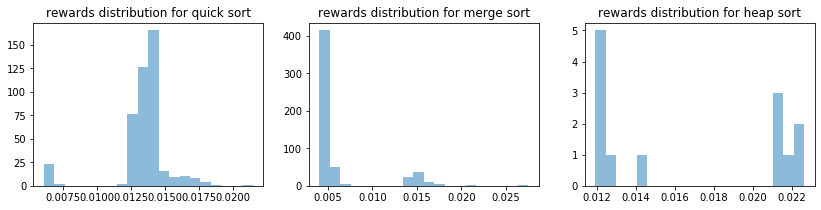

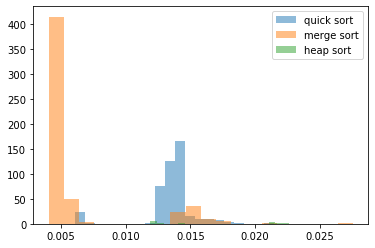

In [36]:
plot_rewards_distribution(arm_rewards_5)
plot_rewards_distribution_together(arm_rewards_5)

Restart at iteration: 56
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.014384620000115925, 'merge_sort': 0.01643358799985435, 'heap_sort': 0.022577950000140845}
Count per chosen algo {'quick_sort': 30, 'merge_sort': 25, 'heap_sort': 2}


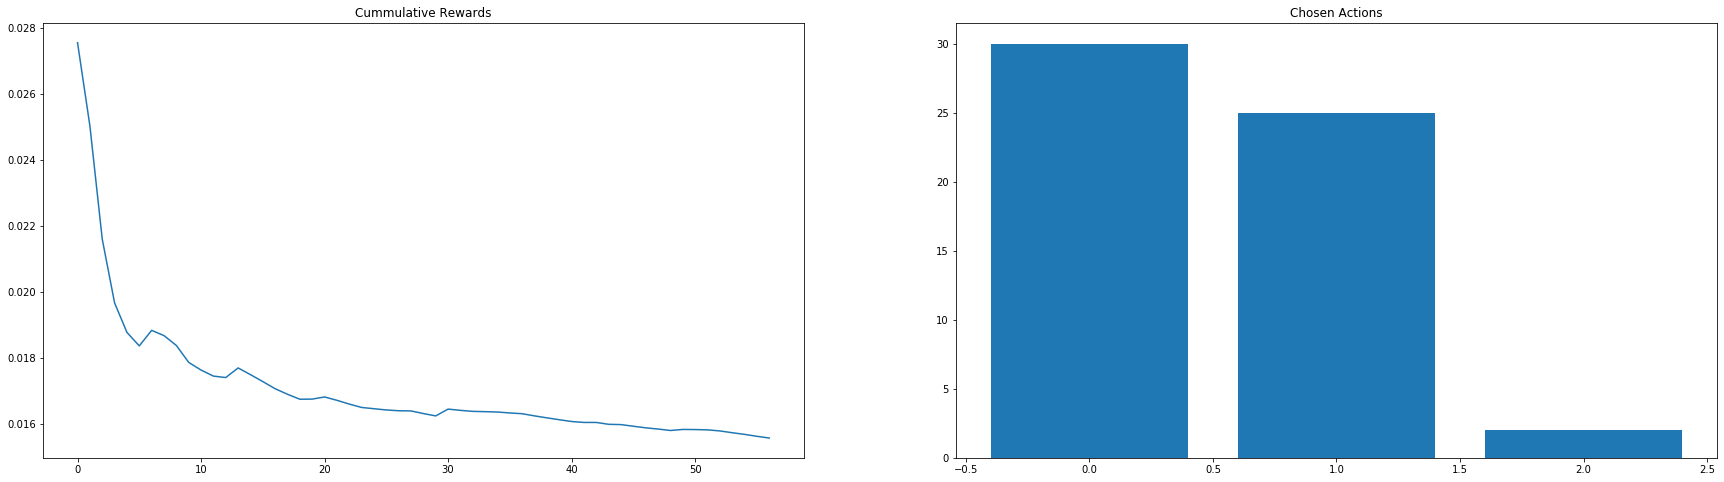

Restart at iteration: 504
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.013738066666655984, 'merge_sort': 0.01499323725486237, 'heap_sort': 0.02146495000010873}
Count per chosen algo {'quick_sort': 393, 'merge_sort': 51, 'heap_sort': 4}


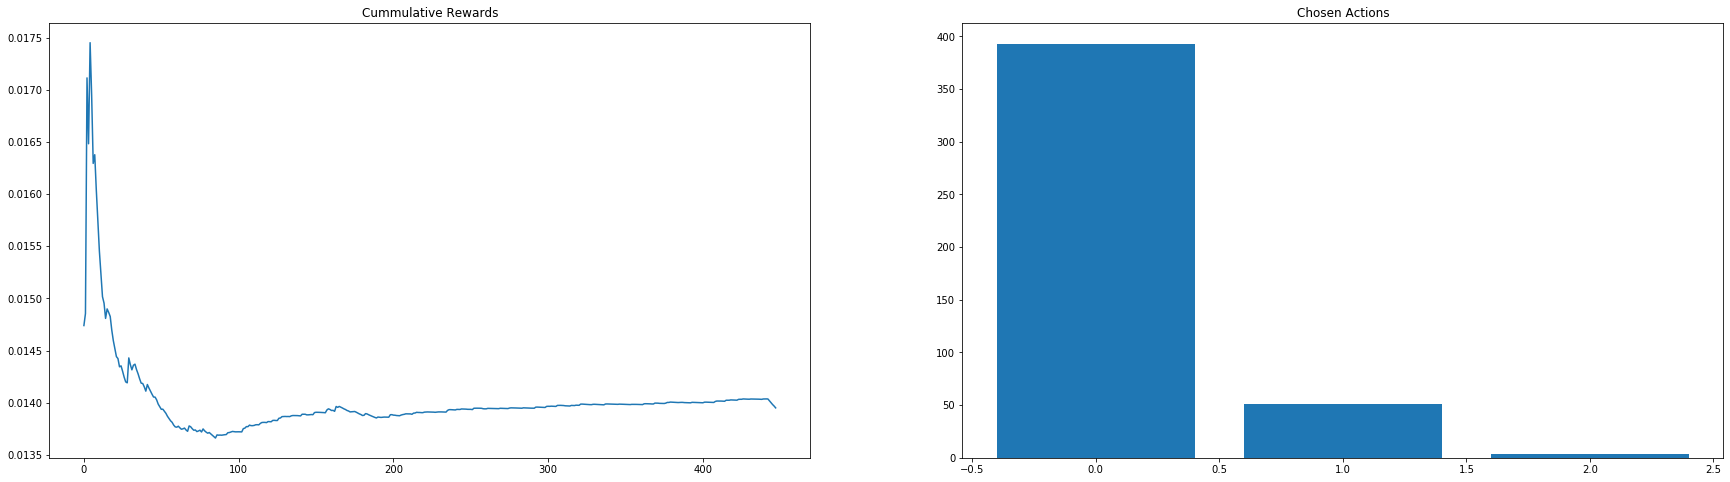

Restart at iteration: 999
Results up to this iteration: 
Average rewards per algo {'quick_sort': 0.006461685000022044, 'merge_sort': 0.004703422222233619, 'heap_sort': 0.012475500000229138}
Count per chosen algo {'quick_sort': 20, 'merge_sort': 468, 'heap_sort': 7}


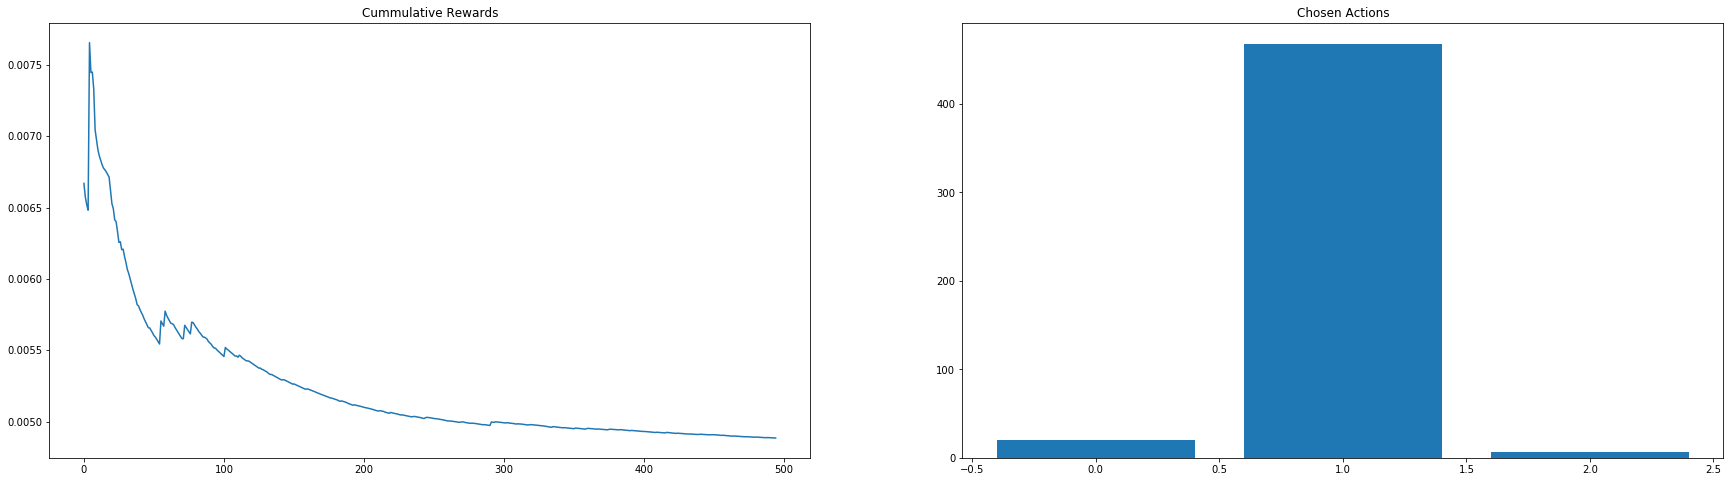

Total reward 9.5549


In [37]:
for elem in list_iteration_results_5:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Restart at iteration:", n)
    print("Results up to this iteration: ")
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_5,4))